In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
cm_target[0]

'NACA0018cm_blade1.csv'

In [11]:
str(cm_target[0])

'NACA0018cm_blade1.csv'

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    #total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    x = t
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    file = cm_target
    df = pd.DataFrame()

    data = pd.read_csv(file, header=None)
    df = pd.concat([df, data], axis=0)

    time = df.iloc[:,0].values
    cm = df.iloc[:,1].values

    time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
    cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]

    # Handle the time that is duplicated because of digits
    # Also, outliers are regulated at the second conditional statement.
    time_beUsed = handler_time(time_beUsed)
    cm_beUsed = handler_cm(cm_beUsed)

    linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                       bounds_error=False,kind='quadratic',
                                       fill_value='extrapolate')
    time_interp = np.arange(10, 15, t_interval).reshape((-1,1))

    cm_interp=linear_func(time_interp).reshape((-1,1))

    cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and $C_m$: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>10:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target[0], n_beta, t_len, normalize=True)

Dimension - time and $C_m$:  (5000, 2)
Dimension - x:  (5000, 1)
Dimension - y:  (5000, 1)


In [21]:
x -=10

In [22]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [23]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=26)

In [24]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=1)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [25]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20221226_noflap"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20221226unsteadyPrediction_MLP_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-07,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-8, min_lr=1e-06, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/3 [=========>....................] - ETA: 2s - loss: 0.1669 - rmse: 0.4084
Epoch 1: val_loss improved from inf to 0.12189, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 2s 296ms/step - loss: 0.1430 - rmse: 0.3781 - val_loss: 0.1219 - val_rmse: 0.3490 - lr: 1.0000e-04
Epoch 2/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1319 - rmse: 0.3631
Epoch 2: val_loss improved from 0.12189 to 0.10229, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.1117 - rmse: 0.3340 - val_loss: 0.1023 - val_rmse: 0.3197 - lr: 1.0000e-04
Epoch 3/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1000 - rmse: 0.3160
Epoch 3: val_loss improved from 0.10229 to 0.09947, saving model to D:\TrainedModels\20221226_noflap

Epoch 22/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0731 - rmse: 0.2703
Epoch 22: val_loss improved from 0.07869 to 0.07722, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 36ms/step - loss: 0.0775 - rmse: 0.2781 - val_loss: 0.0772 - val_rmse: 0.2777 - lr: 1.0000e-04
Epoch 23/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0731 - rmse: 0.2702
Epoch 23: val_loss improved from 0.07722 to 0.07563, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 36ms/step - loss: 0.0738 - rmse: 0.2715 - val_loss: 0.0756 - val_rmse: 0.2748 - lr: 1.0000e-04
Epoch 24/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0754 - rmse: 0.2745
Epoch 24: val_loss improved from 0.07563 to 0.07415, saving model to D:\TrainedModels\202212

Epoch 44/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0605 - rmse: 0.2459
Epoch 44: val_loss improved from 0.06573 to 0.06567, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0660 - rmse: 0.2567 - val_loss: 0.0657 - val_rmse: 0.2561 - lr: 1.0000e-04
Epoch 45/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0651 - rmse: 0.2549
Epoch 45: val_loss improved from 0.06567 to 0.06563, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0641 - rmse: 0.2529 - val_loss: 0.0656 - val_rmse: 0.2560 - lr: 1.0000e-04
Epoch 46/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0738 - rmse: 0.2714
Epoch 46: val_loss did not improve from 0.06563
3/3 [==============================] - 0s 20

3/3 [==============================] - 0s 21ms/step - loss: 0.0632 - rmse: 0.2511 - val_loss: 0.0651 - val_rmse: 0.2550 - lr: 1.0000e-04
Epoch 67/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0681 - rmse: 0.2607
Epoch 67: val_loss improved from 0.06489 to 0.06484, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0647 - rmse: 0.2543 - val_loss: 0.0648 - val_rmse: 0.2544 - lr: 1.0000e-04
Epoch 68/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0669 - rmse: 0.2584
Epoch 68: val_loss improved from 0.06484 to 0.06476, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0652 - rmse: 0.2552 - val_loss: 0.0648 - val_rmse: 0.2543 - lr: 1.0000e-04
Epoch 69/10000
1/3 [=========>.................

3/3 [==============================] - 0s 62ms/step - loss: 0.0640 - rmse: 0.2528 - val_loss: 0.0638 - val_rmse: 0.2524 - lr: 1.0000e-04
Epoch 89/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0646 - rmse: 0.2540
Epoch 89: val_loss improved from 0.06382 to 0.06376, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0642 - rmse: 0.2532 - val_loss: 0.0638 - val_rmse: 0.2523 - lr: 1.0000e-04
Epoch 90/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0618 - rmse: 0.2485
Epoch 90: val_loss improved from 0.06376 to 0.06374, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0638 - rmse: 0.2524 - val_loss: 0.0637 - val_rmse: 0.2523 - lr: 1.0000e-04
Epoch 91/10000
1/3 [=========>.................

3/3 [==============================] - 0s 44ms/step - loss: 0.0624 - rmse: 0.2495 - val_loss: 0.0625 - val_rmse: 0.2498 - lr: 1.0000e-04
Epoch 111/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0658 - rmse: 0.2564
Epoch 111: val_loss did not improve from 0.06248
3/3 [==============================] - 0s 21ms/step - loss: 0.0634 - rmse: 0.2516 - val_loss: 0.0626 - val_rmse: 0.2501 - lr: 1.0000e-04
Epoch 112/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0610 - rmse: 0.2467
Epoch 112: val_loss did not improve from 0.06248
3/3 [==============================] - 0s 21ms/step - loss: 0.0639 - rmse: 0.2526 - val_loss: 0.0625 - val_rmse: 0.2498 - lr: 1.0000e-04
Epoch 113/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0600 - rmse: 0.2448
Epoch 113: val_loss improved from 0.06248 to 0.06233, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [===========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0648 - rmse: 0.2543
Epoch 133: val_loss improved from 0.06095 to 0.06065, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 67ms/step - loss: 0.0613 - rmse: 0.2473 - val_loss: 0.0606 - val_rmse: 0.2461 - lr: 1.0000e-04
Epoch 134/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0618 - rmse: 0.2483
Epoch 134: val_loss did not improve from 0.06065
3/3 [==============================] - 0s 21ms/step - loss: 0.0626 - rmse: 0.2500 - val_loss: 0.0607 - val_rmse: 0.2462 - lr: 1.0000e-04
Epoch 135/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0575 - rmse: 0.2396
Epoch 135: val_loss did not improve from 0.06065
3/3 [==============================] - 0s 21ms/step - loss: 0.0574 - rmse: 0.2394 - val_loss: 0.0612 - val_rmse: 0.2472 - lr: 1.0000e-04
Epoch 136/10000
1/3 [=========>.................

3/3 [==============================] - 0s 50ms/step - loss: 0.0605 - rmse: 0.2458 - val_loss: 0.0588 - val_rmse: 0.2422 - lr: 1.0000e-04
Epoch 155/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0570 - rmse: 0.2386
Epoch 155: val_loss improved from 0.05878 to 0.05869, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0586 - rmse: 0.2419 - val_loss: 0.0587 - val_rmse: 0.2421 - lr: 1.0000e-04
Epoch 156/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0591 - rmse: 0.2429
Epoch 156: val_loss improved from 0.05869 to 0.05866, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0593 - rmse: 0.2432 - val_loss: 0.0587 - val_rmse: 0.2420 - lr: 1.0000e-04
Epoch 157/10000
1/3 [=========>............

Epoch 177/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0554 - rmse: 0.2351
Epoch 177: val_loss improved from 0.05695 to 0.05673, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0586 - rmse: 0.2418 - val_loss: 0.0567 - val_rmse: 0.2380 - lr: 1.0000e-04
Epoch 178/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0532 - rmse: 0.2304
Epoch 178: val_loss improved from 0.05673 to 0.05668, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0562 - rmse: 0.2369 - val_loss: 0.0567 - val_rmse: 0.2379 - lr: 1.0000e-04
Epoch 179/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0609 - rmse: 0.2466
Epoch 179: val_loss improved from 0.05668 to 0.05650, saving model to D:\TrainedModels\

1/3 [=========>....................] - ETA: 0s - loss: 0.0600 - rmse: 0.2447
Epoch 199: val_loss did not improve from 0.05509
3/3 [==============================] - 0s 20ms/step - loss: 0.0569 - rmse: 0.2384 - val_loss: 0.0563 - val_rmse: 0.2371 - lr: 1.0000e-04
Epoch 200/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0562 - rmse: 0.2368
Epoch 200: val_loss did not improve from 0.05509
3/3 [==============================] - 0s 21ms/step - loss: 0.0555 - rmse: 0.2353 - val_loss: 0.0558 - val_rmse: 0.2361 - lr: 1.0000e-04
Epoch 201/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0594 - rmse: 0.2436
Epoch 201: val_loss did not improve from 0.05509
3/3 [==============================] - 0s 21ms/step - loss: 0.0571 - rmse: 0.2387 - val_loss: 0.0555 - val_rmse: 0.2353 - lr: 1.0000e-04
Epoch 202/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0505 - rmse: 0.2245
Epoch 202: val_loss improved from 0.05509 to 0.05489, saving model to D:\TrainedModels

Epoch 225/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0519 - rmse: 0.2276
Epoch 225: val_loss improved from 0.05384 to 0.05379, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0554 - rmse: 0.2353 - val_loss: 0.0538 - val_rmse: 0.2317 - lr: 1.0000e-04
Epoch 226/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0516 - rmse: 0.2270
Epoch 226: val_loss improved from 0.05379 to 0.05373, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0546 - rmse: 0.2335 - val_loss: 0.0537 - val_rmse: 0.2316 - lr: 1.0000e-04
Epoch 227/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0555 - rmse: 0.2353
Epoch 227: val_loss did not improve from 0.05373
3/3 [==============================] -

3/3 [==============================] - 0s 46ms/step - loss: 0.0542 - rmse: 0.2326 - val_loss: 0.0531 - val_rmse: 0.2302 - lr: 1.0000e-04
Epoch 250/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0530 - rmse: 0.2301
Epoch 250: val_loss improved from 0.05307 to 0.05305, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0565 - rmse: 0.2375 - val_loss: 0.0531 - val_rmse: 0.2301 - lr: 1.0000e-04
Epoch 251/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0533 - rmse: 0.2306
Epoch 251: val_loss did not improve from 0.05305
3/3 [==============================] - 0s 21ms/step - loss: 0.0529 - rmse: 0.2297 - val_loss: 0.0541 - val_rmse: 0.2324 - lr: 1.0000e-04
Epoch 252/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0545 - rmse: 0.2333
Epoch 252: val_loss did not improve from 0.05305
3/3 [===========================

Epoch 275/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0536 - rmse: 0.2314
Epoch 275: val_loss did not improve from 0.05277
3/3 [==============================] - 0s 20ms/step - loss: 0.0533 - rmse: 0.2307 - val_loss: 0.0538 - val_rmse: 0.2318 - lr: 1.0000e-04
Epoch 276/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0539 - rmse: 0.2320
Epoch 276: val_loss did not improve from 0.05277
3/3 [==============================] - 0s 21ms/step - loss: 0.0545 - rmse: 0.2332 - val_loss: 0.0529 - val_rmse: 0.2299 - lr: 1.0000e-04
Epoch 277/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0514 - rmse: 0.2264
Epoch 277: val_loss improved from 0.05277 to 0.05255, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0555 - rmse: 0.2353 - val_loss: 0.0526 - val_rmse: 0.2290 - lr: 1.0000e-04
Epoch 278/10000
1/3 [=========>.

1/3 [=========>....................] - ETA: 0s - loss: 0.0530 - rmse: 0.2300
Epoch 299: val_loss improved from 0.05224 to 0.05223, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0548 - rmse: 0.2339 - val_loss: 0.0522 - val_rmse: 0.2283 - lr: 1.0000e-04
Epoch 300/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0546 - rmse: 0.2335
Epoch 300: val_loss did not improve from 0.05223
3/3 [==============================] - 0s 20ms/step - loss: 0.0518 - rmse: 0.2273 - val_loss: 0.0524 - val_rmse: 0.2288 - lr: 1.0000e-04
Epoch 301/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0569 - rmse: 0.2382
Epoch 301: val_loss improved from 0.05223 to 0.05222, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 58ms/step - 

Epoch 325/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0496 - rmse: 0.2225
Epoch 325: val_loss did not improve from 0.05196
3/3 [==============================] - 0s 21ms/step - loss: 0.0525 - rmse: 0.2290 - val_loss: 0.0520 - val_rmse: 0.2278 - lr: 1.0000e-04
Epoch 326/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0576 - rmse: 0.2397
Epoch 326: val_loss did not improve from 0.05196
3/3 [==============================] - 0s 21ms/step - loss: 0.0548 - rmse: 0.2338 - val_loss: 0.0520 - val_rmse: 0.2278 - lr: 1.0000e-04
Epoch 327/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0518 - rmse: 0.2274
Epoch 327: val_loss did not improve from 0.05196
3/3 [==============================] - 0s 21ms/step - loss: 0.0524 - rmse: 0.2286 - val_loss: 0.0520 - val_rmse: 0.2278 - lr: 1.0000e-04
Epoch 328/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0530 - rmse: 0.2299
Epoch 328: val_loss did not improve from 0.05196
3/3 [================

Epoch 352/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0493 - rmse: 0.2218
Epoch 352: val_loss did not improve from 0.05170
3/3 [==============================] - 0s 21ms/step - loss: 0.0523 - rmse: 0.2285 - val_loss: 0.0517 - val_rmse: 0.2272 - lr: 1.0000e-04
Epoch 353/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0531 - rmse: 0.2302
Epoch 353: val_loss did not improve from 0.05170
3/3 [==============================] - 0s 21ms/step - loss: 0.0528 - rmse: 0.2297 - val_loss: 0.0517 - val_rmse: 0.2272 - lr: 1.0000e-04
Epoch 354/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0553 - rmse: 0.2351
Epoch 354: val_loss improved from 0.05170 to 0.05162, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0532 - rmse: 0.2304 - val_loss: 0.0516 - val_rmse: 0.2270 - lr: 1.0000e-04
Epoch 355/10000
1/3 [=========>.

3/3 [==============================] - 0s 60ms/step - loss: 0.0540 - rmse: 0.2321 - val_loss: 0.0513 - val_rmse: 0.2263 - lr: 1.0000e-04
Epoch 378/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0457 - rmse: 0.2136
Epoch 378: val_loss did not improve from 0.05132
3/3 [==============================] - 0s 21ms/step - loss: 0.0509 - rmse: 0.2254 - val_loss: 0.0516 - val_rmse: 0.2269 - lr: 1.0000e-04
Epoch 379/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0571 - rmse: 0.2387
Epoch 379: val_loss did not improve from 0.05132
3/3 [==============================] - 0s 20ms/step - loss: 0.0532 - rmse: 0.2306 - val_loss: 0.0514 - val_rmse: 0.2265 - lr: 1.0000e-04
Epoch 380/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0477 - rmse: 0.2182
Epoch 380: val_loss improved from 0.05132 to 0.05131, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [===========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0512 - rmse: 0.2261
Epoch 403: val_loss did not improve from 0.05113
3/3 [==============================] - 0s 21ms/step - loss: 0.0525 - rmse: 0.2290 - val_loss: 0.0514 - val_rmse: 0.2264 - lr: 1.0000e-04
Epoch 404/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0549 - rmse: 0.2341
Epoch 404: val_loss improved from 0.05113 to 0.05109, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0530 - rmse: 0.2300 - val_loss: 0.0511 - val_rmse: 0.2258 - lr: 1.0000e-04
Epoch 405/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0491 - rmse: 0.2213
Epoch 405: val_loss improved from 0.05109 to 0.05102, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - 

Epoch 429/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0503 - rmse: 0.2241
Epoch 429: val_loss did not improve from 0.05075
3/3 [==============================] - 0s 21ms/step - loss: 0.0527 - rmse: 0.2293 - val_loss: 0.0509 - val_rmse: 0.2253 - lr: 1.0000e-04
Epoch 430/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0527 - rmse: 0.2294
Epoch 430: val_loss did not improve from 0.05075
3/3 [==============================] - 0s 20ms/step - loss: 0.0543 - rmse: 0.2328 - val_loss: 0.0508 - val_rmse: 0.2251 - lr: 1.0000e-04
Epoch 431/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0508 - rmse: 0.2253
Epoch 431: val_loss did not improve from 0.05075
3/3 [==============================] - 0s 20ms/step - loss: 0.0515 - rmse: 0.2267 - val_loss: 0.0510 - val_rmse: 0.2257 - lr: 1.0000e-04
Epoch 432/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0528 - rmse: 0.2296
Epoch 432: val_loss did not improve from 0.05075
3/3 [================

Epoch 456/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0550 - rmse: 0.2343
Epoch 456: val_loss did not improve from 0.05037
3/3 [==============================] - 0s 20ms/step - loss: 0.0524 - rmse: 0.2287 - val_loss: 0.0504 - val_rmse: 0.2243 - lr: 1.0000e-04
Epoch 457/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0505 - rmse: 0.2245
Epoch 457: val_loss did not improve from 0.05037
3/3 [==============================] - 0s 21ms/step - loss: 0.0513 - rmse: 0.2262 - val_loss: 0.0504 - val_rmse: 0.2243 - lr: 1.0000e-04
Epoch 458/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0542 - rmse: 0.2326
Epoch 458: val_loss improved from 0.05037 to 0.05027, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 63ms/step - loss: 0.0540 - rmse: 0.2321 - val_loss: 0.0503 - val_rmse: 0.2240 - lr: 1.0000e-04
Epoch 459/10000
1/3 [=========>.

Epoch 482/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0517 - rmse: 0.2272
Epoch 482: val_loss did not improve from 0.04989
3/3 [==============================] - 0s 21ms/step - loss: 0.0503 - rmse: 0.2240 - val_loss: 0.0499 - val_rmse: 0.2232 - lr: 1.0000e-04
Epoch 483/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0523 - rmse: 0.2285
Epoch 483: val_loss did not improve from 0.04989
3/3 [==============================] - 0s 20ms/step - loss: 0.0515 - rmse: 0.2268 - val_loss: 0.0499 - val_rmse: 0.2232 - lr: 1.0000e-04
Epoch 484/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0496 - rmse: 0.2224
Epoch 484: val_loss did not improve from 0.04989
3/3 [==============================] - 0s 21ms/step - loss: 0.0527 - rmse: 0.2293 - val_loss: 0.0499 - val_rmse: 0.2232 - lr: 1.0000e-04
Epoch 485/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0500 - rmse: 0.2233
Epoch 485: val_loss did not improve from 0.04989
3/3 [================

Epoch 509/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0507 - rmse: 0.2250
Epoch 509: val_loss did not improve from 0.04952
3/3 [==============================] - 0s 21ms/step - loss: 0.0497 - rmse: 0.2228 - val_loss: 0.0499 - val_rmse: 0.2231 - lr: 1.0000e-04
Epoch 510/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0594 - rmse: 0.2435
Epoch 510: val_loss did not improve from 0.04952
3/3 [==============================] - 0s 22ms/step - loss: 0.0531 - rmse: 0.2302 - val_loss: 0.0498 - val_rmse: 0.2230 - lr: 1.0000e-04
Epoch 511/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0508 - rmse: 0.2252
Epoch 511: val_loss did not improve from 0.04952
3/3 [==============================] - 0s 21ms/step - loss: 0.0508 - rmse: 0.2253 - val_loss: 0.0498 - val_rmse: 0.2230 - lr: 1.0000e-04
Epoch 512/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0456 - rmse: 0.2133
Epoch 512: val_loss did not improve from 0.04952
3/3 [================

Epoch 536/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0521 - rmse: 0.2281
Epoch 536: val_loss did not improve from 0.04910
3/3 [==============================] - 0s 21ms/step - loss: 0.0509 - rmse: 0.2253 - val_loss: 0.0494 - val_rmse: 0.2220 - lr: 1.0000e-04
Epoch 537/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0515 - rmse: 0.2268
Epoch 537: val_loss did not improve from 0.04910
3/3 [==============================] - 0s 20ms/step - loss: 0.0500 - rmse: 0.2235 - val_loss: 0.0491 - val_rmse: 0.2214 - lr: 1.0000e-04
Epoch 538/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0537 - rmse: 0.2316
Epoch 538: val_loss improved from 0.04910 to 0.04900, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0513 - rmse: 0.2264 - val_loss: 0.0490 - val_rmse: 0.2212 - lr: 1.0000e-04
Epoch 539/10000
1/3 [=========>.

3/3 [==============================] - 0s 21ms/step - loss: 0.0497 - rmse: 0.2227 - val_loss: 0.0489 - val_rmse: 0.2210 - lr: 1.0000e-04
Epoch 564/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0505 - rmse: 0.2246
Epoch 564: val_loss did not improve from 0.04870
3/3 [==============================] - 0s 20ms/step - loss: 0.0514 - rmse: 0.2264 - val_loss: 0.0491 - val_rmse: 0.2215 - lr: 1.0000e-04
Epoch 565/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0535 - rmse: 0.2312
Epoch 565: val_loss did not improve from 0.04870
3/3 [==============================] - 0s 20ms/step - loss: 0.0506 - rmse: 0.2247 - val_loss: 0.0488 - val_rmse: 0.2208 - lr: 1.0000e-04
Epoch 566/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0497 - rmse: 0.2228
Epoch 566: val_loss did not improve from 0.04870
3/3 [==============================] - 0s 21ms/step - loss: 0.0489 - rmse: 0.2210 - val_loss: 0.0489 - val_rmse: 0.2209 - lr: 1.0000e-04
Epoch 567/10000
1/3 [=====

1/3 [=========>....................] - ETA: 0s - loss: 0.0485 - rmse: 0.2201
Epoch 590: val_loss improved from 0.04824 to 0.04817, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0510 - rmse: 0.2255 - val_loss: 0.0482 - val_rmse: 0.2193 - lr: 1.0000e-04
Epoch 591/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0511 - rmse: 0.2258
Epoch 591: val_loss did not improve from 0.04817
3/3 [==============================] - 0s 20ms/step - loss: 0.0488 - rmse: 0.2207 - val_loss: 0.0483 - val_rmse: 0.2195 - lr: 1.0000e-04
Epoch 592/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0513 - rmse: 0.2263
Epoch 592: val_loss did not improve from 0.04817
3/3 [==============================] - 0s 21ms/step - loss: 0.0497 - rmse: 0.2228 - val_loss: 0.0482 - val_rmse: 0.2193 - lr: 1.0000e-04
Epoch 593/10000
1/3 [=========>.................

1/3 [=========>....................] - ETA: 0s - loss: 0.0524 - rmse: 0.2288
Epoch 616: val_loss improved from 0.04787 to 0.04786, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0510 - rmse: 0.2257 - val_loss: 0.0479 - val_rmse: 0.2186 - lr: 1.0000e-04
Epoch 617/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0487 - rmse: 0.2205
Epoch 617: val_loss improved from 0.04786 to 0.04777, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 40ms/step - loss: 0.0495 - rmse: 0.2222 - val_loss: 0.0478 - val_rmse: 0.2184 - lr: 1.0000e-04
Epoch 618/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0480 - rmse: 0.2188
Epoch 618: val_loss did not improve from 0.04777
3/3 [==============================] - 0s 21ms/step - 

1/3 [=========>....................] - ETA: 0s - loss: 0.0494 - rmse: 0.2220
Epoch 642: val_loss did not improve from 0.04741
3/3 [==============================] - 0s 20ms/step - loss: 0.0481 - rmse: 0.2191 - val_loss: 0.0475 - val_rmse: 0.2177 - lr: 1.0000e-04
Epoch 643/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0500 - rmse: 0.2234
Epoch 643: val_loss did not improve from 0.04741
3/3 [==============================] - 0s 20ms/step - loss: 0.0505 - rmse: 0.2244 - val_loss: 0.0477 - val_rmse: 0.2183 - lr: 1.0000e-04
Epoch 644/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0452 - rmse: 0.2124
Epoch 644: val_loss did not improve from 0.04741
3/3 [==============================] - 0s 20ms/step - loss: 0.0482 - rmse: 0.2193 - val_loss: 0.0477 - val_rmse: 0.2183 - lr: 1.0000e-04
Epoch 645/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0474 - rmse: 0.2176
Epoch 645: val_loss did not improve from 0.04741
3/3 [==============================] 

Epoch 670/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0459 - rmse: 0.2139
Epoch 670: val_loss did not improve from 0.04701
3/3 [==============================] - 0s 21ms/step - loss: 0.0472 - rmse: 0.2171 - val_loss: 0.0471 - val_rmse: 0.2168 - lr: 1.0000e-04
Epoch 671/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0486 - rmse: 0.2202
Epoch 671: val_loss did not improve from 0.04701
3/3 [==============================] - 0s 21ms/step - loss: 0.0485 - rmse: 0.2201 - val_loss: 0.0470 - val_rmse: 0.2167 - lr: 1.0000e-04
Epoch 672/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0510 - rmse: 0.2257
Epoch 672: val_loss did not improve from 0.04701
3/3 [==============================] - 0s 20ms/step - loss: 0.0487 - rmse: 0.2206 - val_loss: 0.0475 - val_rmse: 0.2178 - lr: 1.0000e-04
Epoch 673/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0499 - rmse: 0.2232
Epoch 673: val_loss improved from 0.04701 to 0.04695, saving model to 

1/3 [=========>....................] - ETA: 0s - loss: 0.0499 - rmse: 0.2231
Epoch 696: val_loss did not improve from 0.04654
3/3 [==============================] - 0s 21ms/step - loss: 0.0468 - rmse: 0.2162 - val_loss: 0.0472 - val_rmse: 0.2171 - lr: 1.0000e-04
Epoch 697/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0476 - rmse: 0.2179
Epoch 697: val_loss improved from 0.04654 to 0.04652, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0474 - rmse: 0.2175 - val_loss: 0.0465 - val_rmse: 0.2155 - lr: 1.0000e-04
Epoch 698/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0527 - rmse: 0.2293
Epoch 698: val_loss did not improve from 0.04652
3/3 [==============================] - 0s 21ms/step - loss: 0.0507 - rmse: 0.2249 - val_loss: 0.0467 - val_rmse: 0.2160 - lr: 1.0000e-04
Epoch 699/10000
1/3 [=========>.................

Epoch 722/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0479 - rmse: 0.2186
Epoch 722: val_loss did not improve from 0.04591
3/3 [==============================] - 0s 21ms/step - loss: 0.0475 - rmse: 0.2178 - val_loss: 0.0461 - val_rmse: 0.2146 - lr: 1.0000e-04
Epoch 723/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0466 - rmse: 0.2156
Epoch 723: val_loss improved from 0.04591 to 0.04575, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 59ms/step - loss: 0.0478 - rmse: 0.2184 - val_loss: 0.0457 - val_rmse: 0.2137 - lr: 1.0000e-04
Epoch 724/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0500 - rmse: 0.2235
Epoch 724: val_loss did not improve from 0.04575
3/3 [==============================] - 0s 20ms/step - loss: 0.0464 - rmse: 0.2152 - val_loss: 0.0460 - val_rmse: 0.2142 - lr: 1.0000e-04
Epoch 725/10000
1/3 [=========>.

1/3 [=========>....................] - ETA: 0s - loss: 0.0453 - rmse: 0.2127
Epoch 748: val_loss did not improve from 0.04534
3/3 [==============================] - 0s 20ms/step - loss: 0.0456 - rmse: 0.2133 - val_loss: 0.0463 - val_rmse: 0.2151 - lr: 1.0000e-04
Epoch 749/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0457 - rmse: 0.2135
Epoch 749: val_loss did not improve from 0.04534
3/3 [==============================] - 0s 21ms/step - loss: 0.0468 - rmse: 0.2161 - val_loss: 0.0454 - val_rmse: 0.2130 - lr: 1.0000e-04
Epoch 750/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0505 - rmse: 0.2245
Epoch 750: val_loss did not improve from 0.04534
3/3 [==============================] - 0s 21ms/step - loss: 0.0465 - rmse: 0.2154 - val_loss: 0.0459 - val_rmse: 0.2140 - lr: 1.0000e-04
Epoch 751/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0521 - rmse: 0.2282
Epoch 751: val_loss improved from 0.04534 to 0.04532, saving model to D:\TrainedModels

3/3 [==============================] - 0s 53ms/step - loss: 0.0464 - rmse: 0.2152 - val_loss: 0.0447 - val_rmse: 0.2112 - lr: 1.0000e-04
Epoch 775/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0450 - rmse: 0.2119
Epoch 775: val_loss did not improve from 0.04469
3/3 [==============================] - 0s 20ms/step - loss: 0.0460 - rmse: 0.2143 - val_loss: 0.0448 - val_rmse: 0.2115 - lr: 1.0000e-04
Epoch 776/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0474 - rmse: 0.2174
Epoch 776: val_loss improved from 0.04469 to 0.04452, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 58ms/step - loss: 0.0453 - rmse: 0.2126 - val_loss: 0.0445 - val_rmse: 0.2108 - lr: 1.0000e-04
Epoch 777/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0401 - rmse: 0.1999
Epoch 777: val_loss did not improve from 0.04452
3/3 [===========================

Epoch 799/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0431 - rmse: 0.2073
Epoch 799: val_loss did not improve from 0.04369
3/3 [==============================] - 0s 21ms/step - loss: 0.0437 - rmse: 0.2088 - val_loss: 0.0440 - val_rmse: 0.2096 - lr: 1.0000e-04
Epoch 800/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0464 - rmse: 0.2153
Epoch 800: val_loss did not improve from 0.04369
3/3 [==============================] - 0s 21ms/step - loss: 0.0465 - rmse: 0.2156 - val_loss: 0.0441 - val_rmse: 0.2097 - lr: 1.0000e-04
Epoch 801/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0455 - rmse: 0.2130
Epoch 801: val_loss did not improve from 0.04369
3/3 [==============================] - 0s 22ms/step - loss: 0.0453 - rmse: 0.2126 - val_loss: 0.0441 - val_rmse: 0.2097 - lr: 1.0000e-04
Epoch 802/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0433 - rmse: 0.2079
Epoch 802: val_loss improved from 0.04369 to 0.04362, saving model to 

Epoch 827/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0405 - rmse: 0.2011
Epoch 827: val_loss improved from 0.04298 to 0.04288, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 59ms/step - loss: 0.0430 - rmse: 0.2071 - val_loss: 0.0429 - val_rmse: 0.2069 - lr: 1.0000e-04
Epoch 828/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0455 - rmse: 0.2130
Epoch 828: val_loss did not improve from 0.04288
3/3 [==============================] - 0s 21ms/step - loss: 0.0438 - rmse: 0.2091 - val_loss: 0.0429 - val_rmse: 0.2070 - lr: 1.0000e-04
Epoch 829/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0451 - rmse: 0.2122
Epoch 829: val_loss improved from 0.04288 to 0.04269, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] -

1/3 [=========>....................] - ETA: 0s - loss: 0.0429 - rmse: 0.2070
Epoch 852: val_loss did not improve from 0.04187
3/3 [==============================] - 0s 21ms/step - loss: 0.0430 - rmse: 0.2072 - val_loss: 0.0424 - val_rmse: 0.2057 - lr: 1.0000e-04
Epoch 853/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0451 - rmse: 0.2121
Epoch 853: val_loss did not improve from 0.04187
3/3 [==============================] - 0s 21ms/step - loss: 0.0432 - rmse: 0.2076 - val_loss: 0.0419 - val_rmse: 0.2044 - lr: 1.0000e-04
Epoch 854/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0410 - rmse: 0.2024
Epoch 854: val_loss did not improve from 0.04187
3/3 [==============================] - 0s 21ms/step - loss: 0.0408 - rmse: 0.2018 - val_loss: 0.0422 - val_rmse: 0.2052 - lr: 1.0000e-04
Epoch 855/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0412 - rmse: 0.2029
Epoch 855: val_loss did not improve from 0.04187
3/3 [==============================] 

Epoch 878/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0499 - rmse: 0.2233
Epoch 878: val_loss did not improve from 0.04095
3/3 [==============================] - 0s 21ms/step - loss: 0.0438 - rmse: 0.2091 - val_loss: 0.0419 - val_rmse: 0.2045 - lr: 1.0000e-04
Epoch 879/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0420 - rmse: 0.2047
Epoch 879: val_loss did not improve from 0.04095
3/3 [==============================] - 0s 21ms/step - loss: 0.0428 - rmse: 0.2068 - val_loss: 0.0411 - val_rmse: 0.2025 - lr: 1.0000e-04
Epoch 880/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0408 - rmse: 0.2018
Epoch 880: val_loss improved from 0.04095 to 0.04084, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0411 - rmse: 0.2025 - val_loss: 0.0408 - val_rmse: 0.2019 - lr: 1.0000e-04
Epoch 881/10000
1/3 [=========>.

Epoch 905/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0398 - rmse: 0.1993
Epoch 905: val_loss did not improve from 0.04016
3/3 [==============================] - 0s 21ms/step - loss: 0.0413 - rmse: 0.2030 - val_loss: 0.0403 - val_rmse: 0.2007 - lr: 1.0000e-04
Epoch 906/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0407 - rmse: 0.2014
Epoch 906: val_loss improved from 0.04016 to 0.04006, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0405 - rmse: 0.2010 - val_loss: 0.0401 - val_rmse: 0.1999 - lr: 1.0000e-04
Epoch 907/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0408 - rmse: 0.2017
Epoch 907: val_loss did not improve from 0.04006
3/3 [==============================] - 0s 21ms/step - loss: 0.0405 - rmse: 0.2010 - val_loss: 0.0404 - val_rmse: 0.2007 - lr: 1.0000e-04
Epoch 908/10000
1/3 [=========>.

3/3 [==============================] - 0s 43ms/step - loss: 0.0390 - rmse: 0.1973 - val_loss: 0.0394 - val_rmse: 0.1983 - lr: 1.0000e-04
Epoch 933/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0427 - rmse: 0.2064
Epoch 933: val_loss did not improve from 0.03941
3/3 [==============================] - 0s 21ms/step - loss: 0.0399 - rmse: 0.1995 - val_loss: 0.0396 - val_rmse: 0.1989 - lr: 1.0000e-04
Epoch 934/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0408 - rmse: 0.2019
Epoch 934: val_loss did not improve from 0.03941
3/3 [==============================] - 0s 22ms/step - loss: 0.0406 - rmse: 0.2013 - val_loss: 0.0395 - val_rmse: 0.1984 - lr: 1.0000e-04
Epoch 935/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0403 - rmse: 0.2006
Epoch 935: val_loss improved from 0.03941 to 0.03907, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [===========================

3/3 [==============================] - 0s 21ms/step - loss: 0.0395 - rmse: 0.1985 - val_loss: 0.0395 - val_rmse: 0.1985 - lr: 1.0000e-04
Epoch 961/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0394 - rmse: 0.1983
Epoch 961: val_loss did not improve from 0.03863
3/3 [==============================] - 0s 21ms/step - loss: 0.0409 - rmse: 0.2020 - val_loss: 0.0389 - val_rmse: 0.1970 - lr: 1.0000e-04
Epoch 962/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0360 - rmse: 0.1896
Epoch 962: val_loss improved from 0.03863 to 0.03838, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0402 - rmse: 0.2003 - val_loss: 0.0384 - val_rmse: 0.1957 - lr: 1.0000e-04
Epoch 963/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0352 - rmse: 0.1874
Epoch 963: val_loss did not improve from 0.03838
3/3 [===========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0404 - rmse: 0.2007
Epoch 986: val_loss did not improve from 0.03790
3/3 [==============================] - 0s 21ms/step - loss: 0.0377 - rmse: 0.1940 - val_loss: 0.0386 - val_rmse: 0.1962 - lr: 1.0000e-04
Epoch 987/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0427 - rmse: 0.2064
Epoch 987: val_loss did not improve from 0.03790
3/3 [==============================] - 0s 20ms/step - loss: 0.0401 - rmse: 0.2000 - val_loss: 0.0382 - val_rmse: 0.1951 - lr: 1.0000e-04
Epoch 988/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0337 - rmse: 0.1833
Epoch 988: val_loss improved from 0.03790 to 0.03769, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0388 - rmse: 0.1969 - val_loss: 0.0377 - val_rmse: 0.1939 - lr: 1.0000e-04
Epoch 989/10000
1/3 [=========>.................

Epoch 1013/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0390 - rmse: 0.1973
Epoch 1013: val_loss did not improve from 0.03725
3/3 [==============================] - 0s 20ms/step - loss: 0.0385 - rmse: 0.1961 - val_loss: 0.0379 - val_rmse: 0.1945 - lr: 1.0000e-04
Epoch 1014/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0359 - rmse: 0.1893
Epoch 1014: val_loss did not improve from 0.03725
3/3 [==============================] - 0s 20ms/step - loss: 0.0366 - rmse: 0.1912 - val_loss: 0.0377 - val_rmse: 0.1939 - lr: 1.0000e-04
Epoch 1015/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0398 - rmse: 0.1992
Epoch 1015: val_loss improved from 0.03725 to 0.03720, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0377 - rmse: 0.1939 - val_loss: 0.0372 - val_rmse: 0.1927 - lr: 1.0000e-04
Epoch 1016/10000
1/3 [====

Epoch 1039/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0372 - rmse: 0.1926
Epoch 1039: val_loss did not improve from 0.03659
3/3 [==============================] - 0s 20ms/step - loss: 0.0360 - rmse: 0.1896 - val_loss: 0.0367 - val_rmse: 0.1913 - lr: 1.0000e-04
Epoch 1040/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0397 - rmse: 0.1991
Epoch 1040: val_loss did not improve from 0.03659
3/3 [==============================] - 0s 20ms/step - loss: 0.0373 - rmse: 0.1930 - val_loss: 0.0368 - val_rmse: 0.1916 - lr: 1.0000e-04
Epoch 1041/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0378 - rmse: 0.1943
Epoch 1041: val_loss improved from 0.03659 to 0.03651, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0380 - rmse: 0.1948 - val_loss: 0.0365 - val_rmse: 0.1909 - lr: 1.0000e-04
Epoch 1042/10000
1/3 [====

Epoch 1066/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0368 - rmse: 0.1917
Epoch 1066: val_loss did not improve from 0.03620
3/3 [==============================] - 0s 21ms/step - loss: 0.0391 - rmse: 0.1975 - val_loss: 0.0371 - val_rmse: 0.1925 - lr: 1.0000e-04
Epoch 1067/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0354 - rmse: 0.1879
Epoch 1067: val_loss did not improve from 0.03620
3/3 [==============================] - 0s 20ms/step - loss: 0.0351 - rmse: 0.1870 - val_loss: 0.0373 - val_rmse: 0.1930 - lr: 1.0000e-04
Epoch 1068/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0412 - rmse: 0.2027
Epoch 1068: val_loss did not improve from 0.03620
3/3 [==============================] - 0s 21ms/step - loss: 0.0388 - rmse: 0.1968 - val_loss: 0.0377 - val_rmse: 0.1940 - lr: 1.0000e-04
Epoch 1069/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0404 - rmse: 0.2008
Epoch 1069: val_loss did not improve from 0.03620
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0366 - rmse: 0.1910
Epoch 1093: val_loss did not improve from 0.03570
3/3 [==============================] - 0s 21ms/step - loss: 0.0376 - rmse: 0.1938 - val_loss: 0.0378 - val_rmse: 0.1942 - lr: 1.0000e-04
Epoch 1094/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0373 - rmse: 0.1930
Epoch 1094: val_loss did not improve from 0.03570
3/3 [==============================] - 0s 21ms/step - loss: 0.0380 - rmse: 0.1947 - val_loss: 0.0376 - val_rmse: 0.1938 - lr: 1.0000e-04
Epoch 1095/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0362 - rmse: 0.1900
Epoch 1095: val_loss did not improve from 0.03570
3/3 [==============================] - 0s 21ms/step - loss: 0.0371 - rmse: 0.1924 - val_loss: 0.0361 - val_rmse: 0.1898 - lr: 1.0000e-04
Epoch 1096/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0320 - rmse: 0.1786
Epoch 1096: val_loss did not improve from 0.03570
3/3 [=========================

3/3 [==============================] - 0s 47ms/step - loss: 0.0354 - rmse: 0.1880 - val_loss: 0.0352 - val_rmse: 0.1873 - lr: 1.0000e-04
Epoch 1119/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0355 - rmse: 0.1881
Epoch 1119: val_loss did not improve from 0.03517
3/3 [==============================] - 0s 22ms/step - loss: 0.0358 - rmse: 0.1891 - val_loss: 0.0358 - val_rmse: 0.1890 - lr: 1.0000e-04
Epoch 1120/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0346 - rmse: 0.1859
Epoch 1120: val_loss did not improve from 0.03517
3/3 [==============================] - 0s 21ms/step - loss: 0.0358 - rmse: 0.1890 - val_loss: 0.0357 - val_rmse: 0.1887 - lr: 1.0000e-04
Epoch 1121/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0352 - rmse: 0.1875
Epoch 1121: val_loss did not improve from 0.03517
3/3 [==============================] - 0s 21ms/step - loss: 0.0364 - rmse: 0.1905 - val_loss: 0.0353 - val_rmse: 0.1877 - lr: 1.0000e-04
Epoch 1122/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0352 - rmse: 0.1874 - val_loss: 0.0348 - val_rmse: 0.1863 - lr: 1.0000e-04
Epoch 1145/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0336 - rmse: 0.1831
Epoch 1145: val_loss did not improve from 0.03471
3/3 [==============================] - 0s 21ms/step - loss: 0.0351 - rmse: 0.1872 - val_loss: 0.0348 - val_rmse: 0.1863 - lr: 1.0000e-04
Epoch 1146/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0340 - rmse: 0.1841
Epoch 1146: val_loss did not improve from 0.03471
3/3 [==============================] - 0s 21ms/step - loss: 0.0356 - rmse: 0.1884 - val_loss: 0.0349 - val_rmse: 0.1866 - lr: 1.0000e-04
Epoch 1147/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0344 - rmse: 0.1852
Epoch 1147: val_loss did not improve from 0.03471
3/3 [==============================] - 0s 20ms/step - loss: 0.0337 - rmse: 0.1834 - val_loss: 0.0353 - val_rmse: 0.1877 - lr: 1.0000e-04
Epoch 1148/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0360 - rmse: 0.1896
Epoch 1173: val_loss did not improve from 0.03457
3/3 [==============================] - 0s 21ms/step - loss: 0.0353 - rmse: 0.1876 - val_loss: 0.0368 - val_rmse: 0.1915 - lr: 1.0000e-04
Epoch 1174/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0387 - rmse: 0.1966
Epoch 1174: val_loss did not improve from 0.03457
3/3 [==============================] - 0s 21ms/step - loss: 0.0355 - rmse: 0.1881 - val_loss: 0.0356 - val_rmse: 0.1884 - lr: 1.0000e-04
Epoch 1175/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0359 - rmse: 0.1893
Epoch 1175: val_loss did not improve from 0.03457
3/3 [==============================] - 0s 20ms/step - loss: 0.0350 - rmse: 0.1869 - val_loss: 0.0347 - val_rmse: 0.1860 - lr: 1.0000e-04
Epoch 1176/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0329 - rmse: 0.1812
Epoch 1176: val_loss did not improve from 0.03457
3/3 [=========================

3/3 [==============================] - 0s 21ms/step - loss: 0.0348 - rmse: 0.1863 - val_loss: 0.0349 - val_rmse: 0.1865 - lr: 1.0000e-04
Epoch 1201/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0358 - rmse: 0.1891
Epoch 1201: val_loss did not improve from 0.03401
3/3 [==============================] - 0s 21ms/step - loss: 0.0340 - rmse: 0.1841 - val_loss: 0.0348 - val_rmse: 0.1863 - lr: 1.0000e-04
Epoch 1202/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0381 - rmse: 0.1951
Epoch 1202: val_loss improved from 0.03401 to 0.03398, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 64ms/step - loss: 0.0350 - rmse: 0.1868 - val_loss: 0.0340 - val_rmse: 0.1841 - lr: 1.0000e-04
Epoch 1203/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0348 - rmse: 0.1863
Epoch 1203: val_loss did not improve from 0.03398
3/3 [=====================

Epoch 1228/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0349 - rmse: 0.1867
Epoch 1228: val_loss did not improve from 0.03372
3/3 [==============================] - 0s 21ms/step - loss: 0.0352 - rmse: 0.1874 - val_loss: 0.0339 - val_rmse: 0.1838 - lr: 1.0000e-04
Epoch 1229/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0355 - rmse: 0.1881
Epoch 1229: val_loss did not improve from 0.03372
3/3 [==============================] - 0s 22ms/step - loss: 0.0341 - rmse: 0.1844 - val_loss: 0.0338 - val_rmse: 0.1838 - lr: 1.0000e-04
Epoch 1230/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0324 - rmse: 0.1798
Epoch 1230: val_loss improved from 0.03372 to 0.03348, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0333 - rmse: 0.1822 - val_loss: 0.0335 - val_rmse: 0.1828 - lr: 1.0000e-04
Epoch 1231/10000
1/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0344 - rmse: 0.1853
Epoch 1255: val_loss improved from 0.03330 to 0.03324, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 76ms/step - loss: 0.0341 - rmse: 0.1845 - val_loss: 0.0332 - val_rmse: 0.1821 - lr: 1.0000e-04
Epoch 1256/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0348 - rmse: 0.1865
Epoch 1256: val_loss did not improve from 0.03324
3/3 [==============================] - 0s 21ms/step - loss: 0.0330 - rmse: 0.1814 - val_loss: 0.0333 - val_rmse: 0.1823 - lr: 1.0000e-04
Epoch 1257/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0316 - rmse: 0.1776
Epoch 1257: val_loss improved from 0.03324 to 0.03318, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/st

3/3 [==============================] - 0s 21ms/step - loss: 0.0349 - rmse: 0.1866 - val_loss: 0.0334 - val_rmse: 0.1825 - lr: 1.0000e-04
Epoch 1283/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0312 - rmse: 0.1764
Epoch 1283: val_loss did not improve from 0.03302
3/3 [==============================] - 0s 20ms/step - loss: 0.0313 - rmse: 0.1768 - val_loss: 0.0348 - val_rmse: 0.1865 - lr: 1.0000e-04
Epoch 1284/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0386 - rmse: 0.1962
Epoch 1284: val_loss improved from 0.03302 to 0.03283, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0351 - rmse: 0.1872 - val_loss: 0.0328 - val_rmse: 0.1810 - lr: 1.0000e-04
Epoch 1285/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0330 - rmse: 0.1815
Epoch 1285: val_loss improved from 0.03283 to 0.03277, saving model to D:\Tr

Epoch 1309/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0335 - rmse: 0.1829
Epoch 1309: val_loss did not improve from 0.03224
3/3 [==============================] - 0s 21ms/step - loss: 0.0328 - rmse: 0.1809 - val_loss: 0.0323 - val_rmse: 0.1796 - lr: 1.0000e-04
Epoch 1310/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0287 - rmse: 0.1692
Epoch 1310: val_loss did not improve from 0.03224
3/3 [==============================] - 0s 20ms/step - loss: 0.0329 - rmse: 0.1811 - val_loss: 0.0325 - val_rmse: 0.1801 - lr: 1.0000e-04
Epoch 1311/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0288 - rmse: 0.1695
Epoch 1311: val_loss did not improve from 0.03224
3/3 [==============================] - 0s 21ms/step - loss: 0.0324 - rmse: 0.1797 - val_loss: 0.0325 - val_rmse: 0.1802 - lr: 1.0000e-04
Epoch 1312/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0314 - rmse: 0.1770
Epoch 1312: val_loss did not improve from 0.03224
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0311 - rmse: 0.1762
Epoch 1337: val_loss did not improve from 0.03202
3/3 [==============================] - 0s 21ms/step - loss: 0.0320 - rmse: 0.1788 - val_loss: 0.0321 - val_rmse: 0.1789 - lr: 1.0000e-04
Epoch 1338/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0360 - rmse: 0.1896
Epoch 1338: val_loss did not improve from 0.03202
3/3 [==============================] - 0s 21ms/step - loss: 0.0332 - rmse: 0.1821 - val_loss: 0.0339 - val_rmse: 0.1839 - lr: 1.0000e-04
Epoch 1339/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0337 - rmse: 0.1833
Epoch 1339: val_loss did not improve from 0.03202
3/3 [==============================] - 0s 21ms/step - loss: 0.0315 - rmse: 0.1772 - val_loss: 0.0335 - val_rmse: 0.1829 - lr: 1.0000e-04
Epoch 1340/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0329 - rmse: 0.1812
Epoch 1340: val_loss did not improve from 0.03202
3/3 [=========================

Epoch 1364/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0348 - rmse: 0.1862
Epoch 1364: val_loss did not improve from 0.03154
3/3 [==============================] - 0s 20ms/step - loss: 0.0338 - rmse: 0.1837 - val_loss: 0.0325 - val_rmse: 0.1800 - lr: 1.0000e-04
Epoch 1365/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0321 - rmse: 0.1791
Epoch 1365: val_loss did not improve from 0.03154
3/3 [==============================] - 0s 21ms/step - loss: 0.0325 - rmse: 0.1801 - val_loss: 0.0315 - val_rmse: 0.1774 - lr: 1.0000e-04
Epoch 1366/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0290 - rmse: 0.1700
Epoch 1366: val_loss did not improve from 0.03154
3/3 [==============================] - 0s 21ms/step - loss: 0.0324 - rmse: 0.1797 - val_loss: 0.0319 - val_rmse: 0.1785 - lr: 1.0000e-04
Epoch 1367/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0308 - rmse: 0.1754
Epoch 1367: val_loss did not improve from 0.03154
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0323 - rmse: 0.1795
Epoch 1391: val_loss did not improve from 0.03109
3/3 [==============================] - 0s 20ms/step - loss: 0.0323 - rmse: 0.1794 - val_loss: 0.0312 - val_rmse: 0.1764 - lr: 1.0000e-04
Epoch 1392/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0300 - rmse: 0.1730
Epoch 1392: val_loss did not improve from 0.03109
3/3 [==============================] - 0s 21ms/step - loss: 0.0308 - rmse: 0.1752 - val_loss: 0.0312 - val_rmse: 0.1764 - lr: 1.0000e-04
Epoch 1393/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0313 - rmse: 0.1768
Epoch 1393: val_loss improved from 0.03109 to 0.03095, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0312 - rmse: 0.1765 - val_loss: 0.0310 - val_rmse: 0.1757 - lr: 1.0000e-04
Epoch 1394/10000
1/3 [=========>...........

Epoch 1418/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0272 - rmse: 0.1647
Epoch 1418: val_loss did not improve from 0.03078
3/3 [==============================] - 0s 21ms/step - loss: 0.0300 - rmse: 0.1730 - val_loss: 0.0309 - val_rmse: 0.1755 - lr: 1.0000e-04
Epoch 1419/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0301 - rmse: 0.1734
Epoch 1419: val_loss did not improve from 0.03078
3/3 [==============================] - 0s 21ms/step - loss: 0.0314 - rmse: 0.1769 - val_loss: 0.0310 - val_rmse: 0.1758 - lr: 1.0000e-04
Epoch 1420/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0313 - rmse: 0.1768
Epoch 1420: val_loss improved from 0.03078 to 0.03074, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0294 - rmse: 0.1711 - val_loss: 0.0307 - val_rmse: 0.1751 - lr: 1.0000e-04
Epoch 1421/10000
1/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0280 - rmse: 0.1672
Epoch 1445: val_loss improved from 0.03017 to 0.03012, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0303 - rmse: 0.1739 - val_loss: 0.0301 - val_rmse: 0.1733 - lr: 1.0000e-04
Epoch 1446/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0302 - rmse: 0.1736
Epoch 1446: val_loss did not improve from 0.03012
3/3 [==============================] - 0s 20ms/step - loss: 0.0312 - rmse: 0.1765 - val_loss: 0.0305 - val_rmse: 0.1743 - lr: 1.0000e-04
Epoch 1447/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0282 - rmse: 0.1678
Epoch 1447: val_loss did not improve from 0.03012
3/3 [==============================] - 0s 20ms/step - loss: 0.0297 - rmse: 0.1723 - val_loss: 0.0305 - val_rmse: 0.1745 - lr: 1.0000e-04
Epoch 1448/10000
1/3 [=========>...........

3/3 [==============================] - 0s 44ms/step - loss: 0.0304 - rmse: 0.1740 - val_loss: 0.0297 - val_rmse: 0.1722 - lr: 1.0000e-04
Epoch 1471/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0293 - rmse: 0.1711
Epoch 1471: val_loss did not improve from 0.02971
3/3 [==============================] - 0s 21ms/step - loss: 0.0290 - rmse: 0.1702 - val_loss: 0.0301 - val_rmse: 0.1732 - lr: 1.0000e-04
Epoch 1472/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0305 - rmse: 0.1744
Epoch 1472: val_loss did not improve from 0.02971
3/3 [==============================] - 0s 21ms/step - loss: 0.0297 - rmse: 0.1720 - val_loss: 0.0303 - val_rmse: 0.1738 - lr: 1.0000e-04
Epoch 1473/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0307 - rmse: 0.1749
Epoch 1473: val_loss did not improve from 0.02971
3/3 [==============================] - 0s 21ms/step - loss: 0.0301 - rmse: 0.1734 - val_loss: 0.0299 - val_rmse: 0.1726 - lr: 1.0000e-04
Epoch 1474/10000
1/3

Epoch 1499/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0304 - rmse: 0.1740
Epoch 1499: val_loss did not improve from 0.02941
3/3 [==============================] - 0s 20ms/step - loss: 0.0292 - rmse: 0.1705 - val_loss: 0.0306 - val_rmse: 0.1748 - lr: 1.0000e-04
Epoch 1500/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0280 - rmse: 0.1670
Epoch 1500: val_loss did not improve from 0.02941
3/3 [==============================] - 0s 20ms/step - loss: 0.0304 - rmse: 0.1743 - val_loss: 0.0314 - val_rmse: 0.1769 - lr: 1.0000e-04
Epoch 1501/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0333 - rmse: 0.1824
Epoch 1501: val_loss did not improve from 0.02941
3/3 [==============================] - 0s 21ms/step - loss: 0.0303 - rmse: 0.1738 - val_loss: 0.0305 - val_rmse: 0.1744 - lr: 1.0000e-04
Epoch 1502/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0299 - rmse: 0.1726
Epoch 1502: val_loss did not improve from 0.02941
3/3 [========

Epoch 1526/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0311 - rmse: 0.1761
Epoch 1526: val_loss did not improve from 0.02888
3/3 [==============================] - 0s 20ms/step - loss: 0.0298 - rmse: 0.1724 - val_loss: 0.0290 - val_rmse: 0.1701 - lr: 1.0000e-04
Epoch 1527/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0256 - rmse: 0.1599
Epoch 1527: val_loss improved from 0.02888 to 0.02884, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0272 - rmse: 0.1646 - val_loss: 0.0288 - val_rmse: 0.1696 - lr: 1.0000e-04
Epoch 1528/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0287 - rmse: 0.1692
Epoch 1528: val_loss did not improve from 0.02884
3/3 [==============================] - 0s 21ms/step - loss: 0.0288 - rmse: 0.1694 - val_loss: 0.0290 - val_rmse: 0.1700 - lr: 1.0000e-04
Epoch 1529/10000
1/3 [====

Epoch 1554/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0301 - rmse: 0.1734
Epoch 1554: val_loss did not improve from 0.02859
3/3 [==============================] - 0s 21ms/step - loss: 0.0275 - rmse: 0.1656 - val_loss: 0.0286 - val_rmse: 0.1689 - lr: 1.0000e-04
Epoch 1555/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0315 - rmse: 0.1774
Epoch 1555: val_loss improved from 0.02859 to 0.02836, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0300 - rmse: 0.1730 - val_loss: 0.0284 - val_rmse: 0.1682 - lr: 1.0000e-04
Epoch 1556/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0272 - rmse: 0.1647
Epoch 1556: val_loss did not improve from 0.02836
3/3 [==============================] - 0s 21ms/step - loss: 0.0269 - rmse: 0.1639 - val_loss: 0.0289 - val_rmse: 0.1699 - lr: 1.0000e-04
Epoch 1557/10000
1/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0286 - rmse: 0.1690
Epoch 1581: val_loss improved from 0.02798 to 0.02784, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0282 - rmse: 0.1677 - val_loss: 0.0278 - val_rmse: 0.1667 - lr: 1.0000e-04
Epoch 1582/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0257 - rmse: 0.1600
Epoch 1582: val_loss did not improve from 0.02784
3/3 [==============================] - 0s 21ms/step - loss: 0.0296 - rmse: 0.1717 - val_loss: 0.0295 - val_rmse: 0.1715 - lr: 1.0000e-04
Epoch 1583/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0257 - rmse: 0.1599
Epoch 1583: val_loss did not improve from 0.02784
3/3 [==============================] - 0s 21ms/step - loss: 0.0277 - rmse: 0.1663 - val_loss: 0.0300 - val_rmse: 0.1729 - lr: 1.0000e-04
Epoch 1584/10000
1/3 [=========>...........

3/3 [==============================] - 0s 21ms/step - loss: 0.0261 - rmse: 0.1613 - val_loss: 0.0274 - val_rmse: 0.1655 - lr: 1.0000e-04
Epoch 1608/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0297 - rmse: 0.1722
Epoch 1608: val_loss did not improve from 0.02730
3/3 [==============================] - 0s 20ms/step - loss: 0.0278 - rmse: 0.1667 - val_loss: 0.0278 - val_rmse: 0.1666 - lr: 1.0000e-04
Epoch 1609/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0282 - rmse: 0.1677
Epoch 1609: val_loss did not improve from 0.02730
3/3 [==============================] - 0s 20ms/step - loss: 0.0270 - rmse: 0.1642 - val_loss: 0.0281 - val_rmse: 0.1675 - lr: 1.0000e-04
Epoch 1610/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0275 - rmse: 0.1656
Epoch 1610: val_loss did not improve from 0.02730
3/3 [==============================] - 0s 21ms/step - loss: 0.0271 - rmse: 0.1644 - val_loss: 0.0283 - val_rmse: 0.1680 - lr: 1.0000e-04
Epoch 1611/10000
1/3

Epoch 1636/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0285 - rmse: 0.1687
Epoch 1636: val_loss did not improve from 0.02699
3/3 [==============================] - 0s 21ms/step - loss: 0.0273 - rmse: 0.1651 - val_loss: 0.0270 - val_rmse: 0.1642 - lr: 1.0000e-04
Epoch 1637/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0277 - rmse: 0.1663
Epoch 1637: val_loss did not improve from 0.02699
3/3 [==============================] - 0s 21ms/step - loss: 0.0267 - rmse: 0.1633 - val_loss: 0.0285 - val_rmse: 0.1685 - lr: 1.0000e-04
Epoch 1638/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0286 - rmse: 0.1688
Epoch 1638: val_loss did not improve from 0.02699
3/3 [==============================] - 0s 21ms/step - loss: 0.0271 - rmse: 0.1645 - val_loss: 0.0273 - val_rmse: 0.1651 - lr: 1.0000e-04
Epoch 1639/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0261 - rmse: 0.1612
Epoch 1639: val_loss improved from 0.02699 to 0.02668, saving m

3/3 [==============================] - 0s 21ms/step - loss: 0.0262 - rmse: 0.1618 - val_loss: 0.0266 - val_rmse: 0.1629 - lr: 1.0000e-04
Epoch 1663/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0268 - rmse: 0.1634
Epoch 1663: val_loss did not improve from 0.02612
3/3 [==============================] - 0s 21ms/step - loss: 0.0254 - rmse: 0.1590 - val_loss: 0.0265 - val_rmse: 0.1627 - lr: 1.0000e-04
Epoch 1664/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0265 - rmse: 0.1626
Epoch 1664: val_loss did not improve from 0.02612
3/3 [==============================] - 0s 21ms/step - loss: 0.0260 - rmse: 0.1610 - val_loss: 0.0271 - val_rmse: 0.1645 - lr: 1.0000e-04
Epoch 1665/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0278 - rmse: 0.1666
Epoch 1665: val_loss did not improve from 0.02612
3/3 [==============================] - 0s 21ms/step - loss: 0.0263 - rmse: 0.1620 - val_loss: 0.0267 - val_rmse: 0.1632 - lr: 1.0000e-04
Epoch 1666/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0263 - rmse: 0.1620
Epoch 1690: val_loss did not improve from 0.02571
3/3 [==============================] - 0s 21ms/step - loss: 0.0264 - rmse: 0.1622 - val_loss: 0.0260 - val_rmse: 0.1611 - lr: 1.0000e-04
Epoch 1691/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0238 - rmse: 0.1541
Epoch 1691: val_loss did not improve from 0.02571
3/3 [==============================] - 0s 21ms/step - loss: 0.0255 - rmse: 0.1593 - val_loss: 0.0268 - val_rmse: 0.1635 - lr: 1.0000e-04
Epoch 1692/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0258 - rmse: 0.1604
Epoch 1692: val_loss did not improve from 0.02571
3/3 [==============================] - 0s 21ms/step - loss: 0.0262 - rmse: 0.1615 - val_loss: 0.0259 - val_rmse: 0.1607 - lr: 1.0000e-04
Epoch 1693/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0255 - rmse: 0.1595
Epoch 1693: val_loss improved from 0.02571 to 0.02558, saving model to D:\Traine

Epoch 1716/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0233 - rmse: 0.1524
Epoch 1716: val_loss did not improve from 0.02497
3/3 [==============================] - 0s 21ms/step - loss: 0.0245 - rmse: 0.1562 - val_loss: 0.0251 - val_rmse: 0.1582 - lr: 1.0000e-04
Epoch 1717/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0232 - rmse: 0.1521
Epoch 1717: val_loss did not improve from 0.02497
3/3 [==============================] - 0s 21ms/step - loss: 0.0241 - rmse: 0.1551 - val_loss: 0.0250 - val_rmse: 0.1578 - lr: 1.0000e-04
Epoch 1718/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0263 - rmse: 0.1620
Epoch 1718: val_loss improved from 0.02497 to 0.02493, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0255 - rmse: 0.1595 - val_loss: 0.0249 - val_rmse: 0.1577 - lr: 1.0000e-04
Epoch 1719/10000
1/3 [====

Epoch 1743/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0230 - rmse: 0.1516
Epoch 1743: val_loss improved from 0.02451 to 0.02450, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0233 - rmse: 0.1524 - val_loss: 0.0245 - val_rmse: 0.1563 - lr: 1.0000e-04
Epoch 1744/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0224 - rmse: 0.1494
Epoch 1744: val_loss did not improve from 0.02450
3/3 [==============================] - 0s 21ms/step - loss: 0.0247 - rmse: 0.1568 - val_loss: 0.0256 - val_rmse: 0.1599 - lr: 1.0000e-04
Epoch 1745/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0259 - rmse: 0.1608
Epoch 1745: val_loss did not improve from 0.02450
3/3 [==============================] - 0s 21ms/step - loss: 0.0250 - rmse: 0.1579 - val_loss: 0.0247 - val_rmse: 0.1569 - lr: 1.0000e-04
Epoch 1746/10000
1/3 [====

Epoch 1770/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0212 - rmse: 0.1454
Epoch 1770: val_loss did not improve from 0.02392
3/3 [==============================] - 0s 20ms/step - loss: 0.0231 - rmse: 0.1518 - val_loss: 0.0245 - val_rmse: 0.1563 - lr: 1.0000e-04
Epoch 1771/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0253 - rmse: 0.1589
Epoch 1771: val_loss did not improve from 0.02392
3/3 [==============================] - 0s 21ms/step - loss: 0.0237 - rmse: 0.1539 - val_loss: 0.0247 - val_rmse: 0.1569 - lr: 1.0000e-04
Epoch 1772/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0235 - rmse: 0.1531
Epoch 1772: val_loss did not improve from 0.02392
3/3 [==============================] - 0s 21ms/step - loss: 0.0249 - rmse: 0.1576 - val_loss: 0.0241 - val_rmse: 0.1551 - lr: 1.0000e-04
Epoch 1773/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0229 - rmse: 0.1512
Epoch 1773: val_loss did not improve from 0.02392
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0222 - rmse: 0.1486
Epoch 1797: val_loss did not improve from 0.02345
3/3 [==============================] - 0s 21ms/step - loss: 0.0231 - rmse: 0.1516 - val_loss: 0.0235 - val_rmse: 0.1531 - lr: 1.0000e-04
Epoch 1798/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0231 - rmse: 0.1518
Epoch 1798: val_loss improved from 0.02345 to 0.02340, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0225 - rmse: 0.1498 - val_loss: 0.0234 - val_rmse: 0.1528 - lr: 1.0000e-04
Epoch 1799/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0224 - rmse: 0.1496
Epoch 1799: val_loss did not improve from 0.02340
3/3 [==============================] - 0s 21ms/step - loss: 0.0238 - rmse: 0.1542 - val_loss: 0.0238 - val_rmse: 0.1541 - lr: 1.0000e-04
Epoch 1800/10000
1/3 [=========>...........

1/3 [=========>....................] - ETA: 0s - loss: 0.0219 - rmse: 0.1477
Epoch 1822: val_loss improved from 0.02294 to 0.02288, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0215 - rmse: 0.1465 - val_loss: 0.0229 - val_rmse: 0.1511 - lr: 1.0000e-04
Epoch 1823/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0223 - rmse: 0.1491
Epoch 1823: val_loss did not improve from 0.02288
3/3 [==============================] - 0s 21ms/step - loss: 0.0229 - rmse: 0.1511 - val_loss: 0.0229 - val_rmse: 0.1512 - lr: 1.0000e-04
Epoch 1824/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0200 - rmse: 0.1411
Epoch 1824: val_loss improved from 0.02288 to 0.02288, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/st

Epoch 1849/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0216 - rmse: 0.1469
Epoch 1849: val_loss improved from 0.02261 to 0.02235, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0231 - rmse: 0.1518 - val_loss: 0.0223 - val_rmse: 0.1493 - lr: 1.0000e-04
Epoch 1850/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0201 - rmse: 0.1416
Epoch 1850: val_loss did not improve from 0.02235
3/3 [==============================] - 0s 22ms/step - loss: 0.0220 - rmse: 0.1482 - val_loss: 0.0228 - val_rmse: 0.1508 - lr: 1.0000e-04
Epoch 1851/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0232 - rmse: 0.1519
Epoch 1851: val_loss did not improve from 0.02235
3/3 [==============================] - 0s 21ms/step - loss: 0.0230 - rmse: 0.1513 - val_loss: 0.0228 - val_rmse: 0.1507 - lr: 1.0000e-04
Epoch 1852/10000
1/3 [====

3/3 [==============================] - 0s 21ms/step - loss: 0.0232 - rmse: 0.1522 - val_loss: 0.0223 - val_rmse: 0.1490 - lr: 1.0000e-04
Epoch 1876/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0222 - rmse: 0.1489
Epoch 1876: val_loss did not improve from 0.02188
3/3 [==============================] - 0s 21ms/step - loss: 0.0218 - rmse: 0.1474 - val_loss: 0.0221 - val_rmse: 0.1485 - lr: 1.0000e-04
Epoch 1877/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0219 - rmse: 0.1476
Epoch 1877: val_loss did not improve from 0.02188
3/3 [==============================] - 0s 21ms/step - loss: 0.0220 - rmse: 0.1480 - val_loss: 0.0222 - val_rmse: 0.1488 - lr: 1.0000e-04
Epoch 1878/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0196 - rmse: 0.1399
Epoch 1878: val_loss did not improve from 0.02188
3/3 [==============================] - 0s 21ms/step - loss: 0.0222 - rmse: 0.1488 - val_loss: 0.0222 - val_rmse: 0.1489 - lr: 1.0000e-04
Epoch 1879/10000
1/3

Epoch 1902/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0219 - rmse: 0.1477
Epoch 1902: val_loss did not improve from 0.02125
3/3 [==============================] - 0s 21ms/step - loss: 0.0208 - rmse: 0.1441 - val_loss: 0.0213 - val_rmse: 0.1457 - lr: 1.0000e-04
Epoch 1903/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0213 - rmse: 0.1456
Epoch 1903: val_loss did not improve from 0.02125
3/3 [==============================] - 0s 20ms/step - loss: 0.0215 - rmse: 0.1464 - val_loss: 0.0216 - val_rmse: 0.1469 - lr: 1.0000e-04
Epoch 1904/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0199 - rmse: 0.1408
Epoch 1904: val_loss did not improve from 0.02125
3/3 [==============================] - 0s 21ms/step - loss: 0.0213 - rmse: 0.1456 - val_loss: 0.0220 - val_rmse: 0.1482 - lr: 1.0000e-04
Epoch 1905/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0215 - rmse: 0.1463
Epoch 1905: val_loss did not improve from 0.02125
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0212 - rmse: 0.1455
Epoch 1929: val_loss did not improve from 0.02099
3/3 [==============================] - 0s 20ms/step - loss: 0.0201 - rmse: 0.1417 - val_loss: 0.0216 - val_rmse: 0.1469 - lr: 1.0000e-04
Epoch 1930/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0240 - rmse: 0.1548
Epoch 1930: val_loss improved from 0.02099 to 0.02073, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0215 - rmse: 0.1464 - val_loss: 0.0207 - val_rmse: 0.1438 - lr: 1.0000e-04
Epoch 1931/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0195 - rmse: 0.1394
Epoch 1931: val_loss did not improve from 0.02073
3/3 [==============================] - 0s 21ms/step - loss: 0.0203 - rmse: 0.1424 - val_loss: 0.0210 - val_rmse: 0.1447 - lr: 1.0000e-04
Epoch 1932/10000
1/3 [=========>...........

Epoch 1956/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0196 - rmse: 0.1399
Epoch 1956: val_loss did not improve from 0.02041
3/3 [==============================] - 0s 21ms/step - loss: 0.0203 - rmse: 0.1421 - val_loss: 0.0208 - val_rmse: 0.1439 - lr: 1.0000e-04
Epoch 1957/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0208 - rmse: 0.1440
Epoch 1957: val_loss improved from 0.02041 to 0.02039, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0202 - rmse: 0.1420 - val_loss: 0.0204 - val_rmse: 0.1426 - lr: 1.0000e-04
Epoch 1958/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0199 - rmse: 0.1408
Epoch 1958: val_loss improved from 0.02039 to 0.02038, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [===========================

Epoch 1983/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0199 - rmse: 0.1408
Epoch 1983: val_loss did not improve from 0.02013
3/3 [==============================] - 0s 21ms/step - loss: 0.0203 - rmse: 0.1423 - val_loss: 0.0209 - val_rmse: 0.1443 - lr: 1.0000e-04
Epoch 1984/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0201 - rmse: 0.1416
Epoch 1984: val_loss did not improve from 0.02013
3/3 [==============================] - 0s 21ms/step - loss: 0.0203 - rmse: 0.1422 - val_loss: 0.0202 - val_rmse: 0.1420 - lr: 1.0000e-04
Epoch 1985/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0195 - rmse: 0.1394
Epoch 1985: val_loss did not improve from 0.02013
3/3 [==============================] - 0s 21ms/step - loss: 0.0208 - rmse: 0.1440 - val_loss: 0.0204 - val_rmse: 0.1426 - lr: 1.0000e-04
Epoch 1986/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0177 - rmse: 0.1328
Epoch 1986: val_loss did not improve from 0.02013
3/3 [========

Epoch 2012/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0212 - rmse: 0.1453
Epoch 2012: val_loss did not improve from 0.01982
3/3 [==============================] - 0s 21ms/step - loss: 0.0224 - rmse: 0.1495 - val_loss: 0.0236 - val_rmse: 0.1535 - lr: 1.0000e-04
Epoch 2013/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0236 - rmse: 0.1534
Epoch 2013: val_loss did not improve from 0.01982
3/3 [==============================] - 0s 21ms/step - loss: 0.0217 - rmse: 0.1469 - val_loss: 0.0207 - val_rmse: 0.1437 - lr: 1.0000e-04
Epoch 2014/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0193 - rmse: 0.1388
Epoch 2014: val_loss did not improve from 0.01982
3/3 [==============================] - 0s 21ms/step - loss: 0.0208 - rmse: 0.1441 - val_loss: 0.0201 - val_rmse: 0.1415 - lr: 1.0000e-04
Epoch 2015/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0173 - rmse: 0.1311
Epoch 2015: val_loss improved from 0.01982 to 0.01975, saving m

1/3 [=========>....................] - ETA: 0s - loss: 0.0199 - rmse: 0.1408
Epoch 2039: val_loss did not improve from 0.01937
3/3 [==============================] - 0s 21ms/step - loss: 0.0198 - rmse: 0.1404 - val_loss: 0.0198 - val_rmse: 0.1406 - lr: 1.0000e-04
Epoch 2040/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0208 - rmse: 0.1442
Epoch 2040: val_loss did not improve from 0.01937
3/3 [==============================] - 0s 21ms/step - loss: 0.0203 - rmse: 0.1421 - val_loss: 0.0206 - val_rmse: 0.1433 - lr: 1.0000e-04
Epoch 2041/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0210 - rmse: 0.1448
Epoch 2041: val_loss did not improve from 0.01937
3/3 [==============================] - 0s 21ms/step - loss: 0.0198 - rmse: 0.1404 - val_loss: 0.0204 - val_rmse: 0.1425 - lr: 1.0000e-04
Epoch 2042/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0199 - rmse: 0.1407
Epoch 2042: val_loss did not improve from 0.01937
3/3 [=========================

Epoch 2066/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0188 - rmse: 0.1368
Epoch 2066: val_loss did not improve from 0.01866
3/3 [==============================] - 0s 21ms/step - loss: 0.0186 - rmse: 0.1362 - val_loss: 0.0192 - val_rmse: 0.1385 - lr: 1.0000e-04
Epoch 2067/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0174 - rmse: 0.1316
Epoch 2067: val_loss did not improve from 0.01866
3/3 [==============================] - 0s 21ms/step - loss: 0.0175 - rmse: 0.1320 - val_loss: 0.0192 - val_rmse: 0.1382 - lr: 1.0000e-04
Epoch 2068/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0206 - rmse: 0.1432
Epoch 2068: val_loss did not improve from 0.01866
3/3 [==============================] - 0s 20ms/step - loss: 0.0196 - rmse: 0.1396 - val_loss: 0.0194 - val_rmse: 0.1389 - lr: 1.0000e-04
Epoch 2069/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0192 - rmse: 0.1385
Epoch 2069: val_loss did not improve from 0.01866
3/3 [========

Epoch 2094/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0145 - rmse: 0.1201
Epoch 2094: val_loss did not improve from 0.01837
3/3 [==============================] - 0s 21ms/step - loss: 0.0181 - rmse: 0.1342 - val_loss: 0.0191 - val_rmse: 0.1380 - lr: 1.0000e-04
Epoch 2095/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0180 - rmse: 0.1339
Epoch 2095: val_loss improved from 0.01837 to 0.01815, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0182 - rmse: 0.1347 - val_loss: 0.0181 - val_rmse: 0.1345 - lr: 1.0000e-04
Epoch 2096/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0174 - rmse: 0.1316
Epoch 2096: val_loss did not improve from 0.01815
3/3 [==============================] - 0s 21ms/step - loss: 0.0175 - rmse: 0.1321 - val_loss: 0.0190 - val_rmse: 0.1374 - lr: 1.0000e-04
Epoch 2097/10000
1/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0184 - rmse: 0.1355
Epoch 2121: val_loss improved from 0.01796 to 0.01792, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0188 - rmse: 0.1367 - val_loss: 0.0179 - val_rmse: 0.1336 - lr: 1.0000e-04
Epoch 2122/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1219
Epoch 2122: val_loss did not improve from 0.01792
3/3 [==============================] - 0s 21ms/step - loss: 0.0178 - rmse: 0.1333 - val_loss: 0.0189 - val_rmse: 0.1373 - lr: 1.0000e-04
Epoch 2123/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0197 - rmse: 0.1401
Epoch 2123: val_loss improved from 0.01792 to 0.01792, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/st

Epoch 2147/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0164 - rmse: 0.1278
Epoch 2147: val_loss did not improve from 0.01737
3/3 [==============================] - 0s 21ms/step - loss: 0.0174 - rmse: 0.1315 - val_loss: 0.0176 - val_rmse: 0.1325 - lr: 1.0000e-04
Epoch 2148/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0182 - rmse: 0.1348
Epoch 2148: val_loss did not improve from 0.01737
3/3 [==============================] - 0s 21ms/step - loss: 0.0171 - rmse: 0.1306 - val_loss: 0.0183 - val_rmse: 0.1351 - lr: 1.0000e-04
Epoch 2149/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0179 - rmse: 0.1337
Epoch 2149: val_loss improved from 0.01737 to 0.01737, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0178 - rmse: 0.1333 - val_loss: 0.0174 - val_rmse: 0.1315 - lr: 1.0000e-04
Epoch 2150/10000
1/3 [====

Epoch 2175/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0177 - rmse: 0.1329
Epoch 2175: val_loss did not improve from 0.01705
3/3 [==============================] - 0s 20ms/step - loss: 0.0175 - rmse: 0.1319 - val_loss: 0.0172 - val_rmse: 0.1311 - lr: 1.0000e-04
Epoch 2176/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0153 - rmse: 0.1234
Epoch 2176: val_loss improved from 0.01705 to 0.01693, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0165 - rmse: 0.1280 - val_loss: 0.0169 - val_rmse: 0.1299 - lr: 1.0000e-04
Epoch 2177/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0169 - rmse: 0.1299
Epoch 2177: val_loss did not improve from 0.01693
3/3 [==============================] - 0s 21ms/step - loss: 0.0173 - rmse: 0.1312 - val_loss: 0.0170 - val_rmse: 0.1302 - lr: 1.0000e-04
Epoch 2178/10000
1/3 [====

Epoch 2202/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0160 - rmse: 0.1262
Epoch 2202: val_loss did not improve from 0.01650
3/3 [==============================] - 0s 21ms/step - loss: 0.0167 - rmse: 0.1289 - val_loss: 0.0166 - val_rmse: 0.1286 - lr: 1.0000e-04
Epoch 2203/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0166 - rmse: 0.1286
Epoch 2203: val_loss did not improve from 0.01650
3/3 [==============================] - 0s 21ms/step - loss: 0.0155 - rmse: 0.1243 - val_loss: 0.0169 - val_rmse: 0.1296 - lr: 1.0000e-04
Epoch 2204/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0166 - rmse: 0.1284
Epoch 2204: val_loss did not improve from 0.01650
3/3 [==============================] - 0s 20ms/step - loss: 0.0168 - rmse: 0.1292 - val_loss: 0.0177 - val_rmse: 0.1327 - lr: 1.0000e-04
Epoch 2205/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0171 - rmse: 0.1304
Epoch 2205: val_loss did not improve from 0.01650
3/3 [========

3/3 [==============================] - 0s 44ms/step - loss: 0.0163 - rmse: 0.1274 - val_loss: 0.0162 - val_rmse: 0.1271 - lr: 1.0000e-04
Epoch 2229/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0160 - rmse: 0.1264
Epoch 2229: val_loss improved from 0.01623 to 0.01609, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0159 - rmse: 0.1259 - val_loss: 0.0161 - val_rmse: 0.1266 - lr: 1.0000e-04
Epoch 2230/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0151 - rmse: 0.1225
Epoch 2230: val_loss improved from 0.01609 to 0.01606, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0153 - rmse: 0.1236 - val_loss: 0.0161 - val_rmse: 0.1265 - lr: 1.0000e-04
Epoch 2231/10000
1/3 [=========>.......

3/3 [==============================] - 0s 43ms/step - loss: 0.0157 - rmse: 0.1249 - val_loss: 0.0157 - val_rmse: 0.1250 - lr: 1.0000e-04
Epoch 2255/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1218
Epoch 2255: val_loss did not improve from 0.01569
3/3 [==============================] - 0s 21ms/step - loss: 0.0153 - rmse: 0.1233 - val_loss: 0.0157 - val_rmse: 0.1252 - lr: 1.0000e-04
Epoch 2256/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0160 - rmse: 0.1263
Epoch 2256: val_loss improved from 0.01569 to 0.01561, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0155 - rmse: 0.1243 - val_loss: 0.0156 - val_rmse: 0.1247 - lr: 1.0000e-04
Epoch 2257/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0152 - rmse: 0.1228
Epoch 2257: val_loss did not improve from 0.01561
3/3 [=====================

Epoch 2282/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0151 - rmse: 0.1228
Epoch 2282: val_loss did not improve from 0.01541
3/3 [==============================] - 0s 21ms/step - loss: 0.0171 - rmse: 0.1304 - val_loss: 0.0203 - val_rmse: 0.1424 - lr: 1.0000e-04
Epoch 2283/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0184 - rmse: 0.1355
Epoch 2283: val_loss did not improve from 0.01541
3/3 [==============================] - 0s 21ms/step - loss: 0.0190 - rmse: 0.1378 - val_loss: 0.0166 - val_rmse: 0.1288 - lr: 1.0000e-04
Epoch 2284/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0160 - rmse: 0.1263
Epoch 2284: val_loss did not improve from 0.01541
3/3 [==============================] - 0s 20ms/step - loss: 0.0173 - rmse: 0.1312 - val_loss: 0.0165 - val_rmse: 0.1284 - lr: 1.0000e-04
Epoch 2285/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0160 - rmse: 0.1261
Epoch 2285: val_loss did not improve from 0.01541
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0130 - rmse: 0.1138
Epoch 2310: val_loss did not improve from 0.01507
3/3 [==============================] - 0s 21ms/step - loss: 0.0146 - rmse: 0.1207 - val_loss: 0.0152 - val_rmse: 0.1230 - lr: 1.0000e-04
Epoch 2311/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0157 - rmse: 0.1249
Epoch 2311: val_loss did not improve from 0.01507
3/3 [==============================] - 0s 21ms/step - loss: 0.0160 - rmse: 0.1262 - val_loss: 0.0155 - val_rmse: 0.1244 - lr: 1.0000e-04
Epoch 2312/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0143 - rmse: 0.1192
Epoch 2312: val_loss did not improve from 0.01507
3/3 [==============================] - 0s 21ms/step - loss: 0.0140 - rmse: 0.1182 - val_loss: 0.0153 - val_rmse: 0.1234 - lr: 1.0000e-04
Epoch 2313/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0145 - rmse: 0.1202
Epoch 2313: val_loss did not improve from 0.01507
3/3 [=========================

3/3 [==============================] - 0s 23ms/step - loss: 0.0138 - rmse: 0.1172 - val_loss: 0.0159 - val_rmse: 0.1257 - lr: 1.0000e-04
Epoch 2337/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0157 - rmse: 0.1248
Epoch 2337: val_loss did not improve from 0.01437
3/3 [==============================] - 0s 21ms/step - loss: 0.0149 - rmse: 0.1220 - val_loss: 0.0152 - val_rmse: 0.1232 - lr: 1.0000e-04
Epoch 2338/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0159 - rmse: 0.1259
Epoch 2338: val_loss did not improve from 0.01437
3/3 [==============================] - 0s 21ms/step - loss: 0.0155 - rmse: 0.1244 - val_loss: 0.0148 - val_rmse: 0.1212 - lr: 1.0000e-04
Epoch 2339/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1161
Epoch 2339: val_loss did not improve from 0.01437
3/3 [==============================] - 0s 20ms/step - loss: 0.0152 - rmse: 0.1232 - val_loss: 0.0150 - val_rmse: 0.1222 - lr: 1.0000e-04
Epoch 2340/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1160
Epoch 2364: val_loss did not improve from 0.01397
3/3 [==============================] - 0s 21ms/step - loss: 0.0150 - rmse: 0.1222 - val_loss: 0.0140 - val_rmse: 0.1182 - lr: 1.0000e-04
Epoch 2365/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0131 - rmse: 0.1140
Epoch 2365: val_loss did not improve from 0.01397
3/3 [==============================] - 0s 22ms/step - loss: 0.0135 - rmse: 0.1159 - val_loss: 0.0147 - val_rmse: 0.1208 - lr: 1.0000e-04
Epoch 2366/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0176 - rmse: 0.1323
Epoch 2366: val_loss did not improve from 0.01397
3/3 [==============================] - 0s 21ms/step - loss: 0.0145 - rmse: 0.1202 - val_loss: 0.0146 - val_rmse: 0.1206 - lr: 1.0000e-04
Epoch 2367/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1217
Epoch 2367: val_loss did not improve from 0.01397
3/3 [=========================

Epoch 2392/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0139 - rmse: 0.1177
Epoch 2392: val_loss did not improve from 0.01384
3/3 [==============================] - 0s 20ms/step - loss: 0.0138 - rmse: 0.1172 - val_loss: 0.0156 - val_rmse: 0.1245 - lr: 1.0000e-04
Epoch 2393/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0146 - rmse: 0.1207
Epoch 2393: val_loss did not improve from 0.01384
3/3 [==============================] - 0s 21ms/step - loss: 0.0142 - rmse: 0.1189 - val_loss: 0.0142 - val_rmse: 0.1189 - lr: 1.0000e-04
Epoch 2394/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1208
Epoch 2394: val_loss improved from 0.01384 to 0.01369, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0142 - rmse: 0.1191 - val_loss: 0.0137 - val_rmse: 0.1167 - lr: 1.0000e-04
Epoch 2395/10000
1/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0139 - rmse: 0.1174
Epoch 2419: val_loss did not improve from 0.01314
3/3 [==============================] - 0s 20ms/step - loss: 0.0135 - rmse: 0.1159 - val_loss: 0.0132 - val_rmse: 0.1146 - lr: 1.0000e-04
Epoch 2420/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1158
Epoch 2420: val_loss did not improve from 0.01314
3/3 [==============================] - 0s 20ms/step - loss: 0.0137 - rmse: 0.1167 - val_loss: 0.0136 - val_rmse: 0.1164 - lr: 1.0000e-04
Epoch 2421/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0156 - rmse: 0.1248
Epoch 2421: val_loss improved from 0.01314 to 0.01308, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0134 - rmse: 0.1155 - val_loss: 0.0131 - val_rmse: 0.1141 - lr: 1.0000e-04
Epoch 2422/10000
1/3 [=========>...........

3/3 [==============================] - 0s 47ms/step - loss: 0.0123 - rmse: 0.1107 - val_loss: 0.0128 - val_rmse: 0.1129 - lr: 1.0000e-04
Epoch 2445/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - rmse: 0.1133
Epoch 2445: val_loss improved from 0.01282 to 0.01274, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0126 - rmse: 0.1119 - val_loss: 0.0127 - val_rmse: 0.1126 - lr: 1.0000e-04
Epoch 2446/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0117 - rmse: 0.1081
Epoch 2446: val_loss improved from 0.01274 to 0.01269, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 67ms/step - loss: 0.0127 - rmse: 0.1122 - val_loss: 0.0127 - val_rmse: 0.1124 - lr: 1.0000e-04
Epoch 2447/10000
1/3 [=========>.......

Epoch 2472/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0119 - rmse: 0.1088
Epoch 2472: val_loss did not improve from 0.01243
3/3 [==============================] - 0s 20ms/step - loss: 0.0123 - rmse: 0.1106 - val_loss: 0.0137 - val_rmse: 0.1167 - lr: 1.0000e-04
Epoch 2473/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0144 - rmse: 0.1198
Epoch 2473: val_loss did not improve from 0.01243
3/3 [==============================] - 0s 21ms/step - loss: 0.0126 - rmse: 0.1121 - val_loss: 0.0130 - val_rmse: 0.1136 - lr: 1.0000e-04
Epoch 2474/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0143 - rmse: 0.1193
Epoch 2474: val_loss did not improve from 0.01243
3/3 [==============================] - 0s 21ms/step - loss: 0.0127 - rmse: 0.1123 - val_loss: 0.0130 - val_rmse: 0.1139 - lr: 1.0000e-04
Epoch 2475/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0128 - rmse: 0.1127
Epoch 2475: val_loss did not improve from 0.01243
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0133 - rmse: 0.1150
Epoch 2499: val_loss did not improve from 0.01199
3/3 [==============================] - 0s 21ms/step - loss: 0.0123 - rmse: 0.1106 - val_loss: 0.0121 - val_rmse: 0.1099 - lr: 1.0000e-04
Epoch 2500/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - rmse: 0.1013
Epoch 2500: val_loss did not improve from 0.01199
3/3 [==============================] - 0s 21ms/step - loss: 0.0119 - rmse: 0.1087 - val_loss: 0.0127 - val_rmse: 0.1122 - lr: 1.0000e-04
Epoch 2501/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - rmse: 0.1070
Epoch 2501: val_loss did not improve from 0.01199
3/3 [==============================] - 0s 21ms/step - loss: 0.0123 - rmse: 0.1106 - val_loss: 0.0124 - val_rmse: 0.1110 - lr: 1.0000e-04
Epoch 2502/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0116 - rmse: 0.1073
Epoch 2502: val_loss did not improve from 0.01199
3/3 [=========================

Epoch 2526/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0123 - rmse: 0.1107
Epoch 2526: val_loss did not improve from 0.01156
3/3 [==============================] - 0s 21ms/step - loss: 0.0120 - rmse: 0.1091 - val_loss: 0.0124 - val_rmse: 0.1112 - lr: 1.0000e-04
Epoch 2527/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0126 - rmse: 0.1118
Epoch 2527: val_loss did not improve from 0.01156
3/3 [==============================] - 0s 21ms/step - loss: 0.0120 - rmse: 0.1094 - val_loss: 0.0120 - val_rmse: 0.1093 - lr: 1.0000e-04
Epoch 2528/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0114 - rmse: 0.1066
Epoch 2528: val_loss did not improve from 0.01156
3/3 [==============================] - 0s 21ms/step - loss: 0.0122 - rmse: 0.1101 - val_loss: 0.0124 - val_rmse: 0.1110 - lr: 1.0000e-04
Epoch 2529/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0126 - rmse: 0.1120
Epoch 2529: val_loss did not improve from 0.01156
3/3 [========

3/3 [==============================] - 0s 53ms/step - loss: 0.0117 - rmse: 0.1077 - val_loss: 0.0113 - val_rmse: 0.1058 - lr: 1.0000e-04
Epoch 2555/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1008
Epoch 2555: val_loss did not improve from 0.01126
3/3 [==============================] - 0s 21ms/step - loss: 0.0112 - rmse: 0.1054 - val_loss: 0.0119 - val_rmse: 0.1088 - lr: 1.0000e-04
Epoch 2556/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0114 - rmse: 0.1064
Epoch 2556: val_loss did not improve from 0.01126
3/3 [==============================] - 0s 21ms/step - loss: 0.0109 - rmse: 0.1039 - val_loss: 0.0114 - val_rmse: 0.1064 - lr: 1.0000e-04
Epoch 2557/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0117 - rmse: 0.1079
Epoch 2557: val_loss did not improve from 0.01126
3/3 [==============================] - 0s 21ms/step - loss: 0.0110 - rmse: 0.1044 - val_loss: 0.0115 - val_rmse: 0.1070 - lr: 1.0000e-04
Epoch 2558/10000
1/3

Epoch 2582/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0116 - rmse: 0.1075
Epoch 2582: val_loss did not improve from 0.01088
3/3 [==============================] - 0s 21ms/step - loss: 0.0116 - rmse: 0.1075 - val_loss: 0.0117 - val_rmse: 0.1079 - lr: 1.0000e-04
Epoch 2583/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - rmse: 0.1038
Epoch 2583: val_loss improved from 0.01088 to 0.01082, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 66ms/step - loss: 0.0109 - rmse: 0.1040 - val_loss: 0.0108 - val_rmse: 0.1037 - lr: 1.0000e-04
Epoch 2584/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0096 - rmse: 0.0976
Epoch 2584: val_loss did not improve from 0.01082
3/3 [==============================] - 0s 20ms/step - loss: 0.0109 - rmse: 0.1039 - val_loss: 0.0117 - val_rmse: 0.1078 - lr: 1.0000e-04
Epoch 2585/10000
1/3 [====

Epoch 2610/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0942
Epoch 2610: val_loss did not improve from 0.01031
3/3 [==============================] - 0s 21ms/step - loss: 0.0102 - rmse: 0.1006 - val_loss: 0.0104 - val_rmse: 0.1018 - lr: 1.0000e-04
Epoch 2611/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0105 - rmse: 0.1022
Epoch 2611: val_loss did not improve from 0.01031
3/3 [==============================] - 0s 21ms/step - loss: 0.0100 - rmse: 0.0999 - val_loss: 0.0107 - val_rmse: 0.1030 - lr: 1.0000e-04
Epoch 2612/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - rmse: 0.1009
Epoch 2612: val_loss did not improve from 0.01031
3/3 [==============================] - 0s 21ms/step - loss: 0.0103 - rmse: 0.1012 - val_loss: 0.0106 - val_rmse: 0.1027 - lr: 1.0000e-04
Epoch 2613/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0093 - rmse: 0.0961
Epoch 2613: val_loss did not improve from 0.01031
3/3 [========

Epoch 2639/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0106 - rmse: 0.1027
Epoch 2639: val_loss did not improve from 0.01018
3/3 [==============================] - 0s 20ms/step - loss: 0.0108 - rmse: 0.1036 - val_loss: 0.0104 - val_rmse: 0.1019 - lr: 1.0000e-04
Epoch 2640/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0097 - rmse: 0.0983
Epoch 2640: val_loss improved from 0.01018 to 0.01012, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0094 - rmse: 0.0967 - val_loss: 0.0101 - val_rmse: 0.1003 - lr: 1.0000e-04
Epoch 2641/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - rmse: 0.1010
Epoch 2641: val_loss did not improve from 0.01012
3/3 [==============================] - 0s 21ms/step - loss: 0.0101 - rmse: 0.1000 - val_loss: 0.0107 - val_rmse: 0.1031 - lr: 1.0000e-04
Epoch 2642/10000
1/3 [====

3/3 [==============================] - 0s 47ms/step - loss: 0.0095 - rmse: 0.0970 - val_loss: 0.0098 - val_rmse: 0.0984 - lr: 1.0000e-04
Epoch 2666/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1005
Epoch 2666: val_loss did not improve from 0.00975
3/3 [==============================] - 0s 21ms/step - loss: 0.0099 - rmse: 0.0990 - val_loss: 0.0098 - val_rmse: 0.0988 - lr: 1.0000e-04
Epoch 2667/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - rmse: 0.0989
Epoch 2667: val_loss did not improve from 0.00975
3/3 [==============================] - 0s 21ms/step - loss: 0.0100 - rmse: 0.0998 - val_loss: 0.0108 - val_rmse: 0.1036 - lr: 1.0000e-04
Epoch 2668/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1004
Epoch 2668: val_loss did not improve from 0.00975
3/3 [==============================] - 0s 20ms/step - loss: 0.0105 - rmse: 0.1022 - val_loss: 0.0116 - val_rmse: 0.1073 - lr: 1.0000e-04
Epoch 2669/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1029
Epoch 2694: val_loss did not improve from 0.00943
3/3 [==============================] - 0s 21ms/step - loss: 0.0098 - rmse: 0.0989 - val_loss: 0.0099 - val_rmse: 0.0994 - lr: 1.0000e-04
Epoch 2695/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - rmse: 0.0986
Epoch 2695: val_loss did not improve from 0.00943
3/3 [==============================] - 0s 21ms/step - loss: 0.0098 - rmse: 0.0987 - val_loss: 0.0097 - val_rmse: 0.0984 - lr: 1.0000e-04
Epoch 2696/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0973
Epoch 2696: val_loss did not improve from 0.00943
3/3 [==============================] - 0s 21ms/step - loss: 0.0094 - rmse: 0.0966 - val_loss: 0.0104 - val_rmse: 0.1016 - lr: 1.0000e-04
Epoch 2697/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1000
Epoch 2697: val_loss did not improve from 0.00943
3/3 [=========================

Epoch 2723/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - rmse: 0.0943
Epoch 2723: val_loss improved from 0.00917 to 0.00898, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0089 - rmse: 0.0939 - val_loss: 0.0090 - val_rmse: 0.0944 - lr: 1.0000e-04
Epoch 2724/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0933
Epoch 2724: val_loss did not improve from 0.00898
3/3 [==============================] - 0s 22ms/step - loss: 0.0090 - rmse: 0.0945 - val_loss: 0.0092 - val_rmse: 0.0954 - lr: 1.0000e-04
Epoch 2725/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0941
Epoch 2725: val_loss did not improve from 0.00898
3/3 [==============================] - 0s 22ms/step - loss: 0.0088 - rmse: 0.0937 - val_loss: 0.0091 - val_rmse: 0.0950 - lr: 1.0000e-04
Epoch 2726/10000
1/3 [====

Epoch 2751/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - rmse: 0.0946
Epoch 2751: val_loss improved from 0.00879 to 0.00863, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0092 - rmse: 0.0958 - val_loss: 0.0086 - val_rmse: 0.0926 - lr: 1.0000e-04
Epoch 2752/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0896
Epoch 2752: val_loss did not improve from 0.00863
3/3 [==============================] - 0s 21ms/step - loss: 0.0096 - rmse: 0.0976 - val_loss: 0.0105 - val_rmse: 0.1020 - lr: 1.0000e-04
Epoch 2753/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0973
Epoch 2753: val_loss did not improve from 0.00863
3/3 [==============================] - 0s 23ms/step - loss: 0.0093 - rmse: 0.0962 - val_loss: 0.0096 - val_rmse: 0.0979 - lr: 1.0000e-04
Epoch 2754/10000
1/3 [====

Epoch 2780/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0954
Epoch 2780: val_loss did not improve from 0.00863
3/3 [==============================] - 0s 21ms/step - loss: 0.0087 - rmse: 0.0931 - val_loss: 0.0088 - val_rmse: 0.0935 - lr: 1.0000e-04
Epoch 2781/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0872
Epoch 2781: val_loss did not improve from 0.00863
3/3 [==============================] - 0s 22ms/step - loss: 0.0085 - rmse: 0.0920 - val_loss: 0.0087 - val_rmse: 0.0927 - lr: 1.0000e-04
Epoch 2782/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0878
Epoch 2782: val_loss improved from 0.00863 to 0.00851, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0081 - rmse: 0.0897 - val_loss: 0.0085 - val_rmse: 0.0919 - lr: 1.0000e-04
Epoch 2783/10000
1/3 [====

Epoch 2808/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0936
Epoch 2808: val_loss did not improve from 0.00818
3/3 [==============================] - 0s 21ms/step - loss: 0.0085 - rmse: 0.0921 - val_loss: 0.0096 - val_rmse: 0.0975 - lr: 1.0000e-04
Epoch 2809/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0087 - rmse: 0.0928
Epoch 2809: val_loss did not improve from 0.00818
3/3 [==============================] - 0s 21ms/step - loss: 0.0091 - rmse: 0.0951 - val_loss: 0.0083 - val_rmse: 0.0906 - lr: 1.0000e-04
Epoch 2810/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0083 - rmse: 0.0905
Epoch 2810: val_loss did not improve from 0.00818
3/3 [==============================] - 0s 21ms/step - loss: 0.0092 - rmse: 0.0957 - val_loss: 0.0089 - val_rmse: 0.0940 - lr: 1.0000e-04
Epoch 2811/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0895
Epoch 2811: val_loss did not improve from 0.00818
3/3 [========

3/3 [==============================] - 0s 47ms/step - loss: 0.0077 - rmse: 0.0872 - val_loss: 0.0081 - val_rmse: 0.0896 - lr: 1.0000e-04
Epoch 2837/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0079 - rmse: 0.0885
Epoch 2837: val_loss did not improve from 0.00810
3/3 [==============================] - 0s 21ms/step - loss: 0.0079 - rmse: 0.0883 - val_loss: 0.0083 - val_rmse: 0.0908 - lr: 1.0000e-04
Epoch 2838/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0083 - rmse: 0.0907
Epoch 2838: val_loss did not improve from 0.00810
3/3 [==============================] - 0s 22ms/step - loss: 0.0077 - rmse: 0.0876 - val_loss: 0.0081 - val_rmse: 0.0898 - lr: 1.0000e-04
Epoch 2839/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0873
Epoch 2839: val_loss improved from 0.00810 to 0.00799, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [=====================

3/3 [==============================] - 0s 21ms/step - loss: 0.0083 - rmse: 0.0906 - val_loss: 0.0080 - val_rmse: 0.0891 - lr: 1.0000e-04
Epoch 2863/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0905
Epoch 2863: val_loss improved from 0.00764 to 0.00761, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0074 - rmse: 0.0856 - val_loss: 0.0076 - val_rmse: 0.0869 - lr: 1.0000e-04
Epoch 2864/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0869
Epoch 2864: val_loss did not improve from 0.00761
3/3 [==============================] - 0s 22ms/step - loss: 0.0078 - rmse: 0.0877 - val_loss: 0.0079 - val_rmse: 0.0884 - lr: 1.0000e-04
Epoch 2865/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0872
Epoch 2865: val_loss did not improve from 0.00761
3/3 [=====================

Epoch 2890/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0936
Epoch 2890: val_loss improved from 0.00750 to 0.00737, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0078 - rmse: 0.0881 - val_loss: 0.0074 - val_rmse: 0.0855 - lr: 1.0000e-04
Epoch 2891/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0825
Epoch 2891: val_loss did not improve from 0.00737
3/3 [==============================] - 0s 21ms/step - loss: 0.0074 - rmse: 0.0859 - val_loss: 0.0080 - val_rmse: 0.0889 - lr: 1.0000e-04
Epoch 2892/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0877
Epoch 2892: val_loss did not improve from 0.00737
3/3 [==============================] - 0s 21ms/step - loss: 0.0080 - rmse: 0.0890 - val_loss: 0.0090 - val_rmse: 0.0943 - lr: 1.0000e-04
Epoch 2893/10000
1/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0913
Epoch 2918: val_loss did not improve from 0.00730
3/3 [==============================] - 0s 21ms/step - loss: 0.0077 - rmse: 0.0876 - val_loss: 0.0076 - val_rmse: 0.0870 - lr: 1.0000e-04
Epoch 2919/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0863
Epoch 2919: val_loss did not improve from 0.00730
3/3 [==============================] - 0s 21ms/step - loss: 0.0073 - rmse: 0.0849 - val_loss: 0.0073 - val_rmse: 0.0851 - lr: 1.0000e-04
Epoch 2920/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0838
Epoch 2920: val_loss did not improve from 0.00730
3/3 [==============================] - 0s 21ms/step - loss: 0.0077 - rmse: 0.0876 - val_loss: 0.0082 - val_rmse: 0.0904 - lr: 1.0000e-04
Epoch 2921/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0879
Epoch 2921: val_loss did not improve from 0.00730
3/3 [=========================

Epoch 2946/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0840
Epoch 2946: val_loss did not improve from 0.00697
3/3 [==============================] - 0s 22ms/step - loss: 0.0080 - rmse: 0.0888 - val_loss: 0.0080 - val_rmse: 0.0891 - lr: 1.0000e-04
Epoch 2947/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0839
Epoch 2947: val_loss did not improve from 0.00697
3/3 [==============================] - 0s 21ms/step - loss: 0.0077 - rmse: 0.0875 - val_loss: 0.0073 - val_rmse: 0.0852 - lr: 1.0000e-04
Epoch 2948/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0804
Epoch 2948: val_loss did not improve from 0.00697
3/3 [==============================] - 0s 21ms/step - loss: 0.0073 - rmse: 0.0853 - val_loss: 0.0081 - val_rmse: 0.0898 - lr: 1.0000e-04
Epoch 2949/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0855
Epoch 2949: val_loss did not improve from 0.00697
3/3 [========

Epoch 2974/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - rmse: 0.0890
Epoch 2974: val_loss did not improve from 0.00681
3/3 [==============================] - 0s 22ms/step - loss: 0.0074 - rmse: 0.0859 - val_loss: 0.0084 - val_rmse: 0.0910 - lr: 1.0000e-04
Epoch 2975/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0875
Epoch 2975: val_loss did not improve from 0.00681
3/3 [==============================] - 0s 21ms/step - loss: 0.0075 - rmse: 0.0864 - val_loss: 0.0073 - val_rmse: 0.0850 - lr: 1.0000e-04
Epoch 2976/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0841
Epoch 2976: val_loss did not improve from 0.00681
3/3 [==============================] - 0s 21ms/step - loss: 0.0073 - rmse: 0.0853 - val_loss: 0.0076 - val_rmse: 0.0871 - lr: 1.0000e-04
Epoch 2977/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0799
Epoch 2977: val_loss did not improve from 0.00681
3/3 [========

Epoch 3002/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0824
Epoch 3002: val_loss improved from 0.00668 to 0.00659, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0068 - rmse: 0.0818 - val_loss: 0.0066 - val_rmse: 0.0808 - lr: 1.0000e-04
Epoch 3003/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0759
Epoch 3003: val_loss did not improve from 0.00659
3/3 [==============================] - 0s 21ms/step - loss: 0.0061 - rmse: 0.0779 - val_loss: 0.0071 - val_rmse: 0.0836 - lr: 1.0000e-04
Epoch 3004/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0845
Epoch 3004: val_loss did not improve from 0.00659
3/3 [==============================] - 0s 22ms/step - loss: 0.0066 - rmse: 0.0806 - val_loss: 0.0078 - val_rmse: 0.0878 - lr: 1.0000e-04
Epoch 3005/10000
1/3 [====

Epoch 3030/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0802
Epoch 3030: val_loss did not improve from 0.00647
3/3 [==============================] - 0s 21ms/step - loss: 0.0063 - rmse: 0.0789 - val_loss: 0.0065 - val_rmse: 0.0802 - lr: 1.0000e-04
Epoch 3031/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0824
Epoch 3031: val_loss did not improve from 0.00647
3/3 [==============================] - 0s 21ms/step - loss: 0.0068 - rmse: 0.0823 - val_loss: 0.0070 - val_rmse: 0.0834 - lr: 1.0000e-04
Epoch 3032/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0835
Epoch 3032: val_loss did not improve from 0.00647
3/3 [==============================] - 0s 21ms/step - loss: 0.0064 - rmse: 0.0798 - val_loss: 0.0072 - val_rmse: 0.0845 - lr: 1.0000e-04
Epoch 3033/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0793
Epoch 3033: val_loss did not improve from 0.00647
3/3 [========

Epoch 3058/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0826
Epoch 3058: val_loss did not improve from 0.00625
3/3 [==============================] - 0s 21ms/step - loss: 0.0064 - rmse: 0.0793 - val_loss: 0.0066 - val_rmse: 0.0810 - lr: 1.0000e-04
Epoch 3059/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0809
Epoch 3059: val_loss did not improve from 0.00625
3/3 [==============================] - 0s 21ms/step - loss: 0.0064 - rmse: 0.0798 - val_loss: 0.0067 - val_rmse: 0.0816 - lr: 1.0000e-04
Epoch 3060/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0834
Epoch 3060: val_loss improved from 0.00625 to 0.00623, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0065 - rmse: 0.0804 - val_loss: 0.0062 - val_rmse: 0.0785 - lr: 1.0000e-04
Epoch 3061/10000
1/3 [====

Epoch 3086/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0783
Epoch 3086: val_loss did not improve from 0.00602
3/3 [==============================] - 0s 21ms/step - loss: 0.0060 - rmse: 0.0771 - val_loss: 0.0061 - val_rmse: 0.0774 - lr: 1.0000e-04
Epoch 3087/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0755
Epoch 3087: val_loss did not improve from 0.00602
3/3 [==============================] - 0s 21ms/step - loss: 0.0060 - rmse: 0.0767 - val_loss: 0.0068 - val_rmse: 0.0818 - lr: 1.0000e-04
Epoch 3088/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0794
Epoch 3088: val_loss did not improve from 0.00602
3/3 [==============================] - 0s 20ms/step - loss: 0.0063 - rmse: 0.0790 - val_loss: 0.0061 - val_rmse: 0.0775 - lr: 1.0000e-04
Epoch 3089/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0742
Epoch 3089: val_loss did not improve from 0.00602
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0769
Epoch 3114: val_loss did not improve from 0.00590
3/3 [==============================] - 0s 22ms/step - loss: 0.0059 - rmse: 0.0767 - val_loss: 0.0061 - val_rmse: 0.0778 - lr: 1.0000e-04
Epoch 3115/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0742
Epoch 3115: val_loss did not improve from 0.00590
3/3 [==============================] - 0s 21ms/step - loss: 0.0054 - rmse: 0.0733 - val_loss: 0.0062 - val_rmse: 0.0782 - lr: 1.0000e-04
Epoch 3116/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0776
Epoch 3116: val_loss did not improve from 0.00590
3/3 [==============================] - 0s 22ms/step - loss: 0.0058 - rmse: 0.0761 - val_loss: 0.0059 - val_rmse: 0.0766 - lr: 1.0000e-04
Epoch 3117/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0736
Epoch 3117: val_loss did not improve from 0.00590
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0809
Epoch 3142: val_loss did not improve from 0.00580
3/3 [==============================] - 0s 21ms/step - loss: 0.0058 - rmse: 0.0758 - val_loss: 0.0063 - val_rmse: 0.0788 - lr: 1.0000e-04
Epoch 3143/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0756
Epoch 3143: val_loss improved from 0.00580 to 0.00574, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0058 - rmse: 0.0755 - val_loss: 0.0057 - val_rmse: 0.0753 - lr: 1.0000e-04
Epoch 3144/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0744
Epoch 3144: val_loss did not improve from 0.00574
3/3 [==============================] - 0s 21ms/step - loss: 0.0057 - rmse: 0.0748 - val_loss: 0.0059 - val_rmse: 0.0767 - lr: 1.0000e-04
Epoch 3145/10000
1/3 [=========>...........

Epoch 3168/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0696
Epoch 3168: val_loss did not improve from 0.00511
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0711 - val_loss: 0.0052 - val_rmse: 0.0713 - lr: 1.0000e-04
Epoch 3169/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0679
Epoch 3169: val_loss improved from 0.00511 to 0.00506, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0050 - rmse: 0.0704 - val_loss: 0.0051 - val_rmse: 0.0707 - lr: 1.0000e-04
Epoch 3170/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0686
Epoch 3170: val_loss did not improve from 0.00506
3/3 [==============================] - 0s 21ms/step - loss: 0.0048 - rmse: 0.0685 - val_loss: 0.0053 - val_rmse: 0.0725 - lr: 1.0000e-04
Epoch 3171/10000
1/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0710
Epoch 3195: val_loss did not improve from 0.00490
3/3 [==============================] - 0s 21ms/step - loss: 0.0054 - rmse: 0.0729 - val_loss: 0.0057 - val_rmse: 0.0752 - lr: 1.0000e-04
Epoch 3196/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0743
Epoch 3196: val_loss did not improve from 0.00490
3/3 [==============================] - 0s 21ms/step - loss: 0.0052 - rmse: 0.0718 - val_loss: 0.0057 - val_rmse: 0.0753 - lr: 1.0000e-04
Epoch 3197/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0742
Epoch 3197: val_loss did not improve from 0.00490
3/3 [==============================] - 0s 22ms/step - loss: 0.0056 - rmse: 0.0747 - val_loss: 0.0057 - val_rmse: 0.0751 - lr: 1.0000e-04
Epoch 3198/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0726
Epoch 3198: val_loss did not improve from 0.00490
3/3 [=========================

Epoch 3224/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0683
Epoch 3224: val_loss did not improve from 0.00481
3/3 [==============================] - 0s 21ms/step - loss: 0.0049 - rmse: 0.0693 - val_loss: 0.0051 - val_rmse: 0.0707 - lr: 1.0000e-04
Epoch 3225/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0682
Epoch 3225: val_loss improved from 0.00481 to 0.00466, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 83ms/step - loss: 0.0051 - rmse: 0.0707 - val_loss: 0.0047 - val_rmse: 0.0678 - lr: 1.0000e-04
Epoch 3226/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0652
Epoch 3226: val_loss did not improve from 0.00466
3/3 [==============================] - 0s 21ms/step - loss: 0.0049 - rmse: 0.0695 - val_loss: 0.0050 - val_rmse: 0.0699 - lr: 1.0000e-04
Epoch 3227/10000
1/3 [====

Epoch 3252/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0666
Epoch 3252: val_loss did not improve from 0.00458
3/3 [==============================] - 0s 22ms/step - loss: 0.0044 - rmse: 0.0660 - val_loss: 0.0047 - val_rmse: 0.0679 - lr: 1.0000e-04
Epoch 3253/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0648
Epoch 3253: val_loss did not improve from 0.00458
3/3 [==============================] - 0s 21ms/step - loss: 0.0044 - rmse: 0.0660 - val_loss: 0.0047 - val_rmse: 0.0678 - lr: 1.0000e-04
Epoch 3254/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0661
Epoch 3254: val_loss did not improve from 0.00458
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0663 - val_loss: 0.0046 - val_rmse: 0.0673 - lr: 1.0000e-04
Epoch 3255/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0650
Epoch 3255: val_loss improved from 0.00458 to 0.00455, saving m

1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0646
Epoch 3279: val_loss did not improve from 0.00437
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0676 - val_loss: 0.0047 - val_rmse: 0.0677 - lr: 1.0000e-04
Epoch 3280/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0645
Epoch 3280: val_loss improved from 0.00437 to 0.00434, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 59ms/step - loss: 0.0042 - rmse: 0.0643 - val_loss: 0.0043 - val_rmse: 0.0654 - lr: 1.0000e-04
Epoch 3281/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0670
Epoch 3281: val_loss did not improve from 0.00434
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0653 - val_loss: 0.0047 - val_rmse: 0.0679 - lr: 1.0000e-04
Epoch 3282/10000
1/3 [=========>...........

1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0607
Epoch 3307: val_loss did not improve from 0.00429
3/3 [==============================] - 0s 21ms/step - loss: 0.0040 - rmse: 0.0627 - val_loss: 0.0048 - val_rmse: 0.0688 - lr: 1.0000e-04
Epoch 3308/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0689
Epoch 3308: val_loss did not improve from 0.00429
3/3 [==============================] - 0s 21ms/step - loss: 0.0044 - rmse: 0.0662 - val_loss: 0.0047 - val_rmse: 0.0680 - lr: 1.0000e-04
Epoch 3309/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0672
Epoch 3309: val_loss did not improve from 0.00429
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0668 - val_loss: 0.0043 - val_rmse: 0.0653 - lr: 1.0000e-04
Epoch 3310/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0606
Epoch 3310: val_loss did not improve from 0.00429
3/3 [=========================

Epoch 3336/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0655
Epoch 3336: val_loss did not improve from 0.00418
3/3 [==============================] - 0s 22ms/step - loss: 0.0045 - rmse: 0.0663 - val_loss: 0.0055 - val_rmse: 0.0736 - lr: 1.0000e-04
Epoch 3337/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0693
Epoch 3337: val_loss did not improve from 0.00418
3/3 [==============================] - 0s 21ms/step - loss: 0.0050 - rmse: 0.0703 - val_loss: 0.0042 - val_rmse: 0.0647 - lr: 1.0000e-04
Epoch 3338/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0634
Epoch 3338: val_loss did not improve from 0.00418
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0666 - val_loss: 0.0047 - val_rmse: 0.0679 - lr: 1.0000e-04
Epoch 3339/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0667
Epoch 3339: val_loss did not improve from 0.00418
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0834
Epoch 3365: val_loss did not improve from 0.00418
3/3 [==============================] - 0s 21ms/step - loss: 0.0056 - rmse: 0.0743 - val_loss: 0.0072 - val_rmse: 0.0843 - lr: 1.0000e-04
Epoch 3366/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0842
Epoch 3366: val_loss did not improve from 0.00418
3/3 [==============================] - 0s 21ms/step - loss: 0.0055 - rmse: 0.0738 - val_loss: 0.0060 - val_rmse: 0.0768 - lr: 1.0000e-04
Epoch 3367/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0772
Epoch 3367: val_loss did not improve from 0.00418
3/3 [==============================] - 0s 21ms/step - loss: 0.0058 - rmse: 0.0760 - val_loss: 0.0047 - val_rmse: 0.0680 - lr: 1.0000e-04
Epoch 3368/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0655
Epoch 3368: val_loss improved from 0.00418 to 0.00411, saving model to D:\Traine

Epoch 3393/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0606
Epoch 3393: val_loss did not improve from 0.00390
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0607 - val_loss: 0.0041 - val_rmse: 0.0639 - lr: 1.0000e-04
Epoch 3394/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0621
Epoch 3394: val_loss did not improve from 0.00390
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0614 - val_loss: 0.0045 - val_rmse: 0.0668 - lr: 1.0000e-04
Epoch 3395/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0662
Epoch 3395: val_loss did not improve from 0.00390
3/3 [==============================] - 0s 21ms/step - loss: 0.0041 - rmse: 0.0639 - val_loss: 0.0044 - val_rmse: 0.0662 - lr: 1.0000e-04
Epoch 3396/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0628
Epoch 3396: val_loss improved from 0.00390 to 0.00387, saving m

Epoch 3420/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 3420: val_loss improved from 0.00371 to 0.00370, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0036 - rmse: 0.0597 - val_loss: 0.0037 - val_rmse: 0.0603 - lr: 1.0000e-04
Epoch 3421/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0588
Epoch 3421: val_loss did not improve from 0.00370
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0599 - val_loss: 0.0038 - val_rmse: 0.0612 - lr: 1.0000e-04
Epoch 3422/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0581
Epoch 3422: val_loss did not improve from 0.00370
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0609 - val_loss: 0.0039 - val_rmse: 0.0616 - lr: 1.0000e-04
Epoch 3423/10000
1/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0654
Epoch 3448: val_loss did not improve from 0.00355
3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0648 - val_loss: 0.0050 - val_rmse: 0.0704 - lr: 1.0000e-04
Epoch 3449/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0688
Epoch 3449: val_loss did not improve from 0.00355
3/3 [==============================] - 0s 22ms/step - loss: 0.0045 - rmse: 0.0665 - val_loss: 0.0046 - val_rmse: 0.0677 - lr: 1.0000e-04
Epoch 3450/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0622
Epoch 3450: val_loss did not improve from 0.00355
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0676 - val_loss: 0.0042 - val_rmse: 0.0646 - lr: 1.0000e-04
Epoch 3451/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0617
Epoch 3451: val_loss did not improve from 0.00355
3/3 [=========================

Epoch 3477/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0563
Epoch 3477: val_loss did not improve from 0.00338
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0564 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-04
Epoch 3478/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0613
Epoch 3478: val_loss improved from 0.00338 to 0.00336, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0034 - val_rmse: 0.0574 - lr: 1.0000e-04
Epoch 3479/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0553
Epoch 3479: val_loss did not improve from 0.00336
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-04
Epoch 3480/10000
1/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 3505: val_loss did not improve from 0.00331
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0034 - val_rmse: 0.0578 - lr: 1.0000e-04
Epoch 3506/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0562
Epoch 3506: val_loss did not improve from 0.00331
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0567 - val_loss: 0.0037 - val_rmse: 0.0605 - lr: 1.0000e-04
Epoch 3507/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0601
Epoch 3507: val_loss did not improve from 0.00331
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0603 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-04
Epoch 3508/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0566
Epoch 3508: val_loss did not improve from 0.00331
3/3 [=========================

3/3 [==============================] - 0s 47ms/step - loss: 0.0031 - rmse: 0.0549 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-04
Epoch 3533/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 3533: val_loss did not improve from 0.00314
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0547 - val_loss: 0.0033 - val_rmse: 0.0568 - lr: 1.0000e-04
Epoch 3534/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0563
Epoch 3534: val_loss did not improve from 0.00314
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0541 - val_loss: 0.0032 - val_rmse: 0.0559 - lr: 1.0000e-04
Epoch 3535/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 3535: val_loss did not improve from 0.00314
3/3 [==============================] - 0s 23ms/step - loss: 0.0034 - rmse: 0.0576 - val_loss: 0.0033 - val_rmse: 0.0569 - lr: 1.0000e-04
Epoch 3536/10000
1/3

Epoch 3561/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0626
Epoch 3561: val_loss did not improve from 0.00306
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0615 - val_loss: 0.0040 - val_rmse: 0.0630 - lr: 1.0000e-04
Epoch 3562/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0630
Epoch 3562: val_loss did not improve from 0.00306
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0613 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-04
Epoch 3563/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0606
Epoch 3563: val_loss did not improve from 0.00306
3/3 [==============================] - 0s 20ms/step - loss: 0.0036 - rmse: 0.0591 - val_loss: 0.0050 - val_rmse: 0.0703 - lr: 1.0000e-04
Epoch 3564/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0702
Epoch 3564: val_loss did not improve from 0.00306
3/3 [========

Epoch 3590/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 3590: val_loss did not improve from 0.00294
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0034 - val_rmse: 0.0575 - lr: 1.0000e-04
Epoch 3591/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0586
Epoch 3591: val_loss did not improve from 0.00294
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0033 - val_rmse: 0.0568 - lr: 1.0000e-04
Epoch 3592/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0587
Epoch 3592: val_loss did not improve from 0.00294
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0033 - val_rmse: 0.0565 - lr: 1.0000e-04
Epoch 3593/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 3593: val_loss did not improve from 0.00294
3/3 [========

Epoch 3619/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0536
Epoch 3619: val_loss did not improve from 0.00291
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.0000e-04
Epoch 3620/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0573
Epoch 3620: val_loss did not improve from 0.00291
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0557 - val_loss: 0.0033 - val_rmse: 0.0569 - lr: 1.0000e-04
Epoch 3621/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0566
Epoch 3621: val_loss did not improve from 0.00291
3/3 [==============================] - 0s 23ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0031 - val_rmse: 0.0553 - lr: 1.0000e-04
Epoch 3622/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0556
Epoch 3622: val_loss did not improve from 0.00291
3/3 [========

Epoch 3647/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0541
Epoch 3647: val_loss did not improve from 0.00286
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0034 - val_rmse: 0.0574 - lr: 1.0000e-04
Epoch 3648/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 3648: val_loss did not improve from 0.00286
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0583 - val_loss: 0.0045 - val_rmse: 0.0663 - lr: 1.0000e-04
Epoch 3649/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0655
Epoch 3649: val_loss did not improve from 0.00286
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0593 - val_loss: 0.0041 - val_rmse: 0.0633 - lr: 1.0000e-04
Epoch 3650/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0630
Epoch 3650: val_loss did not improve from 0.00286
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0519
Epoch 3675: val_loss did not improve from 0.00283
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0511 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-04
Epoch 3676/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 3676: val_loss improved from 0.00283 to 0.00280, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0030 - rmse: 0.0539 - val_loss: 0.0028 - val_rmse: 0.0523 - lr: 1.0000e-04
Epoch 3677/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 3677: val_loss did not improve from 0.00280
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0538 - val_loss: 0.0029 - val_rmse: 0.0533 - lr: 1.0000e-04
Epoch 3678/10000
1/3 [=========>...........

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 3703: val_loss did not improve from 0.00276
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0519 - val_loss: 0.0028 - val_rmse: 0.0528 - lr: 1.0000e-04
Epoch 3704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0535
Epoch 3704: val_loss did not improve from 0.00276
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0030 - val_rmse: 0.0540 - lr: 1.0000e-04
Epoch 3705/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 3705: val_loss did not improve from 0.00276
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0535 - val_loss: 0.0032 - val_rmse: 0.0559 - lr: 1.0000e-04
Epoch 3706/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 3706: val_loss did not improve from 0.00276
3/3 [=========================

Epoch 3731/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0660
Epoch 3731: val_loss did not improve from 0.00264
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0599 - val_loss: 0.0037 - val_rmse: 0.0599 - lr: 1.0000e-04
Epoch 3732/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0607
Epoch 3732: val_loss did not improve from 0.00264
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0040 - val_rmse: 0.0631 - lr: 1.0000e-04
Epoch 3733/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0625
Epoch 3733: val_loss did not improve from 0.00264
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0602 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-04
Epoch 3734/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0581
Epoch 3734: val_loss did not improve from 0.00264
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0519
Epoch 3760: val_loss improved from 0.00264 to 0.00259, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0033 - rmse: 0.0565 - val_loss: 0.0026 - val_rmse: 0.0503 - lr: 1.0000e-04
Epoch 3761/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 3761: val_loss did not improve from 0.00259
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-04
Epoch 3762/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0555
Epoch 3762: val_loss did not improve from 0.00259
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0517 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-04
Epoch 3763/10000
1/3 [=========>...........

3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0026 - val_rmse: 0.0503 - lr: 1.0000e-04
Epoch 3788/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 3788: val_loss improved from 0.00251 to 0.00246, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 1.0000e-04
Epoch 3789/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 3789: val_loss did not improve from 0.00246
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0026 - val_rmse: 0.0504 - lr: 1.0000e-04
Epoch 3790/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 3790: val_loss did not improve from 0.00246
3/3 [=====================

1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0558
Epoch 3815: val_loss did not improve from 0.00243
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0527 - val_loss: 0.0027 - val_rmse: 0.0514 - lr: 1.0000e-04
Epoch 3816/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 3816: val_loss did not improve from 0.00243
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0026 - val_rmse: 0.0502 - lr: 1.0000e-04
Epoch 3817/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 3817: val_loss did not improve from 0.00243
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0032 - val_rmse: 0.0561 - lr: 1.0000e-04
Epoch 3818/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 3818: val_loss did not improve from 0.00243
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 3844: val_loss did not improve from 0.00243
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0026 - val_rmse: 0.0500 - lr: 1.0000e-04
Epoch 3845/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 3845: val_loss did not improve from 0.00243
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0025 - val_rmse: 0.0497 - lr: 1.0000e-04
Epoch 3846/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0478
Epoch 3846: val_loss did not improve from 0.00243
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0026 - val_rmse: 0.0506 - lr: 1.0000e-04
Epoch 3847/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0503
Epoch 3847: val_loss did not improve from 0.00243
3/3 [=========================

Epoch 3872/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 3872: val_loss did not improve from 0.00229
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0023 - val_rmse: 0.0476 - lr: 1.0000e-04
Epoch 3873/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 3873: val_loss did not improve from 0.00229
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0465 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.0000e-04
Epoch 3874/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 3874: val_loss did not improve from 0.00229
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0499 - val_loss: 0.0024 - val_rmse: 0.0487 - lr: 1.0000e-04
Epoch 3875/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0452
Epoch 3875: val_loss did not improve from 0.00229
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0543
Epoch 3901: val_loss did not improve from 0.00229
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0508 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 1.0000e-04
Epoch 3902/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 3902: val_loss did not improve from 0.00229
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0522 - val_loss: 0.0027 - val_rmse: 0.0510 - lr: 1.0000e-04
Epoch 3903/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 3903: val_loss did not improve from 0.00229
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0026 - val_rmse: 0.0507 - lr: 1.0000e-04
Epoch 3904/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0467
Epoch 3904: val_loss did not improve from 0.00229
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0529
Epoch 3929: val_loss did not improve from 0.00225
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0501 - val_loss: 0.0031 - val_rmse: 0.0555 - lr: 1.0000e-04
Epoch 3930/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0568
Epoch 3930: val_loss did not improve from 0.00225
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0031 - val_rmse: 0.0553 - lr: 1.0000e-04
Epoch 3931/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 3931: val_loss did not improve from 0.00225
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0023 - val_rmse: 0.0473 - lr: 1.0000e-04
Epoch 3932/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 3932: val_loss did not improve from 0.00225
3/3 [=========================

Epoch 3957/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 3957: val_loss did not improve from 0.00222
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0022 - val_rmse: 0.0467 - lr: 1.0000e-04
Epoch 3958/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0471
Epoch 3958: val_loss did not improve from 0.00222
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0025 - val_rmse: 0.0492 - lr: 1.0000e-04
Epoch 3959/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 3959: val_loss did not improve from 0.00222
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0028 - val_rmse: 0.0524 - lr: 1.0000e-04
Epoch 3960/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 3960: val_loss did not improve from 0.00222
3/3 [========

Epoch 3986/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0464
Epoch 3986: val_loss did not improve from 0.00215
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0449 - val_loss: 0.0022 - val_rmse: 0.0460 - lr: 1.0000e-04
Epoch 3987/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0462
Epoch 3987: val_loss improved from 0.00215 to 0.00212, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0021 - rmse: 0.0446 - val_loss: 0.0021 - val_rmse: 0.0453 - lr: 1.0000e-04
Epoch 3988/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0449
Epoch 3988: val_loss did not improve from 0.00212
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0023 - val_rmse: 0.0476 - lr: 1.0000e-04
Epoch 3989/10000
1/3 [====

Epoch 4015/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0443
Epoch 4015: val_loss did not improve from 0.00212
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0449 - val_loss: 0.0023 - val_rmse: 0.0475 - lr: 1.0000e-04
Epoch 4016/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0456
Epoch 4016: val_loss did not improve from 0.00212
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0461 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 1.0000e-04
Epoch 4017/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 4017: val_loss did not improve from 0.00212
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0471 - val_loss: 0.0025 - val_rmse: 0.0497 - lr: 1.0000e-04
Epoch 4018/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 4018: val_loss did not improve from 0.00212
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 4043: val_loss did not improve from 0.00206
3/3 [==============================] - 0s 20ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0021 - val_rmse: 0.0449 - lr: 1.0000e-04
Epoch 4044/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0432
Epoch 4044: val_loss did not improve from 0.00206
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0449 - val_loss: 0.0021 - val_rmse: 0.0454 - lr: 1.0000e-04
Epoch 4045/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0416
Epoch 4045: val_loss did not improve from 0.00206
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0459 - val_loss: 0.0027 - val_rmse: 0.0516 - lr: 1.0000e-04
Epoch 4046/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 4046: val_loss did not improve from 0.00206
3/3 [=========================

Epoch 4071/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0433
Epoch 4071: val_loss did not improve from 0.00203
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0502 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-04
Epoch 4072/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0581
Epoch 4072: val_loss did not improve from 0.00203
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0526 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-04
Epoch 4073/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 4073: val_loss did not improve from 0.00203
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0508 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-04
Epoch 4074/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 4074: val_loss did not improve from 0.00203
3/3 [========

Epoch 4099/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0419
Epoch 4099: val_loss did not improve from 0.00198
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0022 - val_rmse: 0.0466 - lr: 1.0000e-04
Epoch 4100/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0460
Epoch 4100: val_loss did not improve from 0.00198
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0443 - val_loss: 0.0030 - val_rmse: 0.0544 - lr: 1.0000e-04
Epoch 4101/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 4101: val_loss did not improve from 0.00198
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0022 - val_rmse: 0.0459 - lr: 1.0000e-04
Epoch 4102/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0419
Epoch 4102: val_loss did not improve from 0.00198
3/3 [========

Epoch 4127/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 4127: val_loss did not improve from 0.00193
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0457 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-04
Epoch 4128/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0435
Epoch 4128: val_loss did not improve from 0.00193
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0428 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.0000e-04
Epoch 4129/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0437
Epoch 4129: val_loss improved from 0.00193 to 0.00190, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0020 - rmse: 0.0438 - val_loss: 0.0019 - val_rmse: 0.0429 - lr: 1.0000e-04
Epoch 4130/10000
1/3 [====

Epoch 4156/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0435
Epoch 4156: val_loss did not improve from 0.00190
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0430 - val_loss: 0.0026 - val_rmse: 0.0501 - lr: 1.0000e-04
Epoch 4157/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 4157: val_loss did not improve from 0.00190
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0451 - val_loss: 0.0021 - val_rmse: 0.0449 - lr: 1.0000e-04
Epoch 4158/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 4158: val_loss did not improve from 0.00190
3/3 [==============================] - 0s 22ms/step - loss: 0.0021 - rmse: 0.0452 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 1.0000e-04
Epoch 4159/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 4159: val_loss did not improve from 0.00190
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0457
Epoch 4184: val_loss did not improve from 0.00187
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0459 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 1.0000e-04
Epoch 4185/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0423
Epoch 4185: val_loss did not improve from 0.00187
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0022 - val_rmse: 0.0460 - lr: 1.0000e-04
Epoch 4186/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 4186: val_loss did not improve from 0.00187
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0445 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-04
Epoch 4187/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 4187: val_loss did not improve from 0.00187
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0430
Epoch 4212: val_loss did not improve from 0.00184
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0434 - val_loss: 0.0023 - val_rmse: 0.0470 - lr: 1.0000e-04
Epoch 4213/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0458
Epoch 4213: val_loss did not improve from 0.00184
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0436 - val_loss: 0.0021 - val_rmse: 0.0449 - lr: 1.0000e-04
Epoch 4214/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0453
Epoch 4214: val_loss did not improve from 0.00184
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0435 - val_loss: 0.0021 - val_rmse: 0.0455 - lr: 1.0000e-04
Epoch 4215/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 4215: val_loss improved from 0.00184 to 0.00180, saving model to D:\Traine

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 4240: val_loss did not improve from 0.00179
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-04
Epoch 4241/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 4241: val_loss did not improve from 0.00179
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0521 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 1.0000e-04
Epoch 4242/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0446
Epoch 4242: val_loss did not improve from 0.00179
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0468 - val_loss: 0.0022 - val_rmse: 0.0461 - lr: 1.0000e-04
Epoch 4243/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0442
Epoch 4243: val_loss did not improve from 0.00179
3/3 [=========================

Epoch 4269/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 4269: val_loss did not improve from 0.00175
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0422 - val_loss: 0.0018 - val_rmse: 0.0414 - lr: 1.0000e-04
Epoch 4270/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0376
Epoch 4270: val_loss did not improve from 0.00175
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0419 - val_loss: 0.0020 - val_rmse: 0.0442 - lr: 1.0000e-04
Epoch 4271/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0435
Epoch 4271: val_loss did not improve from 0.00175
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0461 - val_loss: 0.0021 - val_rmse: 0.0454 - lr: 1.0000e-04
Epoch 4272/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 4272: val_loss did not improve from 0.00175
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0445
Epoch 4297: val_loss did not improve from 0.00171
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0430 - val_loss: 0.0023 - val_rmse: 0.0475 - lr: 1.0000e-04
Epoch 4298/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0461
Epoch 4298: val_loss did not improve from 0.00171
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0467 - val_loss: 0.0019 - val_rmse: 0.0423 - lr: 1.0000e-04
Epoch 4299/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0393
Epoch 4299: val_loss improved from 0.00171 to 0.00170, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0019 - rmse: 0.0428 - val_loss: 0.0017 - val_rmse: 0.0405 - lr: 1.0000e-04
Epoch 4300/10000
1/3 [=========>...........

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0460
Epoch 4325: val_loss did not improve from 0.00165
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0431 - val_loss: 0.0019 - val_rmse: 0.0427 - lr: 1.0000e-04
Epoch 4326/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 4326: val_loss did not improve from 0.00165
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0017 - val_rmse: 0.0410 - lr: 1.0000e-04
Epoch 4327/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0409
Epoch 4327: val_loss did not improve from 0.00165
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0463 - val_loss: 0.0028 - val_rmse: 0.0525 - lr: 1.0000e-04
Epoch 4328/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0524
Epoch 4328: val_loss did not improve from 0.00165
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0429
Epoch 4354: val_loss improved from 0.00165 to 0.00163, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 0.0016 - val_rmse: 0.0396 - lr: 1.0000e-04
Epoch 4355/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0408
Epoch 4355: val_loss did not improve from 0.00163
3/3 [==============================] - 0s 20ms/step - loss: 0.0017 - rmse: 0.0401 - val_loss: 0.0016 - val_rmse: 0.0397 - lr: 1.0000e-04
Epoch 4356/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0390
Epoch 4356: val_loss did not improve from 0.00163
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0396 - val_loss: 0.0016 - val_rmse: 0.0398 - lr: 1.0000e-04
Epoch 4357/10000
1/3 [=========>...........

Epoch 4382/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0397
Epoch 4382: val_loss did not improve from 0.00157
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0380 - val_loss: 0.0016 - val_rmse: 0.0397 - lr: 1.0000e-04
Epoch 4383/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0406
Epoch 4383: val_loss improved from 0.00157 to 0.00157, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0018 - rmse: 0.0414 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 4384/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0371
Epoch 4384: val_loss improved from 0.00157 to 0.00156, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [===========================

Epoch 4410/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0395
Epoch 4410: val_loss did not improve from 0.00153
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0388 - val_loss: 0.0016 - val_rmse: 0.0395 - lr: 1.0000e-04
Epoch 4411/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0386
Epoch 4411: val_loss did not improve from 0.00153
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0382 - val_loss: 0.0016 - val_rmse: 0.0395 - lr: 1.0000e-04
Epoch 4412/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0388
Epoch 4412: val_loss did not improve from 0.00153
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0403 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-04
Epoch 4413/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0414
Epoch 4413: val_loss did not improve from 0.00153
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0363
Epoch 4437: val_loss did not improve from 0.00141
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0375 - val_loss: 0.0015 - val_rmse: 0.0379 - lr: 1.0000e-04
Epoch 4438/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0352
Epoch 4438: val_loss improved from 0.00141 to 0.00139, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0015 - rmse: 0.0378 - val_loss: 0.0014 - val_rmse: 0.0364 - lr: 1.0000e-04
Epoch 4439/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 4439: val_loss did not improve from 0.00139
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0372 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 4440/10000
1/3 [=========>...........

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0464
Epoch 4465: val_loss did not improve from 0.00138
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0432 - val_loss: 0.0015 - val_rmse: 0.0384 - lr: 1.0000e-04
Epoch 4466/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0388
Epoch 4466: val_loss did not improve from 0.00138
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0459 - val_loss: 0.0023 - val_rmse: 0.0471 - lr: 1.0000e-04
Epoch 4467/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 4467: val_loss did not improve from 0.00138
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0419 - val_loss: 0.0016 - val_rmse: 0.0397 - lr: 1.0000e-04
Epoch 4468/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0387
Epoch 4468: val_loss did not improve from 0.00138
3/3 [=========================

Epoch 4494/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0385
Epoch 4494: val_loss did not improve from 0.00135
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0363 - val_loss: 0.0015 - val_rmse: 0.0373 - lr: 1.0000e-04
Epoch 4495/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0380
Epoch 4495: val_loss did not improve from 0.00135
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 0.0018 - val_rmse: 0.0412 - lr: 1.0000e-04
Epoch 4496/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0403
Epoch 4496: val_loss improved from 0.00135 to 0.00134, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 75ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0013 - val_rmse: 0.0357 - lr: 1.0000e-04
Epoch 4497/10000
1/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0363
Epoch 4522: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0375 - val_loss: 0.0014 - val_rmse: 0.0360 - lr: 1.0000e-04
Epoch 4523/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0356
Epoch 4523: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0358 - val_loss: 0.0013 - val_rmse: 0.0352 - lr: 1.0000e-04
Epoch 4524/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0343
Epoch 4524: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0369 - val_loss: 0.0014 - val_rmse: 0.0369 - lr: 1.0000e-04
Epoch 4525/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0363
Epoch 4525: val_loss did not improve from 0.00130
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 4550: val_loss did not improve from 0.00123
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0358 - val_loss: 0.0014 - val_rmse: 0.0361 - lr: 1.0000e-04
Epoch 4551/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 4551: val_loss did not improve from 0.00123
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 1.0000e-04
Epoch 4552/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0362
Epoch 4552: val_loss did not improve from 0.00123
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0352 - val_loss: 0.0013 - val_rmse: 0.0350 - lr: 1.0000e-04
Epoch 4553/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0354
Epoch 4553: val_loss did not improve from 0.00123
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0372
Epoch 4578: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0373 - val_loss: 0.0017 - val_rmse: 0.0406 - lr: 1.0000e-04
Epoch 4579/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0411
Epoch 4579: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0384 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 4580/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0391
Epoch 4580: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0379 - val_loss: 0.0018 - val_rmse: 0.0414 - lr: 1.0000e-04
Epoch 4581/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0409
Epoch 4581: val_loss did not improve from 0.00122
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0355
Epoch 4607: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0342 - val_loss: 0.0013 - val_rmse: 0.0350 - lr: 1.0000e-04
Epoch 4608/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0340
Epoch 4608: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0353 - val_loss: 0.0013 - val_rmse: 0.0353 - lr: 1.0000e-04
Epoch 4609/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0335
Epoch 4609: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0359 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 4610/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 4610: val_loss did not improve from 0.00122
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0355
Epoch 4635: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0344 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 1.0000e-04
Epoch 4636/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0357
Epoch 4636: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0367 - val_loss: 0.0014 - val_rmse: 0.0366 - lr: 1.0000e-04
Epoch 4637/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 4637: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0352 - val_loss: 0.0016 - val_rmse: 0.0388 - lr: 1.0000e-04
Epoch 4638/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0398
Epoch 4638: val_loss did not improve from 0.00117
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0546
Epoch 4664: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-04
Epoch 4665/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0422
Epoch 4665: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0473 - val_loss: 0.0028 - val_rmse: 0.0525 - lr: 1.0000e-04
Epoch 4666/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 4666: val_loss did not improve from 0.00117
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0430 - val_loss: 0.0023 - val_rmse: 0.0474 - lr: 1.0000e-04
Epoch 4667/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0456
Epoch 4667: val_loss did not improve from 0.00117
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 4692: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0343 - val_loss: 0.0012 - val_rmse: 0.0330 - lr: 1.0000e-04
Epoch 4693/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0339
Epoch 4693: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0340 - val_loss: 0.0014 - val_rmse: 0.0363 - lr: 1.0000e-04
Epoch 4694/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0358
Epoch 4694: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0346 - val_loss: 0.0014 - val_rmse: 0.0372 - lr: 1.0000e-04
Epoch 4695/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0360
Epoch 4695: val_loss did not improve from 0.00111
3/3 [=========================

Epoch 4721/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0524
Epoch 4721: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0017 - val_rmse: 0.0400 - lr: 1.0000e-04
Epoch 4722/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0392
Epoch 4722: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0368 - val_loss: 0.0012 - val_rmse: 0.0341 - lr: 1.0000e-04
Epoch 4723/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0331
Epoch 4723: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0378 - val_loss: 0.0018 - val_rmse: 0.0413 - lr: 1.0000e-04
Epoch 4724/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0406
Epoch 4724: val_loss did not improve from 0.00111
3/3 [========

Epoch 4750/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0384
Epoch 4750: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0372 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-04
Epoch 4751/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 4751: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0012 - val_rmse: 0.0336 - lr: 1.0000e-04
Epoch 4752/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 4752: val_loss did not improve from 0.00110
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 4753/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0331
Epoch 4753: val_loss did not improve from 0.00110
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0348
Epoch 4779: val_loss improved from 0.00110 to 0.00101, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 66ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0010 - val_rmse: 0.0309 - lr: 1.0000e-04
Epoch 4780/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8354e-04 - rmse: 0.0304
Epoch 4780: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0311 - val_loss: 0.0012 - val_rmse: 0.0343 - lr: 1.0000e-04
Epoch 4781/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 4781: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0347 - val_loss: 0.0012 - val_rmse: 0.0340 - lr: 1.0000e-04
Epoch 4782/10000
1/3 [=========>.......

1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 4807: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0341 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 1.0000e-04
Epoch 4808/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0339
Epoch 4808: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 4809/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 4809: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0326 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 4810/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0330
Epoch 4810: val_loss did not improve from 0.00100
3/3 [=========================

Epoch 4835/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 4835: val_loss did not improve from 0.00098
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0315 - val_loss: 9.9190e-04 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 4836/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 4836: val_loss improved from 0.00098 to 0.00098, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 9.7536e-04 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 4837/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 4837: val_loss did not improve from 0.00098
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0016 - val_rmse: 0.0394 - lr: 1.0000e-04
Epoch 4838/10000
1

3/3 [==============================] - 0s 21ms/step - loss: 9.5203e-04 - rmse: 0.0298 - val_loss: 9.4966e-04 - val_rmse: 0.0298 - lr: 1.0000e-04
Epoch 4863/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3582e-04 - rmse: 0.0296
Epoch 4863: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 22ms/step - loss: 9.7295e-04 - rmse: 0.0302 - val_loss: 9.4711e-04 - val_rmse: 0.0298 - lr: 1.0000e-04
Epoch 4864/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9508e-04 - rmse: 0.0289
Epoch 4864: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 21ms/step - loss: 9.7906e-04 - rmse: 0.0303 - val_loss: 0.0012 - val_rmse: 0.0336 - lr: 1.0000e-04
Epoch 4865/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0339
Epoch 4865: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0325 - val_loss: 9.9572e-04 - val_rmse: 0.0306 - lr:

3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0374 - val_loss: 0.0022 - val_rmse: 0.0463 - lr: 1.0000e-04
Epoch 4892/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0464
Epoch 4892: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0436 - val_loss: 0.0018 - val_rmse: 0.0413 - lr: 1.0000e-04
Epoch 4893/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0424
Epoch 4893: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0409 - val_loss: 0.0014 - val_rmse: 0.0360 - lr: 1.0000e-04
Epoch 4894/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0335
Epoch 4894: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0327 - val_loss: 0.0012 - val_rmse: 0.0340 - lr: 1.0000e-04
Epoch 4895/10000
1/3

Epoch 4921/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0359
Epoch 4921: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0390 - val_loss: 0.0015 - val_rmse: 0.0374 - lr: 1.0000e-04
Epoch 4922/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0384
Epoch 4922: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0328 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-04
Epoch 4923/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 4923: val_loss did not improve from 0.00094
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.0000e-04
Epoch 4924/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0326
Epoch 4924: val_loss did not improve from 0.00094
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0335 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-04
Epoch 4950/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 4950: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 22ms/step - loss: 9.8156e-04 - rmse: 0.0303 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-04
Epoch 4951/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9913e-04 - rmse: 0.0306
Epoch 4951: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 9.3385e-04 - rmse: 0.0295 - val_loss: 0.0010 - val_rmse: 0.0314 - lr: 1.0000e-04
Epoch 4952/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5110e-04 - rmse: 0.0298
Epoch 4952: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 9.9457e-04 - rmse: 0.0305 - val_loss: 9.9594e-04 - val_rmse: 0.0306 - lr: 1.0000e

1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0402
Epoch 4978: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0366 - val_loss: 0.0012 - val_rmse: 0.0340 - lr: 1.0000e-04
Epoch 4979/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 4979: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 23ms/step - loss: 0.0013 - rmse: 0.0354 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 1.0000e-04
Epoch 4980/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0340
Epoch 4980: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0396 - val_loss: 0.0015 - val_rmse: 0.0380 - lr: 1.0000e-04
Epoch 4981/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0378
Epoch 4981: val_loss did not improve from 0.00092
3/3 [=========================

Epoch 5006/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8200e-04 - rmse: 0.0286
Epoch 5006: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 22ms/step - loss: 9.5200e-04 - rmse: 0.0298 - val_loss: 8.9126e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 5007/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3640e-04 - rmse: 0.0278
Epoch 5007: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 8.8007e-04 - rmse: 0.0286 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-04
Epoch 5008/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 5008: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 9.4815e-04 - rmse: 0.0298 - val_loss: 9.2022e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 5009/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6627e-04 - rmse: 0.0301
Epoch 5009: val_loss did not im

Epoch 5035/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0407
Epoch 5035: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0354 - val_loss: 9.2173e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 5036/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0006e-04 - rmse: 0.0290
Epoch 5036: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0012 - val_rmse: 0.0330 - lr: 1.0000e-04
Epoch 5037/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 5037: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 9.6708e-04 - rmse: 0.0301 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 5038/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2154e-04 - rmse: 0.0276
Epoch 5038: val_loss did not improve from 0.000

Epoch 5063/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9854e-04 - rmse: 0.0271
Epoch 5063: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0013 - val_rmse: 0.0349 - lr: 1.0000e-04
Epoch 5064/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 5064: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0013 - val_rmse: 0.0358 - lr: 1.0000e-04
Epoch 5065/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0370
Epoch 5065: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0384 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 5066/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5982e-04 - rmse: 0.0300
Epoch 5066: val_loss did not improve from 0.00083
3/3 [

1/3 [=========>....................] - ETA: 0s - loss: 8.6098e-04 - rmse: 0.0283
Epoch 5090: val_loss did not improve from 0.00081
3/3 [==============================] - 0s 22ms/step - loss: 8.8936e-04 - rmse: 0.0288 - val_loss: 9.6567e-04 - val_rmse: 0.0301 - lr: 1.0000e-04
Epoch 5091/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8342e-04 - rmse: 0.0304
Epoch 5091: val_loss did not improve from 0.00081
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0311 - val_loss: 9.2744e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 5092/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4265e-04 - rmse: 0.0279
Epoch 5092: val_loss did not improve from 0.00081
3/3 [==============================] - 0s 21ms/step - loss: 8.6572e-04 - rmse: 0.0284 - val_loss: 9.5294e-04 - val_rmse: 0.0299 - lr: 1.0000e-04
Epoch 5093/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5044e-04 - rmse: 0.0298
Epoch 5093: val_loss did not improve from 0.

Epoch 5118/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7862e-04 - rmse: 0.0303
Epoch 5118: val_loss did not improve from 0.00080
3/3 [==============================] - 0s 21ms/step - loss: 8.3918e-04 - rmse: 0.0279 - val_loss: 8.5772e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 5119/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6455e-04 - rmse: 0.0283
Epoch 5119: val_loss did not improve from 0.00080
3/3 [==============================] - 0s 22ms/step - loss: 8.8817e-04 - rmse: 0.0287 - val_loss: 8.9957e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 5120/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8126e-04 - rmse: 0.0286
Epoch 5120: val_loss did not improve from 0.00080
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0014 - val_rmse: 0.0368 - lr: 1.0000e-04
Epoch 5121/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0351
Epoch 5121: val_loss did not improv

Epoch 5147/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6757e-04 - rmse: 0.0284
Epoch 5147: val_loss did not improve from 0.00080
3/3 [==============================] - 0s 22ms/step - loss: 8.1530e-04 - rmse: 0.0275 - val_loss: 8.4881e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 5148/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5758e-04 - rmse: 0.0282
Epoch 5148: val_loss did not improve from 0.00080
3/3 [==============================] - 0s 21ms/step - loss: 8.8198e-04 - rmse: 0.0286 - val_loss: 8.0854e-04 - val_rmse: 0.0273 - lr: 1.0000e-04
Epoch 5149/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6771e-04 - rmse: 0.0266
Epoch 5149: val_loss did not improve from 0.00080
3/3 [==============================] - 0s 21ms/step - loss: 8.8253e-04 - rmse: 0.0287 - val_loss: 9.4790e-04 - val_rmse: 0.0298 - lr: 1.0000e-04
Epoch 5150/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1801e-04 - rmse: 0.0293
Epoch 5150: val_loss di

3/3 [==============================] - 0s 53ms/step - loss: 0.0011 - rmse: 0.0315 - val_loss: 7.6360e-04 - val_rmse: 0.0265 - lr: 1.0000e-04
Epoch 5175/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6550e-04 - rmse: 0.0265
Epoch 5175: val_loss did not improve from 0.00076
3/3 [==============================] - 0s 21ms/step - loss: 9.5127e-04 - rmse: 0.0298 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 5176/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0343
Epoch 5176: val_loss did not improve from 0.00076
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 8.3264e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 5177/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8175e-04 - rmse: 0.0268
Epoch 5177: val_loss did not improve from 0.00076
3/3 [==============================] - 0s 21ms/step - loss: 8.9212e-04 - rmse: 0.0288 - val_loss: 9.2739e-04 - val_rmse: 0.0294 - lr: 1.0

Epoch 5202/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8697e-04 - rmse: 0.0304
Epoch 5202: val_loss did not improve from 0.00075
3/3 [==============================] - 0s 21ms/step - loss: 9.3816e-04 - rmse: 0.0296 - val_loss: 0.0018 - val_rmse: 0.0422 - lr: 1.0000e-04
Epoch 5203/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0410
Epoch 5203: val_loss did not improve from 0.00075
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0371 - val_loss: 7.8143e-04 - val_rmse: 0.0268 - lr: 1.0000e-04
Epoch 5204/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9193e-04 - rmse: 0.0270
Epoch 5204: val_loss did not improve from 0.00075
3/3 [==============================] - 0s 21ms/step - loss: 8.8464e-04 - rmse: 0.0287 - val_loss: 8.0906e-04 - val_rmse: 0.0273 - lr: 1.0000e-04
Epoch 5205/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2365e-04 - rmse: 0.0276
Epoch 5205: val_loss did not improv

1/3 [=========>....................] - ETA: 0s - loss: 8.5931e-04 - rmse: 0.0282
Epoch 5230: val_loss improved from 0.00075 to 0.00074, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 72ms/step - loss: 7.9998e-04 - rmse: 0.0272 - val_loss: 7.4210e-04 - val_rmse: 0.0261 - lr: 1.0000e-04
Epoch 5231/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6150e-04 - rmse: 0.0265
Epoch 5231: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 21ms/step - loss: 7.7058e-04 - rmse: 0.0266 - val_loss: 8.5898e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 5232/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2683e-04 - rmse: 0.0294
Epoch 5232: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 21ms/step - loss: 8.1773e-04 - rmse: 0.0275 - val_loss: 7.8631e-04 - val_rmse: 0.0269 - lr: 1.0000e-04
Epoch 5

Epoch 5258/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0328
Epoch 5258: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 21ms/step - loss: 9.5156e-04 - rmse: 0.0298 - val_loss: 7.6769e-04 - val_rmse: 0.0266 - lr: 1.0000e-04
Epoch 5259/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9534e-04 - rmse: 0.0252
Epoch 5259: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 21ms/step - loss: 8.7477e-04 - rmse: 0.0285 - val_loss: 9.6239e-04 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 5260/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2710e-04 - rmse: 0.0294
Epoch 5260: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 21ms/step - loss: 8.7938e-04 - rmse: 0.0286 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-04
Epoch 5261/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0322
Epoch 5261: val_loss did not improv

Epoch 5286/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4937e-04 - rmse: 0.0262
Epoch 5286: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 22ms/step - loss: 7.7942e-04 - rmse: 0.0268 - val_loss: 7.9663e-04 - val_rmse: 0.0271 - lr: 1.0000e-04
Epoch 5287/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4837e-04 - rmse: 0.0280
Epoch 5287: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 21ms/step - loss: 8.4502e-04 - rmse: 0.0280 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-04
Epoch 5288/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0311
Epoch 5288: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 21ms/step - loss: 9.9810e-04 - rmse: 0.0306 - val_loss: 8.6178e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 5289/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2809e-04 - rmse: 0.0258
Epoch 5289: val_loss did not im

Epoch 5314/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2691e-04 - rmse: 0.0258
Epoch 5314: val_loss improved from 0.00071 to 0.00070, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 7.1808e-04 - rmse: 0.0256 - val_loss: 7.0223e-04 - val_rmse: 0.0253 - lr: 1.0000e-04
Epoch 5315/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8007e-04 - rmse: 0.0249
Epoch 5315: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 20ms/step - loss: 6.9498e-04 - rmse: 0.0252 - val_loss: 7.4598e-04 - val_rmse: 0.0262 - lr: 1.0000e-04
Epoch 5316/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8305e-04 - rmse: 0.0269
Epoch 5316: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 22ms/step - loss: 8.2823e-04 - rmse: 0.0277 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.000

Epoch 5342/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5961e-04 - rmse: 0.0300
Epoch 5342: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 22ms/step - loss: 8.3679e-04 - rmse: 0.0278 - val_loss: 8.3167e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 5343/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5650e-04 - rmse: 0.0282
Epoch 5343: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 22ms/step - loss: 9.0759e-04 - rmse: 0.0291 - val_loss: 8.2790e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 5344/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8829e-04 - rmse: 0.0270
Epoch 5344: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 21ms/step - loss: 7.9891e-04 - rmse: 0.0272 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 5345/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 5345: val_loss improved f

1/3 [=========>....................] - ETA: 0s - loss: 6.5952e-04 - rmse: 0.0245
Epoch 5370: val_loss improved from 0.00070 to 0.00070, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 6.8354e-04 - rmse: 0.0249 - val_loss: 6.9684e-04 - val_rmse: 0.0252 - lr: 1.0000e-04
Epoch 5371/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3219e-04 - rmse: 0.0259
Epoch 5371: val_loss improved from 0.00070 to 0.00069, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 6.9837e-04 - rmse: 0.0252 - val_loss: 6.9222e-04 - val_rmse: 0.0251 - lr: 1.0000e-04
Epoch 5372/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.5955e-04 - rmse: 0.0245
Epoch 5372: val_loss did not improve from 0.00069
3/3 [================

1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0385
Epoch 5397: val_loss did not improve from 0.00069
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0416 - val_loss: 7.9134e-04 - val_rmse: 0.0270 - lr: 1.0000e-04
Epoch 5398/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7340e-04 - rmse: 0.0285
Epoch 5398: val_loss did not improve from 0.00069
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0029 - val_rmse: 0.0529 - lr: 1.0000e-04
Epoch 5399/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 5399: val_loss did not improve from 0.00069
3/3 [==============================] - 0s 23ms/step - loss: 0.0019 - rmse: 0.0433 - val_loss: 0.0030 - val_rmse: 0.0539 - lr: 1.0000e-04
Epoch 5400/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 5400: val_loss did not improve from 0.00069
3/3 [=================

1/3 [=========>....................] - ETA: 0s - loss: 7.3406e-04 - rmse: 0.0259
Epoch 5425: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 22ms/step - loss: 7.6947e-04 - rmse: 0.0266 - val_loss: 8.1756e-04 - val_rmse: 0.0275 - lr: 1.0000e-04
Epoch 5426/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2751e-04 - rmse: 0.0277
Epoch 5426: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 22ms/step - loss: 7.8688e-04 - rmse: 0.0269 - val_loss: 8.3584e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 5427/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0680e-04 - rmse: 0.0254
Epoch 5427: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 7.1168e-04 - rmse: 0.0255 - val_loss: 8.1389e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 5428/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7206e-04 - rmse: 0.0267
Epoch 5428: val_loss did not improve fro

Epoch 5452/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0801e-04 - rmse: 0.0234
Epoch 5452: val_loss did not improve from 0.00067
3/3 [==============================] - 0s 21ms/step - loss: 6.9621e-04 - rmse: 0.0252 - val_loss: 7.2417e-04 - val_rmse: 0.0257 - lr: 1.0000e-04
Epoch 5453/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5881e-04 - rmse: 0.0264
Epoch 5453: val_loss did not improve from 0.00067
3/3 [==============================] - 0s 21ms/step - loss: 7.5030e-04 - rmse: 0.0262 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-04
Epoch 5454/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0314
Epoch 5454: val_loss did not improve from 0.00067
3/3 [==============================] - 0s 22ms/step - loss: 8.8722e-04 - rmse: 0.0287 - val_loss: 8.1825e-04 - val_rmse: 0.0275 - lr: 1.0000e-04
Epoch 5455/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8020e-04 - rmse: 0.0268
Epoch 5455: val_loss did not im

Epoch 5480/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9826e-04 - rmse: 0.0306
Epoch 5480: val_loss did not improve from 0.00066
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 9.1588e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 5481/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4210e-04 - rmse: 0.0279
Epoch 5481: val_loss did not improve from 0.00066
3/3 [==============================] - 0s 20ms/step - loss: 8.4120e-04 - rmse: 0.0279 - val_loss: 9.6723e-04 - val_rmse: 0.0301 - lr: 1.0000e-04
Epoch 5482/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9185e-04 - rmse: 0.0305
Epoch 5482: val_loss did not improve from 0.00066
3/3 [==============================] - 0s 21ms/step - loss: 9.9449e-04 - rmse: 0.0305 - val_loss: 9.8307e-04 - val_rmse: 0.0304 - lr: 1.0000e-04
Epoch 5483/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3718e-04 - rmse: 0.0296
Epoch 5483: val_loss did no

1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0330
Epoch 5508: val_loss did not improve from 0.00066
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0335 - val_loss: 7.3746e-04 - val_rmse: 0.0260 - lr: 1.0000e-04
Epoch 5509/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8842e-04 - rmse: 0.0250
Epoch 5509: val_loss did not improve from 0.00066
3/3 [==============================] - 0s 21ms/step - loss: 8.6171e-04 - rmse: 0.0283 - val_loss: 0.0014 - val_rmse: 0.0364 - lr: 1.0000e-04
Epoch 5510/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0385
Epoch 5510: val_loss did not improve from 0.00066
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 7.8053e-04 - val_rmse: 0.0268 - lr: 1.0000e-04
Epoch 5511/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9137e-04 - rmse: 0.0270
Epoch 5511: val_loss did not improve from 0.00066
3/3 [=====

3/3 [==============================] - 0s 21ms/step - loss: 9.6465e-04 - rmse: 0.0301 - val_loss: 9.1137e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 5537/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8802e-04 - rmse: 0.0288
Epoch 5537: val_loss did not improve from 0.00066
3/3 [==============================] - 0s 22ms/step - loss: 8.1958e-04 - rmse: 0.0275 - val_loss: 6.6946e-04 - val_rmse: 0.0247 - lr: 1.0000e-04
Epoch 5538/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5186e-04 - rmse: 0.0263
Epoch 5538: val_loss did not improve from 0.00066
3/3 [==============================] - 0s 21ms/step - loss: 8.7111e-04 - rmse: 0.0285 - val_loss: 9.6417e-04 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 5539/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2090e-04 - rmse: 0.0293
Epoch 5539: val_loss did not improve from 0.00066
3/3 [==============================] - 0s 22ms/step - loss: 8.4196e-04 - rmse: 0.0279 - val_loss: 7.7802e-04 - val_rmse: 

Epoch 5565/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1643e-04 - rmse: 0.0292
Epoch 5565: val_loss did not improve from 0.00066
3/3 [==============================] - 0s 22ms/step - loss: 7.2620e-04 - rmse: 0.0258 - val_loss: 7.2460e-04 - val_rmse: 0.0258 - lr: 5.0000e-05
Epoch 5566/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2240e-04 - rmse: 0.0257
Epoch 5566: val_loss improved from 0.00066 to 0.00066, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 6.7155e-04 - rmse: 0.0247 - val_loss: 6.6073e-04 - val_rmse: 0.0245 - lr: 5.0000e-05
Epoch 5567/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2132e-04 - rmse: 0.0257
Epoch 5567: val_loss did not improve from 0.00066
3/3 [==============================] - 0s 21ms/step - loss: 6.9837e-04 - rmse: 0.0252 - val_loss: 6.8601e-04 - val_rmse: 0.0250 - lr: 5

3/3 [==============================] - 0s 48ms/step - loss: 6.3760e-04 - rmse: 0.0240 - val_loss: 6.1683e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 5590/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3787e-04 - rmse: 0.0218
Epoch 5590: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 6.0855e-04 - rmse: 0.0234 - val_loss: 6.2522e-04 - val_rmse: 0.0237 - lr: 5.0000e-05
Epoch 5591/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8741e-04 - rmse: 0.0229
Epoch 5591: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 22ms/step - loss: 6.1686e-04 - rmse: 0.0236 - val_loss: 6.1916e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 5592/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1591e-04 - rmse: 0.0235
Epoch 5592: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 6.1353e-04 - rmse: 0.0235 - val_loss: 6.1927e-04 - val_rmse: 

Epoch 5617/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2394e-04 - rmse: 0.0257
Epoch 5617: val_loss did not improve from 0.00061
3/3 [==============================] - 0s 21ms/step - loss: 6.3367e-04 - rmse: 0.0239 - val_loss: 6.4227e-04 - val_rmse: 0.0241 - lr: 5.0000e-05
Epoch 5618/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3562e-04 - rmse: 0.0240
Epoch 5618: val_loss did not improve from 0.00061
3/3 [==============================] - 0s 22ms/step - loss: 6.4314e-04 - rmse: 0.0241 - val_loss: 6.1993e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 5619/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1406e-04 - rmse: 0.0235
Epoch 5619: val_loss improved from 0.00061 to 0.00061, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 5.8218e-04 - rmse: 0.0228 - val_loss: 6.0983e-04 - val_rmse: 0.0234 - lr: 5

1/3 [=========>....................] - ETA: 0s - loss: 6.3660e-04 - rmse: 0.0240
Epoch 5643: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.2422e-04 - rmse: 0.0237 - val_loss: 6.4750e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 5644/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6246e-04 - rmse: 0.0245
Epoch 5644: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.6448e-04 - rmse: 0.0246 - val_loss: 6.5964e-04 - val_rmse: 0.0245 - lr: 5.0000e-05
Epoch 5645/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1502e-04 - rmse: 0.0256
Epoch 5645: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.5759e-04 - rmse: 0.0244 - val_loss: 6.1911e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 5646/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5253e-04 - rmse: 0.0222
Epoch 5646: val_loss did not improve fro

Epoch 5671/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2170e-04 - rmse: 0.0237
Epoch 5671: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 22ms/step - loss: 6.1972e-04 - rmse: 0.0236 - val_loss: 6.7415e-04 - val_rmse: 0.0248 - lr: 5.0000e-05
Epoch 5672/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9660e-04 - rmse: 0.0252
Epoch 5672: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.5740e-04 - rmse: 0.0244 - val_loss: 6.4056e-04 - val_rmse: 0.0241 - lr: 5.0000e-05
Epoch 5673/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1959e-04 - rmse: 0.0236
Epoch 5673: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.4664e-04 - rmse: 0.0242 - val_loss: 6.1367e-04 - val_rmse: 0.0235 - lr: 5.0000e-05
Epoch 5674/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8958e-04 - rmse: 0.0230
Epoch 5674: val_loss di

3/3 [==============================] - 0s 48ms/step - loss: 6.5171e-04 - rmse: 0.0243 - val_loss: 6.0179e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 5699/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2989e-04 - rmse: 0.0216
Epoch 5699: val_loss improved from 0.00060 to 0.00060, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 5.6528e-04 - rmse: 0.0224 - val_loss: 5.9705e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 5700/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7800e-04 - rmse: 0.0227
Epoch 5700: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.0984e-04 - rmse: 0.0234 - val_loss: 5.9876e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 5701/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0630e-04 - rmse: 0.0233
Epoch 5701: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.3943e-04 - rmse: 0.0219
Epoch 5726: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.3126e-04 - rmse: 0.0239 - val_loss: 6.2572e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 5727/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9767e-04 - rmse: 0.0232
Epoch 5727: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 5.9334e-04 - rmse: 0.0231 - val_loss: 6.4147e-04 - val_rmse: 0.0241 - lr: 5.0000e-05
Epoch 5728/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8642e-04 - rmse: 0.0250
Epoch 5728: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 22ms/step - loss: 6.5008e-04 - rmse: 0.0243 - val_loss: 6.0883e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 5729/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7737e-04 - rmse: 0.0227
Epoch 5729: val_loss did not improve fro

Epoch 5754/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4828e-04 - rmse: 0.0221
Epoch 5754: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 6.3130e-04 - rmse: 0.0239 - val_loss: 6.2296e-04 - val_rmse: 0.0237 - lr: 5.0000e-05
Epoch 5755/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0757e-04 - rmse: 0.0211
Epoch 5755: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 6.0797e-04 - rmse: 0.0234 - val_loss: 6.6050e-04 - val_rmse: 0.0245 - lr: 5.0000e-05
Epoch 5756/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7156e-04 - rmse: 0.0226
Epoch 5756: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 6.2018e-04 - rmse: 0.0236 - val_loss: 6.3018e-04 - val_rmse: 0.0239 - lr: 5.0000e-05
Epoch 5757/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9278e-04 - rmse: 0.0231
Epoch 5757: val_loss di

Epoch 5782/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1167e-04 - rmse: 0.0212
Epoch 5782: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 5.9666e-04 - rmse: 0.0231 - val_loss: 6.2018e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 5783/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5720e-04 - rmse: 0.0223
Epoch 5783: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 5.8830e-04 - rmse: 0.0230 - val_loss: 6.2019e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 5784/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3741e-04 - rmse: 0.0240
Epoch 5784: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 22ms/step - loss: 6.2123e-04 - rmse: 0.0237 - val_loss: 6.0488e-04 - val_rmse: 0.0233 - lr: 5.0000e-05
Epoch 5785/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6993e-04 - rmse: 0.0226
Epoch 5785: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 5.6954e-04 - rmse: 0.0225
Epoch 5809: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 6.0261e-04 - rmse: 0.0233 - val_loss: 6.3374e-04 - val_rmse: 0.0239 - lr: 5.0000e-05
Epoch 5810/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1385e-04 - rmse: 0.0255
Epoch 5810: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 22ms/step - loss: 6.3370e-04 - rmse: 0.0239 - val_loss: 5.9672e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 5811/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8465e-04 - rmse: 0.0229
Epoch 5811: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 6.2198e-04 - rmse: 0.0237 - val_loss: 6.1184e-04 - val_rmse: 0.0235 - lr: 5.0000e-05
Epoch 5812/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8799e-04 - rmse: 0.0207
Epoch 5812: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 6.6271e-04 - rmse: 0.0245
Epoch 5837: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 6.9192e-04 - rmse: 0.0251 - val_loss: 6.8730e-04 - val_rmse: 0.0250 - lr: 5.0000e-05
Epoch 5838/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9176e-04 - rmse: 0.0230
Epoch 5838: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 6.3796e-04 - rmse: 0.0240 - val_loss: 6.2409e-04 - val_rmse: 0.0237 - lr: 5.0000e-05
Epoch 5839/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0396e-04 - rmse: 0.0233
Epoch 5839: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 22ms/step - loss: 6.5464e-04 - rmse: 0.0244 - val_loss: 6.2619e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 5840/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8628e-04 - rmse: 0.0229
Epoch 5840: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 6.2289e-04 - rmse: 0.0237
Epoch 5864: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 6.1261e-04 - rmse: 0.0235 - val_loss: 7.0006e-04 - val_rmse: 0.0253 - lr: 5.0000e-05
Epoch 5865/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2734e-04 - rmse: 0.0258
Epoch 5865: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 6.9153e-04 - rmse: 0.0251 - val_loss: 6.8641e-04 - val_rmse: 0.0250 - lr: 5.0000e-05
Epoch 5866/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.5617e-04 - rmse: 0.0244
Epoch 5866: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 6.8188e-04 - rmse: 0.0249 - val_loss: 6.5408e-04 - val_rmse: 0.0243 - lr: 5.0000e-05
Epoch 5867/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0165e-04 - rmse: 0.0253
Epoch 5867: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.9235e-04 - rmse: 0.0230
Epoch 5892: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 5.8081e-04 - rmse: 0.0228 - val_loss: 6.2533e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 5893/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0973e-04 - rmse: 0.0234
Epoch 5893: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 6.1621e-04 - rmse: 0.0236 - val_loss: 5.9823e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 5894/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2596e-04 - rmse: 0.0238
Epoch 5894: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 22ms/step - loss: 6.5136e-04 - rmse: 0.0243 - val_loss: 6.7428e-04 - val_rmse: 0.0248 - lr: 5.0000e-05
Epoch 5895/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6671e-04 - rmse: 0.0246
Epoch 5895: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.8173e-04 - rmse: 0.0228
Epoch 5920: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 22ms/step - loss: 6.0687e-04 - rmse: 0.0234 - val_loss: 6.4779e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 5921/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3280e-04 - rmse: 0.0259
Epoch 5921: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 22ms/step - loss: 7.0058e-04 - rmse: 0.0253 - val_loss: 5.8142e-04 - val_rmse: 0.0228 - lr: 5.0000e-05
Epoch 5922/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1123e-04 - rmse: 0.0235
Epoch 5922: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 6.4387e-04 - rmse: 0.0241 - val_loss: 6.1823e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 5923/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1665e-04 - rmse: 0.0236
Epoch 5923: val_loss did not improve fro

Epoch 5948/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9010e-04 - rmse: 0.0230
Epoch 5948: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 22ms/step - loss: 6.2797e-04 - rmse: 0.0238 - val_loss: 6.5491e-04 - val_rmse: 0.0244 - lr: 5.0000e-05
Epoch 5949/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9736e-04 - rmse: 0.0252
Epoch 5949: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 6.1284e-04 - rmse: 0.0235 - val_loss: 6.2643e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 5950/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9802e-04 - rmse: 0.0232
Epoch 5950: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 6.0346e-04 - rmse: 0.0233 - val_loss: 7.0676e-04 - val_rmse: 0.0254 - lr: 5.0000e-05
Epoch 5951/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1544e-04 - rmse: 0.0256
Epoch 5951: val_loss di

Epoch 5976/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3907e-04 - rmse: 0.0240
Epoch 5976: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 21ms/step - loss: 5.8542e-04 - rmse: 0.0229 - val_loss: 5.7722e-04 - val_rmse: 0.0227 - lr: 5.0000e-05
Epoch 5977/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4846e-04 - rmse: 0.0221
Epoch 5977: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 21ms/step - loss: 5.8658e-04 - rmse: 0.0229 - val_loss: 5.9570e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 5978/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3674e-04 - rmse: 0.0218
Epoch 5978: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 22ms/step - loss: 5.4860e-04 - rmse: 0.0221 - val_loss: 5.8668e-04 - val_rmse: 0.0229 - lr: 5.0000e-05
Epoch 5979/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1967e-04 - rmse: 0.0236
Epoch 5979: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 6.3465e-04 - rmse: 0.0239
Epoch 6003: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 22ms/step - loss: 5.9184e-04 - rmse: 0.0230 - val_loss: 5.6549e-04 - val_rmse: 0.0225 - lr: 5.0000e-05
Epoch 6004/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6429e-04 - rmse: 0.0224
Epoch 6004: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 21ms/step - loss: 6.1308e-04 - rmse: 0.0235 - val_loss: 5.8156e-04 - val_rmse: 0.0228 - lr: 5.0000e-05
Epoch 6005/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3910e-04 - rmse: 0.0219
Epoch 6005: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 21ms/step - loss: 5.9920e-04 - rmse: 0.0232 - val_loss: 6.1756e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 6006/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.5383e-04 - rmse: 0.0243
Epoch 6006: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 6.2211e-04 - rmse: 0.0237
Epoch 6031: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 22ms/step - loss: 6.0380e-04 - rmse: 0.0233 - val_loss: 5.6582e-04 - val_rmse: 0.0225 - lr: 5.0000e-05
Epoch 6032/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2717e-04 - rmse: 0.0238
Epoch 6032: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 21ms/step - loss: 6.5410e-04 - rmse: 0.0243 - val_loss: 5.8134e-04 - val_rmse: 0.0228 - lr: 5.0000e-05
Epoch 6033/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8515e-04 - rmse: 0.0229
Epoch 6033: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 21ms/step - loss: 5.8251e-04 - rmse: 0.0228 - val_loss: 5.7980e-04 - val_rmse: 0.0228 - lr: 5.0000e-05
Epoch 6034/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7056e-04 - rmse: 0.0247
Epoch 6034: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 6.5729e-04 - rmse: 0.0244
Epoch 6059: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 22ms/step - loss: 5.9252e-04 - rmse: 0.0231 - val_loss: 5.9712e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 6060/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7896e-04 - rmse: 0.0249
Epoch 6060: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 23ms/step - loss: 6.1954e-04 - rmse: 0.0236 - val_loss: 6.4906e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 6061/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.5629e-04 - rmse: 0.0244
Epoch 6061: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 21ms/step - loss: 6.3602e-04 - rmse: 0.0240 - val_loss: 6.2818e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 6062/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1737e-04 - rmse: 0.0236
Epoch 6062: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.9346e-04 - rmse: 0.0231
Epoch 6087: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 21ms/step - loss: 6.1549e-04 - rmse: 0.0235 - val_loss: 6.4480e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 6088/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6091e-04 - rmse: 0.0245
Epoch 6088: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 22ms/step - loss: 6.1967e-04 - rmse: 0.0236 - val_loss: 6.2883e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 6089/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7848e-04 - rmse: 0.0227
Epoch 6089: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 22ms/step - loss: 6.0972e-04 - rmse: 0.0234 - val_loss: 6.4660e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 6090/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7259e-04 - rmse: 0.0247
Epoch 6090: val_loss did not improve fro

Epoch 6115/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7202e-04 - rmse: 0.0247
Epoch 6115: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 6.5239e-04 - rmse: 0.0243 - val_loss: 6.8422e-04 - val_rmse: 0.0250 - lr: 5.0000e-05
Epoch 6116/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4620e-04 - rmse: 0.0242
Epoch 6116: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 7.3225e-04 - rmse: 0.0259 - val_loss: 5.9027e-04 - val_rmse: 0.0230 - lr: 5.0000e-05
Epoch 6117/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8630e-04 - rmse: 0.0229
Epoch 6117: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 7.3412e-04 - rmse: 0.0259 - val_loss: 5.8108e-04 - val_rmse: 0.0228 - lr: 5.0000e-05
Epoch 6118/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9188e-04 - rmse: 0.0230
Epoch 6118: val_loss di

Epoch 6143/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6090e-04 - rmse: 0.0245
Epoch 6143: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 6.5103e-04 - rmse: 0.0243 - val_loss: 5.9682e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 6144/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1065e-04 - rmse: 0.0234
Epoch 6144: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 5.8683e-04 - rmse: 0.0229 - val_loss: 5.9499e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 6145/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0793e-04 - rmse: 0.0234
Epoch 6145: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 5.9639e-04 - rmse: 0.0231 - val_loss: 5.5737e-04 - val_rmse: 0.0223 - lr: 5.0000e-05
Epoch 6146/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6501e-04 - rmse: 0.0201
Epoch 6146: val_loss di

Epoch 6171/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6611e-04 - rmse: 0.0284
Epoch 6171: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 7.4758e-04 - rmse: 0.0262 - val_loss: 6.4211e-04 - val_rmse: 0.0241 - lr: 5.0000e-05
Epoch 6172/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2632e-04 - rmse: 0.0238
Epoch 6172: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 7.0245e-04 - rmse: 0.0253 - val_loss: 6.0762e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 6173/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6102e-04 - rmse: 0.0224
Epoch 6173: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 6.5677e-04 - rmse: 0.0244 - val_loss: 6.1876e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 6174/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8972e-04 - rmse: 0.0251
Epoch 6174: val_loss di

Epoch 6199/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4661e-04 - rmse: 0.0220
Epoch 6199: val_loss did not improve from 0.00054
3/3 [==============================] - 0s 21ms/step - loss: 5.4752e-04 - rmse: 0.0221 - val_loss: 5.6230e-04 - val_rmse: 0.0224 - lr: 5.0000e-05
Epoch 6200/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4413e-04 - rmse: 0.0220
Epoch 6200: val_loss did not improve from 0.00054
3/3 [==============================] - 0s 21ms/step - loss: 5.9414e-04 - rmse: 0.0231 - val_loss: 6.4194e-04 - val_rmse: 0.0241 - lr: 5.0000e-05
Epoch 6201/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8991e-04 - rmse: 0.0251
Epoch 6201: val_loss did not improve from 0.00054
3/3 [==============================] - 0s 21ms/step - loss: 6.1787e-04 - rmse: 0.0236 - val_loss: 7.1481e-04 - val_rmse: 0.0256 - lr: 5.0000e-05
Epoch 6202/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6691e-04 - rmse: 0.0225
Epoch 6202: val_loss di

Epoch 6227/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4599e-04 - rmse: 0.0220
Epoch 6227: val_loss did not improve from 0.00054
3/3 [==============================] - 0s 21ms/step - loss: 5.4575e-04 - rmse: 0.0220 - val_loss: 6.2130e-04 - val_rmse: 0.0237 - lr: 5.0000e-05
Epoch 6228/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4173e-04 - rmse: 0.0241
Epoch 6228: val_loss did not improve from 0.00054
3/3 [==============================] - 0s 22ms/step - loss: 6.1103e-04 - rmse: 0.0234 - val_loss: 5.9627e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 6229/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8509e-04 - rmse: 0.0229
Epoch 6229: val_loss did not improve from 0.00054
3/3 [==============================] - 0s 22ms/step - loss: 5.8959e-04 - rmse: 0.0230 - val_loss: 5.7821e-04 - val_rmse: 0.0227 - lr: 5.0000e-05
Epoch 6230/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7352e-04 - rmse: 0.0226
Epoch 6230: val_loss di

Epoch 6255/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1576e-04 - rmse: 0.0236
Epoch 6255: val_loss did not improve from 0.00054
3/3 [==============================] - 0s 21ms/step - loss: 6.2543e-04 - rmse: 0.0238 - val_loss: 5.5000e-04 - val_rmse: 0.0221 - lr: 5.0000e-05
Epoch 6256/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4583e-04 - rmse: 0.0220
Epoch 6256: val_loss did not improve from 0.00054
3/3 [==============================] - 0s 22ms/step - loss: 5.8876e-04 - rmse: 0.0230 - val_loss: 5.9320e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 6257/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0940e-04 - rmse: 0.0234
Epoch 6257: val_loss did not improve from 0.00054
3/3 [==============================] - 0s 21ms/step - loss: 5.9229e-04 - rmse: 0.0230 - val_loss: 6.6674e-04 - val_rmse: 0.0246 - lr: 5.0000e-05
Epoch 6258/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9081e-04 - rmse: 0.0251
Epoch 6258: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 6.3148e-04 - rmse: 0.0239
Epoch 6283: val_loss did not improve from 0.00054
3/3 [==============================] - 0s 21ms/step - loss: 6.0627e-04 - rmse: 0.0233 - val_loss: 7.3980e-04 - val_rmse: 0.0261 - lr: 5.0000e-05
Epoch 6284/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2311e-04 - rmse: 0.0257
Epoch 6284: val_loss did not improve from 0.00054
3/3 [==============================] - 0s 21ms/step - loss: 7.1300e-04 - rmse: 0.0255 - val_loss: 6.0355e-04 - val_rmse: 0.0233 - lr: 5.0000e-05
Epoch 6285/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3160e-04 - rmse: 0.0239
Epoch 6285: val_loss did not improve from 0.00054
3/3 [==============================] - 0s 21ms/step - loss: 7.4707e-04 - rmse: 0.0262 - val_loss: 6.6018e-04 - val_rmse: 0.0245 - lr: 5.0000e-05
Epoch 6286/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1070e-04 - rmse: 0.0255
Epoch 6286: val_loss did not improve fro

3/3 [==============================] - 0s 21ms/step - loss: 5.3951e-04 - rmse: 0.0219 - val_loss: 5.3388e-04 - val_rmse: 0.0217 - lr: 2.5000e-05
Epoch 6310/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5593e-04 - rmse: 0.0222
Epoch 6310: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 5.4008e-04 - rmse: 0.0219 - val_loss: 5.3135e-04 - val_rmse: 0.0217 - lr: 2.5000e-05
Epoch 6311/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1570e-04 - rmse: 0.0213
Epoch 6311: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 5.4433e-04 - rmse: 0.0220 - val_loss: 5.3733e-04 - val_rmse: 0.0218 - lr: 2.5000e-05
Epoch 6312/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0286e-04 - rmse: 0.0210
Epoch 6312: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 5.5678e-04 - rmse: 0.0223 - val_loss: 5.4711e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 5.2501e-04 - rmse: 0.0215
Epoch 6337: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 22ms/step - loss: 5.2332e-04 - rmse: 0.0215 - val_loss: 5.4943e-04 - val_rmse: 0.0221 - lr: 2.5000e-05
Epoch 6338/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.5576e-04 - rmse: 0.0244
Epoch 6338: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 5.6732e-04 - rmse: 0.0225 - val_loss: 5.3237e-04 - val_rmse: 0.0217 - lr: 2.5000e-05
Epoch 6339/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2759e-04 - rmse: 0.0216
Epoch 6339: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 5.5961e-04 - rmse: 0.0223 - val_loss: 5.4370e-04 - val_rmse: 0.0220 - lr: 2.5000e-05
Epoch 6340/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8180e-04 - rmse: 0.0228
Epoch 6340: val_loss did not improve fro

Epoch 6365/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4027e-04 - rmse: 0.0219
Epoch 6365: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 5.4303e-04 - rmse: 0.0220 - val_loss: 5.3358e-04 - val_rmse: 0.0217 - lr: 2.5000e-05
Epoch 6366/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7233e-04 - rmse: 0.0226
Epoch 6366: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 5.3115e-04 - rmse: 0.0217 - val_loss: 5.2069e-04 - val_rmse: 0.0214 - lr: 2.5000e-05
Epoch 6367/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9041e-04 - rmse: 0.0230
Epoch 6367: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 5.6080e-04 - rmse: 0.0224 - val_loss: 5.3379e-04 - val_rmse: 0.0217 - lr: 2.5000e-05
Epoch 6368/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6685e-04 - rmse: 0.0201
Epoch 6368: val_loss di

Epoch 6393/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4054e-04 - rmse: 0.0219
Epoch 6393: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 5.3899e-04 - rmse: 0.0219 - val_loss: 5.1959e-04 - val_rmse: 0.0214 - lr: 2.5000e-05
Epoch 6394/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0219e-04 - rmse: 0.0210
Epoch 6394: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 5.3556e-04 - rmse: 0.0218 - val_loss: 5.4549e-04 - val_rmse: 0.0220 - lr: 2.5000e-05
Epoch 6395/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0841e-04 - rmse: 0.0234
Epoch 6395: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 22ms/step - loss: 5.3561e-04 - rmse: 0.0218 - val_loss: 5.2998e-04 - val_rmse: 0.0217 - lr: 2.5000e-05
Epoch 6396/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5523e-04 - rmse: 0.0222
Epoch 6396: val_loss di

Epoch 6421/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6149e-04 - rmse: 0.0224
Epoch 6421: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 5.4394e-04 - rmse: 0.0220 - val_loss: 5.3297e-04 - val_rmse: 0.0217 - lr: 2.5000e-05
Epoch 6422/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1135e-04 - rmse: 0.0212
Epoch 6422: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 5.1227e-04 - rmse: 0.0212 - val_loss: 5.2214e-04 - val_rmse: 0.0215 - lr: 2.5000e-05
Epoch 6423/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8687e-04 - rmse: 0.0229
Epoch 6423: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 5.6187e-04 - rmse: 0.0224 - val_loss: 5.8581e-04 - val_rmse: 0.0229 - lr: 2.5000e-05
Epoch 6424/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0216e-04 - rmse: 0.0233
Epoch 6424: val_loss di

Epoch 6449/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2172e-04 - rmse: 0.0215
Epoch 6449: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 5.4193e-04 - rmse: 0.0219 - val_loss: 5.6532e-04 - val_rmse: 0.0225 - lr: 2.5000e-05
Epoch 6450/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7784e-04 - rmse: 0.0227
Epoch 6450: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 5.5887e-04 - rmse: 0.0223 - val_loss: 5.3311e-04 - val_rmse: 0.0217 - lr: 2.5000e-05
Epoch 6451/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1660e-04 - rmse: 0.0213
Epoch 6451: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 5.4311e-04 - rmse: 0.0220 - val_loss: 5.4943e-04 - val_rmse: 0.0221 - lr: 2.5000e-05
Epoch 6452/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3820e-04 - rmse: 0.0218
Epoch 6452: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 5.1175e-04 - rmse: 0.0212
Epoch 6476: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.3291e-04 - rmse: 0.0217 - val_loss: 5.1704e-04 - val_rmse: 0.0214 - lr: 1.2500e-05
Epoch 6477/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0814e-04 - rmse: 0.0211
Epoch 6477: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 5.3652e-04 - rmse: 0.0218 - val_loss: 5.2151e-04 - val_rmse: 0.0215 - lr: 1.2500e-05
Epoch 6478/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7793e-04 - rmse: 0.0204
Epoch 6478: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.2961e-04 - rmse: 0.0216 - val_loss: 5.1602e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6479/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0239e-04 - rmse: 0.0210
Epoch 6479: val_loss did not improve fro

Epoch 6504/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6298e-04 - rmse: 0.0224
Epoch 6504: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.5070e-04 - rmse: 0.0221 - val_loss: 5.2828e-04 - val_rmse: 0.0216 - lr: 1.2500e-05
Epoch 6505/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6639e-04 - rmse: 0.0225
Epoch 6505: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.3604e-04 - rmse: 0.0218 - val_loss: 5.3999e-04 - val_rmse: 0.0219 - lr: 1.2500e-05
Epoch 6506/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4462e-04 - rmse: 0.0220
Epoch 6506: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 5.4403e-04 - rmse: 0.0220 - val_loss: 5.2867e-04 - val_rmse: 0.0216 - lr: 1.2500e-05
Epoch 6507/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2293e-04 - rmse: 0.0215
Epoch 6507: val_loss di

Epoch 6532/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6695e-04 - rmse: 0.0225
Epoch 6532: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 5.4158e-04 - rmse: 0.0219 - val_loss: 5.1545e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6533/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9356e-04 - rmse: 0.0208
Epoch 6533: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.1954e-04 - rmse: 0.0214 - val_loss: 5.2035e-04 - val_rmse: 0.0214 - lr: 1.2500e-05
Epoch 6534/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7984e-04 - rmse: 0.0228
Epoch 6534: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 5.1694e-04 - rmse: 0.0214 - val_loss: 5.1608e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6535/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0903e-04 - rmse: 0.0212
Epoch 6535: val_loss di

Epoch 6560/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1968e-04 - rmse: 0.0214
Epoch 6560: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.2086e-04 - rmse: 0.0214 - val_loss: 5.3019e-04 - val_rmse: 0.0217 - lr: 1.2500e-05
Epoch 6561/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0714e-04 - rmse: 0.0211
Epoch 6561: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 5.2985e-04 - rmse: 0.0217 - val_loss: 5.4113e-04 - val_rmse: 0.0219 - lr: 1.2500e-05
Epoch 6562/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7174e-04 - rmse: 0.0226
Epoch 6562: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 5.4238e-04 - rmse: 0.0219 - val_loss: 5.1525e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6563/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1729e-04 - rmse: 0.0214
Epoch 6563: val_loss di

Epoch 6588/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5443e-04 - rmse: 0.0222
Epoch 6588: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.3337e-04 - rmse: 0.0217 - val_loss: 5.1485e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6589/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8982e-04 - rmse: 0.0207
Epoch 6589: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 5.1616e-04 - rmse: 0.0213 - val_loss: 5.2100e-04 - val_rmse: 0.0214 - lr: 1.2500e-05
Epoch 6590/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6081e-04 - rmse: 0.0224
Epoch 6590: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 5.3117e-04 - rmse: 0.0217 - val_loss: 5.1377e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6591/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1949e-04 - rmse: 0.0214
Epoch 6591: val_loss di

Epoch 6616/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2644e-04 - rmse: 0.0216
Epoch 6616: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 20ms/step - loss: 5.2401e-04 - rmse: 0.0215 - val_loss: 5.1865e-04 - val_rmse: 0.0214 - lr: 1.2500e-05
Epoch 6617/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3273e-04 - rmse: 0.0217
Epoch 6617: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.2812e-04 - rmse: 0.0216 - val_loss: 5.1399e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6618/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1121e-04 - rmse: 0.0212
Epoch 6618: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.2363e-04 - rmse: 0.0215 - val_loss: 5.1339e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6619/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3821e-04 - rmse: 0.0218
Epoch 6619: val_loss di

Epoch 6644/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7108e-04 - rmse: 0.0202
Epoch 6644: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.1785e-04 - rmse: 0.0214 - val_loss: 5.2810e-04 - val_rmse: 0.0216 - lr: 1.2500e-05
Epoch 6645/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0163e-04 - rmse: 0.0210
Epoch 6645: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.3081e-04 - rmse: 0.0217 - val_loss: 5.1577e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6646/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2292e-04 - rmse: 0.0215
Epoch 6646: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.1303e-04 - rmse: 0.0213 - val_loss: 5.1552e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6647/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2297e-04 - rmse: 0.0215
Epoch 6647: val_loss di

Epoch 6672/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4508e-04 - rmse: 0.0220
Epoch 6672: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.6011e-04 - rmse: 0.0223 - val_loss: 5.2430e-04 - val_rmse: 0.0215 - lr: 1.2500e-05
Epoch 6673/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4563e-04 - rmse: 0.0220
Epoch 6673: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.3500e-04 - rmse: 0.0218 - val_loss: 5.1991e-04 - val_rmse: 0.0214 - lr: 1.2500e-05
Epoch 6674/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9071e-04 - rmse: 0.0207
Epoch 6674: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 5.0963e-04 - rmse: 0.0212 - val_loss: 5.2180e-04 - val_rmse: 0.0215 - lr: 1.2500e-05
Epoch 6675/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6872e-04 - rmse: 0.0225
Epoch 6675: val_loss di

Epoch 6700/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4295e-04 - rmse: 0.0220
Epoch 6700: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.2198e-04 - rmse: 0.0215 - val_loss: 5.1333e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6701/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2246e-04 - rmse: 0.0215
Epoch 6701: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 5.2443e-04 - rmse: 0.0215 - val_loss: 5.2883e-04 - val_rmse: 0.0216 - lr: 1.2500e-05
Epoch 6702/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1734e-04 - rmse: 0.0214
Epoch 6702: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.2846e-04 - rmse: 0.0216 - val_loss: 5.1794e-04 - val_rmse: 0.0214 - lr: 1.2500e-05
Epoch 6703/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4746e-04 - rmse: 0.0221
Epoch 6703: val_loss di

Epoch 6728/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9354e-04 - rmse: 0.0208
Epoch 6728: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.1156e-04 - rmse: 0.0212 - val_loss: 5.1215e-04 - val_rmse: 0.0212 - lr: 1.2500e-05
Epoch 6729/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1848e-04 - rmse: 0.0214
Epoch 6729: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.2493e-04 - rmse: 0.0215 - val_loss: 5.1121e-04 - val_rmse: 0.0212 - lr: 1.2500e-05
Epoch 6730/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9598e-04 - rmse: 0.0209
Epoch 6730: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.1018e-04 - rmse: 0.0212 - val_loss: 5.1276e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6731/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5208e-04 - rmse: 0.0222
Epoch 6731: val_loss di

Epoch 6755/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1928e-04 - rmse: 0.0214
Epoch 6755: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.4933e-04 - rmse: 0.0221 - val_loss: 5.3502e-04 - val_rmse: 0.0218 - lr: 1.2500e-05
Epoch 6756/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2086e-04 - rmse: 0.0214
Epoch 6756: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.1849e-04 - rmse: 0.0214 - val_loss: 5.1625e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6757/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4172e-04 - rmse: 0.0219
Epoch 6757: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.4036e-04 - rmse: 0.0219 - val_loss: 5.1863e-04 - val_rmse: 0.0214 - lr: 1.2500e-05
Epoch 6758/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0848e-04 - rmse: 0.0212
Epoch 6758: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 5.4915e-04 - rmse: 0.0221
Epoch 6782: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.3250e-04 - rmse: 0.0217 - val_loss: 5.1432e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6783/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4152e-04 - rmse: 0.0219
Epoch 6783: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.4130e-04 - rmse: 0.0219 - val_loss: 5.2800e-04 - val_rmse: 0.0216 - lr: 1.2500e-05
Epoch 6784/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3522e-04 - rmse: 0.0218
Epoch 6784: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 5.1510e-04 - rmse: 0.0213 - val_loss: 5.1596e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6785/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0083e-04 - rmse: 0.0232
Epoch 6785: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.4208e-04 - rmse: 0.0219
Epoch 6810: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.3192e-04 - rmse: 0.0217 - val_loss: 5.2181e-04 - val_rmse: 0.0215 - lr: 1.2500e-05
Epoch 6811/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9265e-04 - rmse: 0.0208
Epoch 6811: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 5.4679e-04 - rmse: 0.0220 - val_loss: 5.2427e-04 - val_rmse: 0.0215 - lr: 1.2500e-05
Epoch 6812/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0803e-04 - rmse: 0.0211
Epoch 6812: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.3584e-04 - rmse: 0.0218 - val_loss: 5.3181e-04 - val_rmse: 0.0217 - lr: 1.2500e-05
Epoch 6813/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1916e-04 - rmse: 0.0214
Epoch 6813: val_loss improved from 0.000

Epoch 6838/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8019e-04 - rmse: 0.0205
Epoch 6838: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.2408e-04 - rmse: 0.0215 - val_loss: 5.1467e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6839/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1622e-04 - rmse: 0.0213
Epoch 6839: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.4208e-04 - rmse: 0.0219 - val_loss: 5.0958e-04 - val_rmse: 0.0212 - lr: 1.2500e-05
Epoch 6840/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7861e-04 - rmse: 0.0204
Epoch 6840: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 4.9286e-04 - rmse: 0.0208 - val_loss: 5.0645e-04 - val_rmse: 0.0211 - lr: 1.2500e-05
Epoch 6841/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8636e-04 - rmse: 0.0229
Epoch 6841: val_loss im

Epoch 6866/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0909e-04 - rmse: 0.0212
Epoch 6866: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.0393e-04 - rmse: 0.0210 - val_loss: 5.0657e-04 - val_rmse: 0.0211 - lr: 1.2500e-05
Epoch 6867/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5333e-04 - rmse: 0.0222
Epoch 6867: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 20ms/step - loss: 5.5986e-04 - rmse: 0.0223 - val_loss: 5.1206e-04 - val_rmse: 0.0212 - lr: 1.2500e-05
Epoch 6868/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0521e-04 - rmse: 0.0211
Epoch 6868: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.0367e-04 - rmse: 0.0210 - val_loss: 5.0944e-04 - val_rmse: 0.0212 - lr: 1.2500e-05
Epoch 6869/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9818e-04 - rmse: 0.0232
Epoch 6869: val_loss di

Epoch 6894/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7313e-04 - rmse: 0.0203
Epoch 6894: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.0757e-04 - rmse: 0.0211 - val_loss: 5.1843e-04 - val_rmse: 0.0214 - lr: 1.2500e-05
Epoch 6895/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2730e-04 - rmse: 0.0216
Epoch 6895: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.2388e-04 - rmse: 0.0215 - val_loss: 5.0346e-04 - val_rmse: 0.0210 - lr: 1.2500e-05
Epoch 6896/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9180e-04 - rmse: 0.0208
Epoch 6896: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.1084e-04 - rmse: 0.0212 - val_loss: 5.1892e-04 - val_rmse: 0.0214 - lr: 1.2500e-05
Epoch 6897/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1886e-04 - rmse: 0.0214
Epoch 6897: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 4.8057e-04 - rmse: 0.0205
Epoch 6921: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.2285e-04 - rmse: 0.0215 - val_loss: 5.1360e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6922/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3449e-04 - rmse: 0.0218
Epoch 6922: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 4.9952e-04 - rmse: 0.0209 - val_loss: 5.1501e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6923/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4082e-04 - rmse: 0.0219
Epoch 6923: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 5.4124e-04 - rmse: 0.0219 - val_loss: 5.2981e-04 - val_rmse: 0.0217 - lr: 1.2500e-05
Epoch 6924/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4644e-04 - rmse: 0.0220
Epoch 6924: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.7022e-04 - rmse: 0.0226
Epoch 6949: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.3890e-04 - rmse: 0.0219 - val_loss: 5.0288e-04 - val_rmse: 0.0210 - lr: 1.2500e-05
Epoch 6950/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8291e-04 - rmse: 0.0205
Epoch 6950: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 4.9844e-04 - rmse: 0.0209 - val_loss: 5.2140e-04 - val_rmse: 0.0215 - lr: 1.2500e-05
Epoch 6951/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4964e-04 - rmse: 0.0221
Epoch 6951: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.4861e-04 - rmse: 0.0221 - val_loss: 5.3684e-04 - val_rmse: 0.0218 - lr: 1.2500e-05
Epoch 6952/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6727e-04 - rmse: 0.0225
Epoch 6952: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 4.9131e-04 - rmse: 0.0207
Epoch 6976: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.2007e-04 - rmse: 0.0214 - val_loss: 5.2760e-04 - val_rmse: 0.0216 - lr: 1.2500e-05
Epoch 6977/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7415e-04 - rmse: 0.0203
Epoch 6977: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.2640e-04 - rmse: 0.0216 - val_loss: 5.0739e-04 - val_rmse: 0.0211 - lr: 1.2500e-05
Epoch 6978/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8621e-04 - rmse: 0.0206
Epoch 6978: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.1121e-04 - rmse: 0.0212 - val_loss: 5.1339e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 6979/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2582e-04 - rmse: 0.0216
Epoch 6979: val_loss improved from 0.000

1/3 [=========>....................] - ETA: 0s - loss: 5.6107e-04 - rmse: 0.0224
Epoch 7003: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.3450e-04 - rmse: 0.0218 - val_loss: 5.3108e-04 - val_rmse: 0.0217 - lr: 1.2500e-05
Epoch 7004/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3375e-04 - rmse: 0.0217
Epoch 7004: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 5.4067e-04 - rmse: 0.0219 - val_loss: 5.6340e-04 - val_rmse: 0.0224 - lr: 1.2500e-05
Epoch 7005/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5892e-04 - rmse: 0.0223
Epoch 7005: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 5.3672e-04 - rmse: 0.0218 - val_loss: 5.0595e-04 - val_rmse: 0.0211 - lr: 1.2500e-05
Epoch 7006/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9710e-04 - rmse: 0.0209
Epoch 7006: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.3863e-04 - rmse: 0.0219
Epoch 7031: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.1186e-04 - rmse: 0.0212 - val_loss: 5.3052e-04 - val_rmse: 0.0217 - lr: 1.2500e-05
Epoch 7032/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7213e-04 - rmse: 0.0226
Epoch 7032: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 5.4725e-04 - rmse: 0.0221 - val_loss: 5.0824e-04 - val_rmse: 0.0211 - lr: 1.2500e-05
Epoch 7033/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2626e-04 - rmse: 0.0216
Epoch 7033: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.2610e-04 - rmse: 0.0216 - val_loss: 5.1419e-04 - val_rmse: 0.0213 - lr: 1.2500e-05
Epoch 7034/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3289e-04 - rmse: 0.0217
Epoch 7034: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.0703e-04 - rmse: 0.0211
Epoch 7059: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 5.1809e-04 - rmse: 0.0214 - val_loss: 5.2387e-04 - val_rmse: 0.0215 - lr: 1.2500e-05
Epoch 7060/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4682e-04 - rmse: 0.0220
Epoch 7060: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 5.4063e-04 - rmse: 0.0219 - val_loss: 5.2127e-04 - val_rmse: 0.0215 - lr: 1.2500e-05
Epoch 7061/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3182e-04 - rmse: 0.0217
Epoch 7061: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.1588e-04 - rmse: 0.0213 - val_loss: 5.3041e-04 - val_rmse: 0.0217 - lr: 1.2500e-05
Epoch 7062/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7943e-04 - rmse: 0.0228
Epoch 7062: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.4402e-04 - rmse: 0.0220
Epoch 7087: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.2162e-04 - rmse: 0.0215 - val_loss: 4.9602e-04 - val_rmse: 0.0209 - lr: 1.2500e-05
Epoch 7088/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2095e-04 - rmse: 0.0214
Epoch 7088: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 5.1393e-04 - rmse: 0.0213 - val_loss: 5.0311e-04 - val_rmse: 0.0210 - lr: 1.2500e-05
Epoch 7089/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4092e-04 - rmse: 0.0195
Epoch 7089: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.2277e-04 - rmse: 0.0215 - val_loss: 5.1055e-04 - val_rmse: 0.0212 - lr: 1.2500e-05
Epoch 7090/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4377e-04 - rmse: 0.0196
Epoch 7090: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 6.2496e-04 - rmse: 0.0237
Epoch 7114: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.1742e-04 - rmse: 0.0214 - val_loss: 4.9691e-04 - val_rmse: 0.0209 - lr: 6.2500e-06
Epoch 7115/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5664e-04 - rmse: 0.0223
Epoch 7115: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 5.2757e-04 - rmse: 0.0216 - val_loss: 5.1504e-04 - val_rmse: 0.0213 - lr: 6.2500e-06
Epoch 7116/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1847e-04 - rmse: 0.0214
Epoch 7116: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 5.0545e-04 - rmse: 0.0211 - val_loss: 4.9773e-04 - val_rmse: 0.0209 - lr: 6.2500e-06
Epoch 7117/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0791e-04 - rmse: 0.0211
Epoch 7117: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.7529e-04 - rmse: 0.0227
Epoch 7140: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 5.0141e-04 - rmse: 0.0210 - val_loss: 4.9568e-04 - val_rmse: 0.0208 - lr: 6.2500e-06
Epoch 7141/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0713e-04 - rmse: 0.0211
Epoch 7141: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 5.1020e-04 - rmse: 0.0212 - val_loss: 4.9650e-04 - val_rmse: 0.0209 - lr: 6.2500e-06
Epoch 7142/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5714e-04 - rmse: 0.0199
Epoch 7142: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 5.1093e-04 - rmse: 0.0212 - val_loss: 4.9443e-04 - val_rmse: 0.0208 - lr: 6.2500e-06
Epoch 7143/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7883e-04 - rmse: 0.0204
Epoch 7143: val_loss did not improve fro

Epoch 7168/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7037e-04 - rmse: 0.0202
Epoch 7168: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.1504e-04 - rmse: 0.0213 - val_loss: 4.9665e-04 - val_rmse: 0.0209 - lr: 6.2500e-06
Epoch 7169/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6139e-04 - rmse: 0.0200
Epoch 7169: val_loss improved from 0.00049 to 0.00049, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 4.9856e-04 - rmse: 0.0209 - val_loss: 4.9162e-04 - val_rmse: 0.0208 - lr: 6.2500e-06
Epoch 7170/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2915e-04 - rmse: 0.0216
Epoch 7170: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 20ms/step - loss: 5.3318e-04 - rmse: 0.0217 - val_loss: 4.9846e-04 - val_rmse: 0.0209 - lr: 6

Epoch 7196/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2694e-04 - rmse: 0.0216
Epoch 7196: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 5.0913e-04 - rmse: 0.0212 - val_loss: 4.9559e-04 - val_rmse: 0.0208 - lr: 6.2500e-06
Epoch 7197/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9861e-04 - rmse: 0.0209
Epoch 7197: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 5.0712e-04 - rmse: 0.0211 - val_loss: 4.9405e-04 - val_rmse: 0.0208 - lr: 6.2500e-06
Epoch 7198/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6882e-04 - rmse: 0.0202
Epoch 7198: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.7857e-04 - rmse: 0.0204 - val_loss: 4.9341e-04 - val_rmse: 0.0208 - lr: 6.2500e-06
Epoch 7199/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3494e-04 - rmse: 0.0218
Epoch 7199: val_loss im

1/3 [=========>....................] - ETA: 0s - loss: 5.0054e-04 - rmse: 0.0210
Epoch 7223: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.2422e-04 - rmse: 0.0215 - val_loss: 4.9660e-04 - val_rmse: 0.0209 - lr: 6.2500e-06
Epoch 7224/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8153e-04 - rmse: 0.0205
Epoch 7224: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.8671e-04 - rmse: 0.0206 - val_loss: 4.9643e-04 - val_rmse: 0.0209 - lr: 6.2500e-06
Epoch 7225/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0979e-04 - rmse: 0.0212
Epoch 7225: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.0192e-04 - rmse: 0.0210 - val_loss: 4.9459e-04 - val_rmse: 0.0208 - lr: 6.2500e-06
Epoch 7226/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4434e-04 - rmse: 0.0220
Epoch 7226: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 4.9460e-04 - rmse: 0.0208
Epoch 7251: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.0311e-04 - rmse: 0.0210 - val_loss: 4.9964e-04 - val_rmse: 0.0209 - lr: 6.2500e-06
Epoch 7252/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8719e-04 - rmse: 0.0206
Epoch 7252: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 5.2057e-04 - rmse: 0.0214 - val_loss: 5.1105e-04 - val_rmse: 0.0212 - lr: 6.2500e-06
Epoch 7253/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9700e-04 - rmse: 0.0209
Epoch 7253: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.9986e-04 - rmse: 0.0209 - val_loss: 4.9462e-04 - val_rmse: 0.0208 - lr: 6.2500e-06
Epoch 7254/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4698e-04 - rmse: 0.0220
Epoch 7254: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 4.8795e-04 - rmse: 0.0207
Epoch 7279: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.8401e-04 - rmse: 0.0206 - val_loss: 4.9891e-04 - val_rmse: 0.0209 - lr: 6.2500e-06
Epoch 7280/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4571e-04 - rmse: 0.0196
Epoch 7280: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.2394e-04 - rmse: 0.0215 - val_loss: 4.9841e-04 - val_rmse: 0.0209 - lr: 6.2500e-06
Epoch 7281/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8031e-04 - rmse: 0.0205
Epoch 7281: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.1330e-04 - rmse: 0.0213 - val_loss: 4.9518e-04 - val_rmse: 0.0208 - lr: 6.2500e-06
Epoch 7282/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8633e-04 - rmse: 0.0206
Epoch 7282: val_loss did not improve fro

Epoch 7307/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3029e-04 - rmse: 0.0217
Epoch 7307: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.9763e-04 - rmse: 0.0209 - val_loss: 4.9477e-04 - val_rmse: 0.0208 - lr: 3.1250e-06
Epoch 7308/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4073e-04 - rmse: 0.0219
Epoch 7308: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.1086e-04 - rmse: 0.0212 - val_loss: 4.9274e-04 - val_rmse: 0.0208 - lr: 3.1250e-06
Epoch 7309/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6534e-04 - rmse: 0.0225
Epoch 7309: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.0254e-04 - rmse: 0.0210 - val_loss: 4.9060e-04 - val_rmse: 0.0207 - lr: 3.1250e-06
Epoch 7310/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9229e-04 - rmse: 0.0208
Epoch 7310: val_loss di

Epoch 7335/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7243e-04 - rmse: 0.0203
Epoch 7335: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 4.8470e-04 - rmse: 0.0206 - val_loss: 4.9067e-04 - val_rmse: 0.0207 - lr: 3.1250e-06
Epoch 7336/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7022e-04 - rmse: 0.0202
Epoch 7336: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 4.9966e-04 - rmse: 0.0209 - val_loss: 4.9116e-04 - val_rmse: 0.0207 - lr: 3.1250e-06
Epoch 7337/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6283e-04 - rmse: 0.0200
Epoch 7337: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.9460e-04 - rmse: 0.0208 - val_loss: 4.9926e-04 - val_rmse: 0.0209 - lr: 3.1250e-06
Epoch 7338/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2894e-04 - rmse: 0.0216
Epoch 7338: val_loss di

Epoch 7363/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7741e-04 - rmse: 0.0204
Epoch 7363: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 5.2043e-04 - rmse: 0.0214 - val_loss: 4.8966e-04 - val_rmse: 0.0207 - lr: 3.1250e-06
Epoch 7364/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6346e-04 - rmse: 0.0201
Epoch 7364: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.8673e-04 - rmse: 0.0206 - val_loss: 4.9157e-04 - val_rmse: 0.0207 - lr: 3.1250e-06
Epoch 7365/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6793e-04 - rmse: 0.0202
Epoch 7365: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.0372e-04 - rmse: 0.0210 - val_loss: 4.9240e-04 - val_rmse: 0.0208 - lr: 3.1250e-06
Epoch 7366/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7534e-04 - rmse: 0.0204
Epoch 7366: val_loss di

Epoch 7391/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9733e-04 - rmse: 0.0209
Epoch 7391: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.9586e-04 - rmse: 0.0209 - val_loss: 4.9509e-04 - val_rmse: 0.0208 - lr: 3.1250e-06
Epoch 7392/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8529e-04 - rmse: 0.0206
Epoch 7392: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.0469e-04 - rmse: 0.0211 - val_loss: 4.9438e-04 - val_rmse: 0.0208 - lr: 3.1250e-06
Epoch 7393/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2444e-04 - rmse: 0.0215
Epoch 7393: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.9524e-04 - rmse: 0.0208 - val_loss: 4.9418e-04 - val_rmse: 0.0208 - lr: 3.1250e-06
Epoch 7394/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3420e-04 - rmse: 0.0218
Epoch 7394: val_loss di

Epoch 7419/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2351e-04 - rmse: 0.0215
Epoch 7419: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.9270e-04 - rmse: 0.0208 - val_loss: 4.9249e-04 - val_rmse: 0.0208 - lr: 3.1250e-06
Epoch 7420/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2113e-04 - rmse: 0.0215
Epoch 7420: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.0464e-04 - rmse: 0.0211 - val_loss: 4.9539e-04 - val_rmse: 0.0208 - lr: 3.1250e-06
Epoch 7421/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9984e-04 - rmse: 0.0209
Epoch 7421: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.1139e-04 - rmse: 0.0212 - val_loss: 4.9460e-04 - val_rmse: 0.0208 - lr: 3.1250e-06
Epoch 7422/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3477e-04 - rmse: 0.0193
Epoch 7422: val_loss di

Epoch 7447/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9460e-04 - rmse: 0.0208
Epoch 7447: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.8101e-04 - rmse: 0.0205 - val_loss: 4.9904e-04 - val_rmse: 0.0209 - lr: 3.1250e-06
Epoch 7448/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2496e-04 - rmse: 0.0215
Epoch 7448: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.1423e-04 - rmse: 0.0213 - val_loss: 4.9138e-04 - val_rmse: 0.0207 - lr: 3.1250e-06
Epoch 7449/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3269e-04 - rmse: 0.0217
Epoch 7449: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.2675e-04 - rmse: 0.0216 - val_loss: 4.9309e-04 - val_rmse: 0.0208 - lr: 3.1250e-06
Epoch 7450/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9819e-04 - rmse: 0.0184
Epoch 7450: val_loss di

Epoch 7475/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9354e-04 - rmse: 0.0208
Epoch 7475: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.9129e-04 - rmse: 0.0207 - val_loss: 4.8944e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7476/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2882e-04 - rmse: 0.0216
Epoch 7476: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.9534e-04 - rmse: 0.0208 - val_loss: 4.9158e-04 - val_rmse: 0.0208 - lr: 1.5625e-06
Epoch 7477/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1435e-04 - rmse: 0.0213
Epoch 7477: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 5.0083e-04 - rmse: 0.0210 - val_loss: 4.9765e-04 - val_rmse: 0.0209 - lr: 1.5625e-06
Epoch 7478/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9783e-04 - rmse: 0.0209
Epoch 7478: val_loss di

Epoch 7503/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8709e-04 - rmse: 0.0206
Epoch 7503: val_loss improved from 0.00049 to 0.00049, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 4.7893e-04 - rmse: 0.0204 - val_loss: 4.8707e-04 - val_rmse: 0.0206 - lr: 1.5625e-06
Epoch 7504/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5298e-04 - rmse: 0.0222
Epoch 7504: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.0536e-04 - rmse: 0.0211 - val_loss: 4.8919e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7505/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0579e-04 - rmse: 0.0211
Epoch 7505: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.9172e-04 - rmse: 0.0208 - val_loss: 4.8762e-04 - val_rmse: 0.0207 - lr: 1

Epoch 7531/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9481e-04 - rmse: 0.0208
Epoch 7531: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.8562e-04 - rmse: 0.0206 - val_loss: 4.8987e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7532/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9031e-04 - rmse: 0.0207
Epoch 7532: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.1086e-04 - rmse: 0.0212 - val_loss: 4.8974e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7533/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1722e-04 - rmse: 0.0214
Epoch 7533: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 5.1060e-04 - rmse: 0.0212 - val_loss: 4.8995e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7534/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2021e-04 - rmse: 0.0190
Epoch 7534: val_loss di

Epoch 7559/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4794e-04 - rmse: 0.0221
Epoch 7559: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 5.1006e-04 - rmse: 0.0212 - val_loss: 4.8953e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7560/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4832e-04 - rmse: 0.0221
Epoch 7560: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.9878e-04 - rmse: 0.0209 - val_loss: 4.8971e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7561/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4589e-04 - rmse: 0.0196
Epoch 7561: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.1140e-04 - rmse: 0.0212 - val_loss: 4.9222e-04 - val_rmse: 0.0208 - lr: 1.5625e-06
Epoch 7562/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2302e-04 - rmse: 0.0190
Epoch 7562: val_loss di

Epoch 7587/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2047e-04 - rmse: 0.0214
Epoch 7587: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.0903e-04 - rmse: 0.0212 - val_loss: 4.9077e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7588/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5873e-04 - rmse: 0.0199
Epoch 7588: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.9349e-04 - rmse: 0.0208 - val_loss: 4.8969e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7589/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9546e-04 - rmse: 0.0208
Epoch 7589: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.9445e-04 - rmse: 0.0208 - val_loss: 4.8838e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7590/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2037e-04 - rmse: 0.0214
Epoch 7590: val_loss di

Epoch 7615/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6210e-04 - rmse: 0.0200
Epoch 7615: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 4.9419e-04 - rmse: 0.0208 - val_loss: 4.9088e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7616/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7299e-04 - rmse: 0.0203
Epoch 7616: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.0228e-04 - rmse: 0.0210 - val_loss: 4.9013e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7617/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6948e-04 - rmse: 0.0202
Epoch 7617: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.8962e-04 - rmse: 0.0207 - val_loss: 4.8777e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7618/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3890e-04 - rmse: 0.0219
Epoch 7618: val_loss di

Epoch 7643/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3660e-04 - rmse: 0.0218
Epoch 7643: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 20ms/step - loss: 5.1811e-04 - rmse: 0.0214 - val_loss: 4.8996e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7644/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7491e-04 - rmse: 0.0203
Epoch 7644: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8663e-04 - rmse: 0.0206 - val_loss: 4.8957e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7645/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6038e-04 - rmse: 0.0200
Epoch 7645: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9874e-04 - rmse: 0.0209 - val_loss: 4.8804e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7646/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7554e-04 - rmse: 0.0204
Epoch 7646: val_loss di

Epoch 7671/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8531e-04 - rmse: 0.0206
Epoch 7671: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.1674e-04 - rmse: 0.0213 - val_loss: 4.9399e-04 - val_rmse: 0.0208 - lr: 1.5625e-06
Epoch 7672/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9416e-04 - rmse: 0.0208
Epoch 7672: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9219e-04 - rmse: 0.0208 - val_loss: 4.9132e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7673/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0521e-04 - rmse: 0.0211
Epoch 7673: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0170e-04 - rmse: 0.0210 - val_loss: 4.8856e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7674/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6770e-04 - rmse: 0.0202
Epoch 7674: val_loss di

Epoch 7699/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6052e-04 - rmse: 0.0200
Epoch 7699: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8421e-04 - rmse: 0.0206 - val_loss: 4.8923e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7700/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7998e-04 - rmse: 0.0205
Epoch 7700: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8146e-04 - rmse: 0.0205 - val_loss: 4.8863e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7701/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1535e-04 - rmse: 0.0213
Epoch 7701: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.1003e-04 - rmse: 0.0212 - val_loss: 4.9030e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7702/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1786e-04 - rmse: 0.0189
Epoch 7702: val_loss di

Epoch 7727/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3806e-04 - rmse: 0.0218
Epoch 7727: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0573e-04 - rmse: 0.0211 - val_loss: 4.9116e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7728/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1821e-04 - rmse: 0.0214
Epoch 7728: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9867e-04 - rmse: 0.0209 - val_loss: 4.9143e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7729/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0163e-04 - rmse: 0.0210
Epoch 7729: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9396e-04 - rmse: 0.0208 - val_loss: 4.8912e-04 - val_rmse: 0.0207 - lr: 1.5625e-06
Epoch 7730/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0631e-04 - rmse: 0.0211
Epoch 7730: val_loss di

Epoch 7755/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4801e-04 - rmse: 0.0197
Epoch 7755: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.7534e-04 - rmse: 0.0204 - val_loss: 4.8839e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 7756/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1242e-04 - rmse: 0.0212
Epoch 7756: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0735e-04 - rmse: 0.0211 - val_loss: 4.8726e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 7757/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0091e-04 - rmse: 0.0210
Epoch 7757: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9115e-04 - rmse: 0.0207 - val_loss: 4.9284e-04 - val_rmse: 0.0208 - lr: 1.0000e-06
Epoch 7758/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2095e-04 - rmse: 0.0214
Epoch 7758: val_loss di

Epoch 7783/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0085e-04 - rmse: 0.0210
Epoch 7783: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.7404e-04 - rmse: 0.0203 - val_loss: 4.8878e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 7784/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4761e-04 - rmse: 0.0197
Epoch 7784: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 20ms/step - loss: 5.0063e-04 - rmse: 0.0210 - val_loss: 4.8940e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 7785/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2431e-04 - rmse: 0.0215
Epoch 7785: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0150e-04 - rmse: 0.0210 - val_loss: 4.8859e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 7786/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5953e-04 - rmse: 0.0200
Epoch 7786: val_loss di

Epoch 7811/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3936e-04 - rmse: 0.0219
Epoch 7811: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8882e-04 - rmse: 0.0207 - val_loss: 4.8925e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 7812/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8679e-04 - rmse: 0.0206
Epoch 7812: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9620e-04 - rmse: 0.0209 - val_loss: 4.8622e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 7813/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5454e-04 - rmse: 0.0222
Epoch 7813: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.1060e-04 - rmse: 0.0212 - val_loss: 4.8619e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 7814/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9970e-04 - rmse: 0.0184
Epoch 7814: val_loss di

Epoch 7839/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9081e-04 - rmse: 0.0207
Epoch 7839: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9826e-04 - rmse: 0.0209 - val_loss: 4.8576e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 7840/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5271e-04 - rmse: 0.0222
Epoch 7840: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0332e-04 - rmse: 0.0210 - val_loss: 4.8912e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 7841/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6986e-04 - rmse: 0.0202
Epoch 7841: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0769e-04 - rmse: 0.0211 - val_loss: 4.8840e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 7842/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2444e-04 - rmse: 0.0191
Epoch 7842: val_loss di

Epoch 7867/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4124e-04 - rmse: 0.0195
Epoch 7867: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.7513e-04 - rmse: 0.0203 - val_loss: 4.8684e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 7868/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3590e-04 - rmse: 0.0218
Epoch 7868: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0196e-04 - rmse: 0.0210 - val_loss: 4.8746e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 7869/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7820e-04 - rmse: 0.0204
Epoch 7869: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9048e-04 - rmse: 0.0207 - val_loss: 4.8849e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 7870/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2429e-04 - rmse: 0.0215
Epoch 7870: val_loss di

Epoch 7895/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2835e-04 - rmse: 0.0192
Epoch 7895: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.4166e-04 - rmse: 0.0195 - val_loss: 4.8860e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 7896/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1272e-04 - rmse: 0.0213
Epoch 7896: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.1808e-04 - rmse: 0.0214 - val_loss: 4.8701e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 7897/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9832e-04 - rmse: 0.0209
Epoch 7897: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8835e-04 - rmse: 0.0207 - val_loss: 4.9000e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 7898/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3703e-04 - rmse: 0.0218
Epoch 7898: val_loss di

Epoch 7923/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8267e-04 - rmse: 0.0205
Epoch 7923: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9479e-04 - rmse: 0.0208 - val_loss: 4.8663e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 7924/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8232e-04 - rmse: 0.0205
Epoch 7924: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9205e-04 - rmse: 0.0208 - val_loss: 4.8699e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 7925/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6138e-04 - rmse: 0.0224
Epoch 7925: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0163e-04 - rmse: 0.0210 - val_loss: 4.8565e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 7926/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4804e-04 - rmse: 0.0197
Epoch 7926: val_loss di

Epoch 7951/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7552e-04 - rmse: 0.0204
Epoch 7951: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.5820e-04 - rmse: 0.0199 - val_loss: 4.8764e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 7952/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8793e-04 - rmse: 0.0207
Epoch 7952: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0404e-04 - rmse: 0.0210 - val_loss: 4.8609e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 7953/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8326e-04 - rmse: 0.0205
Epoch 7953: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0537e-04 - rmse: 0.0211 - val_loss: 4.8516e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 7954/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2883e-04 - rmse: 0.0192
Epoch 7954: val_loss di

Epoch 7979/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7184e-04 - rmse: 0.0203
Epoch 7979: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9700e-04 - rmse: 0.0209 - val_loss: 4.8728e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 7980/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9907e-04 - rmse: 0.0209
Epoch 7980: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8935e-04 - rmse: 0.0207 - val_loss: 4.8580e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 7981/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5017e-04 - rmse: 0.0221
Epoch 7981: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0125e-04 - rmse: 0.0210 - val_loss: 4.8605e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 7982/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5664e-04 - rmse: 0.0199
Epoch 7982: val_loss di

Epoch 8007/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8489e-04 - rmse: 0.0206
Epoch 8007: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.2178e-04 - rmse: 0.0215 - val_loss: 4.8794e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8008/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5010e-04 - rmse: 0.0197
Epoch 8008: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 20ms/step - loss: 4.7646e-04 - rmse: 0.0204 - val_loss: 4.8555e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8009/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3684e-04 - rmse: 0.0218
Epoch 8009: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9832e-04 - rmse: 0.0209 - val_loss: 4.8528e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8010/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5850e-04 - rmse: 0.0199
Epoch 8010: val_loss di

Epoch 8035/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8043e-04 - rmse: 0.0205
Epoch 8035: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0591e-04 - rmse: 0.0211 - val_loss: 4.8912e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8036/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8223e-04 - rmse: 0.0205
Epoch 8036: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8619e-04 - rmse: 0.0206 - val_loss: 4.8800e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8037/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6112e-04 - rmse: 0.0224
Epoch 8037: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.1116e-04 - rmse: 0.0212 - val_loss: 4.8754e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8038/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9766e-04 - rmse: 0.0183
Epoch 8038: val_loss di

Epoch 8063/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1688e-04 - rmse: 0.0214
Epoch 8063: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8855e-04 - rmse: 0.0207 - val_loss: 4.8603e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8064/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9291e-04 - rmse: 0.0208
Epoch 8064: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.1234e-04 - rmse: 0.0212 - val_loss: 4.8822e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8065/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3125e-04 - rmse: 0.0217
Epoch 8065: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9364e-04 - rmse: 0.0208 - val_loss: 4.8684e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8066/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0089e-04 - rmse: 0.0210
Epoch 8066: val_loss di

Epoch 8091/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0414e-04 - rmse: 0.0211
Epoch 8091: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8755e-04 - rmse: 0.0207 - val_loss: 4.8772e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8092/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2651e-04 - rmse: 0.0216
Epoch 8092: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0908e-04 - rmse: 0.0212 - val_loss: 4.8723e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8093/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9019e-04 - rmse: 0.0207
Epoch 8093: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9461e-04 - rmse: 0.0208 - val_loss: 4.8665e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8094/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0062e-04 - rmse: 0.0210
Epoch 8094: val_loss di

Epoch 8119/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7660e-04 - rmse: 0.0204
Epoch 8119: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0193e-04 - rmse: 0.0210 - val_loss: 4.8908e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8120/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4470e-04 - rmse: 0.0196
Epoch 8120: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8155e-04 - rmse: 0.0205 - val_loss: 4.8905e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8121/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9791e-04 - rmse: 0.0209
Epoch 8121: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.1029e-04 - rmse: 0.0212 - val_loss: 4.8516e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8122/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0947e-04 - rmse: 0.0187
Epoch 8122: val_loss di

Epoch 8147/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2280e-04 - rmse: 0.0215
Epoch 8147: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.6528e-04 - rmse: 0.0201 - val_loss: 4.8630e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8148/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9612e-04 - rmse: 0.0209
Epoch 8148: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0982e-04 - rmse: 0.0212 - val_loss: 4.8587e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8149/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1744e-04 - rmse: 0.0214
Epoch 8149: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9638e-04 - rmse: 0.0209 - val_loss: 4.8676e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8150/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8061e-04 - rmse: 0.0205
Epoch 8150: val_loss di

Epoch 8175/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3374e-04 - rmse: 0.0217
Epoch 8175: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.1618e-04 - rmse: 0.0213 - val_loss: 4.8834e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8176/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2484e-04 - rmse: 0.0215
Epoch 8176: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9926e-04 - rmse: 0.0209 - val_loss: 4.8987e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8177/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9433e-04 - rmse: 0.0208
Epoch 8177: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0090e-04 - rmse: 0.0210 - val_loss: 4.8761e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8178/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6316e-04 - rmse: 0.0201
Epoch 8178: val_loss di

Epoch 8203/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8983e-04 - rmse: 0.0207
Epoch 8203: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9184e-04 - rmse: 0.0208 - val_loss: 4.8570e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8204/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9012e-04 - rmse: 0.0207
Epoch 8204: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0055e-04 - rmse: 0.0210 - val_loss: 4.8904e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8205/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7775e-04 - rmse: 0.0204
Epoch 8205: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8780e-04 - rmse: 0.0207 - val_loss: 4.8584e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8206/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2974e-04 - rmse: 0.0217
Epoch 8206: val_loss di

Epoch 8231/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2050e-04 - rmse: 0.0214
Epoch 8231: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.1101e-04 - rmse: 0.0212 - val_loss: 4.8759e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8232/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6607e-04 - rmse: 0.0201
Epoch 8232: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8695e-04 - rmse: 0.0206 - val_loss: 4.8536e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8233/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9367e-04 - rmse: 0.0208
Epoch 8233: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9588e-04 - rmse: 0.0209 - val_loss: 4.8841e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8234/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8057e-04 - rmse: 0.0205
Epoch 8234: val_loss di

Epoch 8259/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5210e-04 - rmse: 0.0222
Epoch 8259: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0105e-04 - rmse: 0.0210 - val_loss: 4.8692e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8260/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8660e-04 - rmse: 0.0206
Epoch 8260: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0258e-04 - rmse: 0.0210 - val_loss: 4.8611e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8261/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5173e-04 - rmse: 0.0198
Epoch 8261: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0843e-04 - rmse: 0.0212 - val_loss: 4.8555e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8262/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1538e-04 - rmse: 0.0188
Epoch 8262: val_loss di

Epoch 8287/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0781e-04 - rmse: 0.0211
Epoch 8287: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.2257e-04 - rmse: 0.0215 - val_loss: 4.8589e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8288/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4052e-04 - rmse: 0.0195
Epoch 8288: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.7897e-04 - rmse: 0.0204 - val_loss: 4.8572e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8289/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7775e-04 - rmse: 0.0204
Epoch 8289: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9124e-04 - rmse: 0.0207 - val_loss: 4.8529e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8290/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1308e-04 - rmse: 0.0213
Epoch 8290: val_loss di

Epoch 8315/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4329e-04 - rmse: 0.0196
Epoch 8315: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.5293e-04 - rmse: 0.0198 - val_loss: 4.9360e-04 - val_rmse: 0.0208 - lr: 1.0000e-06
Epoch 8316/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3096e-04 - rmse: 0.0217
Epoch 8316: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.2786e-04 - rmse: 0.0216 - val_loss: 4.8633e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8317/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7976e-04 - rmse: 0.0228
Epoch 8317: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0273e-04 - rmse: 0.0210 - val_loss: 4.8593e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8318/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7357e-04 - rmse: 0.0203
Epoch 8318: val_loss di

Epoch 8343/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8115e-04 - rmse: 0.0205
Epoch 8343: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0552e-04 - rmse: 0.0211 - val_loss: 4.8759e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8344/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6473e-04 - rmse: 0.0201
Epoch 8344: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.7515e-04 - rmse: 0.0204 - val_loss: 4.8385e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8345/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3141e-04 - rmse: 0.0217
Epoch 8345: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0152e-04 - rmse: 0.0210 - val_loss: 4.8493e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8346/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5153e-04 - rmse: 0.0198
Epoch 8346: val_loss di

Epoch 8371/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2537e-04 - rmse: 0.0215
Epoch 8371: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9820e-04 - rmse: 0.0209 - val_loss: 4.8869e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8372/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6812e-04 - rmse: 0.0202
Epoch 8372: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8050e-04 - rmse: 0.0205 - val_loss: 4.8704e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8373/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1014e-04 - rmse: 0.0212
Epoch 8373: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9394e-04 - rmse: 0.0208 - val_loss: 4.8699e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8374/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9676e-04 - rmse: 0.0209
Epoch 8374: val_loss di

Epoch 8399/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1571e-04 - rmse: 0.0213
Epoch 8399: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8506e-04 - rmse: 0.0206 - val_loss: 4.8432e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8400/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4995e-04 - rmse: 0.0221
Epoch 8400: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0052e-04 - rmse: 0.0210 - val_loss: 4.8569e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8401/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6584e-04 - rmse: 0.0201
Epoch 8401: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9313e-04 - rmse: 0.0208 - val_loss: 4.8575e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8402/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8609e-04 - rmse: 0.0206
Epoch 8402: val_loss di

Epoch 8427/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7563e-04 - rmse: 0.0227
Epoch 8427: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0496e-04 - rmse: 0.0211 - val_loss: 4.8867e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8428/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1889e-04 - rmse: 0.0214
Epoch 8428: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.2136e-04 - rmse: 0.0215 - val_loss: 4.8477e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8429/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9429e-04 - rmse: 0.0208
Epoch 8429: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8659e-04 - rmse: 0.0206 - val_loss: 4.8700e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8430/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3814e-04 - rmse: 0.0218
Epoch 8430: val_loss di

Epoch 8455/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4029e-04 - rmse: 0.0195
Epoch 8455: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.6439e-04 - rmse: 0.0201 - val_loss: 4.8282e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8456/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9552e-04 - rmse: 0.0208
Epoch 8456: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0709e-04 - rmse: 0.0211 - val_loss: 4.8324e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8457/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1486e-04 - rmse: 0.0213
Epoch 8457: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9423e-04 - rmse: 0.0208 - val_loss: 4.8383e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8458/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8288e-04 - rmse: 0.0205
Epoch 8458: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 4.3608e-04 - rmse: 0.0194
Epoch 8482: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.6683e-04 - rmse: 0.0201 - val_loss: 4.8429e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8483/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4830e-04 - rmse: 0.0197
Epoch 8483: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 23ms/step - loss: 5.2153e-04 - rmse: 0.0215 - val_loss: 4.8466e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8484/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6922e-04 - rmse: 0.0202
Epoch 8484: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8194e-04 - rmse: 0.0205 - val_loss: 4.8444e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8485/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1889e-04 - rmse: 0.0214
Epoch 8485: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.1257e-04 - rmse: 0.0212
Epoch 8509: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9375e-04 - rmse: 0.0208 - val_loss: 4.8110e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8510/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9657e-04 - rmse: 0.0209
Epoch 8510: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8558e-04 - rmse: 0.0206 - val_loss: 4.8809e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8511/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1874e-04 - rmse: 0.0214
Epoch 8511: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8746e-04 - rmse: 0.0207 - val_loss: 4.8363e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8512/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0585e-04 - rmse: 0.0211
Epoch 8512: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 4.8435e-04 - rmse: 0.0206
Epoch 8537: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0874e-04 - rmse: 0.0212 - val_loss: 4.8480e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8538/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0525e-04 - rmse: 0.0186
Epoch 8538: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.6674e-04 - rmse: 0.0201 - val_loss: 4.8342e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8539/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2206e-04 - rmse: 0.0215
Epoch 8539: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 23ms/step - loss: 4.9941e-04 - rmse: 0.0209 - val_loss: 4.8375e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8540/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8888e-04 - rmse: 0.0207
Epoch 8540: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 4.5298e-04 - rmse: 0.0198
Epoch 8565: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9357e-04 - rmse: 0.0208 - val_loss: 4.8718e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8566/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9154e-04 - rmse: 0.0207
Epoch 8566: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0048e-04 - rmse: 0.0210 - val_loss: 4.8438e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8567/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6739e-04 - rmse: 0.0202
Epoch 8567: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9740e-04 - rmse: 0.0209 - val_loss: 4.8993e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8568/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8236e-04 - rmse: 0.0205
Epoch 8568: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.0229e-04 - rmse: 0.0210
Epoch 8593: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9171e-04 - rmse: 0.0208 - val_loss: 4.8301e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8594/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9551e-04 - rmse: 0.0208
Epoch 8594: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.1952e-04 - rmse: 0.0214 - val_loss: 4.8198e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8595/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7179e-04 - rmse: 0.0203
Epoch 8595: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.4194e-04 - rmse: 0.0195 - val_loss: 4.8318e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8596/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8652e-04 - rmse: 0.0206
Epoch 8596: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 4.5791e-04 - rmse: 0.0199
Epoch 8621: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9837e-04 - rmse: 0.0209 - val_loss: 4.8662e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8622/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6119e-04 - rmse: 0.0200
Epoch 8622: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8815e-04 - rmse: 0.0207 - val_loss: 4.8241e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8623/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8610e-04 - rmse: 0.0206
Epoch 8623: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.6275e-04 - rmse: 0.0200 - val_loss: 4.8537e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8624/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0874e-04 - rmse: 0.0212
Epoch 8624: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.0800e-04 - rmse: 0.0211
Epoch 8649: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.1003e-04 - rmse: 0.0212 - val_loss: 4.8290e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8650/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8561e-04 - rmse: 0.0180
Epoch 8650: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.5767e-04 - rmse: 0.0199 - val_loss: 4.8526e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8651/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2371e-04 - rmse: 0.0215
Epoch 8651: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0568e-04 - rmse: 0.0211 - val_loss: 4.8439e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8652/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4568e-04 - rmse: 0.0220
Epoch 8652: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.4936e-04 - rmse: 0.0221
Epoch 8677: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9948e-04 - rmse: 0.0209 - val_loss: 4.8503e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8678/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4532e-04 - rmse: 0.0196
Epoch 8678: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.7858e-04 - rmse: 0.0204 - val_loss: 4.9060e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8679/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2636e-04 - rmse: 0.0216
Epoch 8679: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0822e-04 - rmse: 0.0211 - val_loss: 4.8361e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8680/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7972e-04 - rmse: 0.0205
Epoch 8680: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.2003e-04 - rmse: 0.0214
Epoch 8705: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9883e-04 - rmse: 0.0209 - val_loss: 4.8686e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8706/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5310e-04 - rmse: 0.0198
Epoch 8706: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.1286e-04 - rmse: 0.0213 - val_loss: 4.8256e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8707/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7067e-04 - rmse: 0.0202
Epoch 8707: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.7808e-04 - rmse: 0.0204 - val_loss: 4.8494e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8708/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5199e-04 - rmse: 0.0222
Epoch 8708: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.0146e-04 - rmse: 0.0210
Epoch 8733: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9092e-04 - rmse: 0.0207 - val_loss: 4.8646e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8734/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0023e-04 - rmse: 0.0210
Epoch 8734: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0205e-04 - rmse: 0.0210 - val_loss: 4.8501e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8735/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9101e-04 - rmse: 0.0207
Epoch 8735: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0186e-04 - rmse: 0.0210 - val_loss: 4.8196e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8736/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2534e-04 - rmse: 0.0215
Epoch 8736: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.0388e-04 - rmse: 0.0210
Epoch 8761: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0273e-04 - rmse: 0.0210 - val_loss: 4.8454e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8762/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1454e-04 - rmse: 0.0188
Epoch 8762: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.6517e-04 - rmse: 0.0201 - val_loss: 4.8432e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8763/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2022e-04 - rmse: 0.0214
Epoch 8763: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0972e-04 - rmse: 0.0212 - val_loss: 4.8432e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8764/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4597e-04 - rmse: 0.0220
Epoch 8764: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 4.7029e-04 - rmse: 0.0202
Epoch 8789: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9332e-04 - rmse: 0.0208 - val_loss: 4.8753e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8790/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8076e-04 - rmse: 0.0205
Epoch 8790: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8794e-04 - rmse: 0.0207 - val_loss: 4.8899e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8791/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9732e-04 - rmse: 0.0209
Epoch 8791: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8472e-04 - rmse: 0.0206 - val_loss: 4.8475e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8792/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8933e-04 - rmse: 0.0207
Epoch 8792: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 4.9258e-04 - rmse: 0.0208
Epoch 8817: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9641e-04 - rmse: 0.0209 - val_loss: 4.8261e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8818/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6721e-04 - rmse: 0.0202
Epoch 8818: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9369e-04 - rmse: 0.0208 - val_loss: 4.8811e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8819/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8861e-04 - rmse: 0.0207
Epoch 8819: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.7931e-04 - rmse: 0.0205 - val_loss: 4.8631e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8820/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1897e-04 - rmse: 0.0214
Epoch 8820: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.0204e-04 - rmse: 0.0210
Epoch 8845: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8167e-04 - rmse: 0.0205 - val_loss: 4.8305e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8846/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5133e-04 - rmse: 0.0221
Epoch 8846: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0890e-04 - rmse: 0.0212 - val_loss: 4.8944e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8847/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9380e-04 - rmse: 0.0208
Epoch 8847: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8297e-04 - rmse: 0.0205 - val_loss: 4.8713e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8848/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2029e-04 - rmse: 0.0214
Epoch 8848: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 4.6458e-04 - rmse: 0.0201
Epoch 8873: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8786e-04 - rmse: 0.0207 - val_loss: 4.8495e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8874/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2712e-04 - rmse: 0.0216
Epoch 8874: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.1883e-04 - rmse: 0.0214 - val_loss: 4.8842e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8875/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6876e-04 - rmse: 0.0202
Epoch 8875: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.6768e-04 - rmse: 0.0202 - val_loss: 4.8406e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8876/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2904e-04 - rmse: 0.0216
Epoch 8876: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 4.5244e-04 - rmse: 0.0198
Epoch 8901: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.7826e-04 - rmse: 0.0204 - val_loss: 4.8254e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8902/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6944e-04 - rmse: 0.0225
Epoch 8902: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 23ms/step - loss: 4.9327e-04 - rmse: 0.0208 - val_loss: 4.8437e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8903/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3349e-04 - rmse: 0.0217
Epoch 8903: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.1505e-04 - rmse: 0.0213 - val_loss: 4.8547e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8904/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8315e-04 - rmse: 0.0205
Epoch 8904: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.4795e-04 - rmse: 0.0221
Epoch 8929: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9408e-04 - rmse: 0.0208 - val_loss: 4.8626e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8930/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8703e-04 - rmse: 0.0206
Epoch 8930: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 25ms/step - loss: 4.8164e-04 - rmse: 0.0205 - val_loss: 4.8389e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8931/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0762e-04 - rmse: 0.0211
Epoch 8931: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0019e-04 - rmse: 0.0210 - val_loss: 4.8804e-04 - val_rmse: 0.0207 - lr: 1.0000e-06
Epoch 8932/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3195e-04 - rmse: 0.0217
Epoch 8932: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 4.8143e-04 - rmse: 0.0205
Epoch 8957: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.7615e-04 - rmse: 0.0204 - val_loss: 4.8136e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8958/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8928e-04 - rmse: 0.0230
Epoch 8958: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0638e-04 - rmse: 0.0211 - val_loss: 4.8420e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 8959/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3275e-04 - rmse: 0.0217
Epoch 8959: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.7510e-04 - rmse: 0.0203 - val_loss: 4.8234e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8960/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6475e-04 - rmse: 0.0201
Epoch 8960: val_loss did not improve fro

Epoch 8985/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7123e-04 - rmse: 0.0203
Epoch 8985: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8606e-04 - rmse: 0.0206 - val_loss: 4.8026e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8986/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2332e-04 - rmse: 0.0215
Epoch 8986: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0895e-04 - rmse: 0.0212 - val_loss: 4.8178e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8987/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6454e-04 - rmse: 0.0201
Epoch 8987: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8035e-04 - rmse: 0.0205 - val_loss: 4.8319e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 8988/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0710e-04 - rmse: 0.0211
Epoch 8988: val_loss im

Epoch 9012/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2614e-04 - rmse: 0.0216
Epoch 9012: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9387e-04 - rmse: 0.0208 - val_loss: 4.8258e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9013/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1631e-04 - rmse: 0.0213
Epoch 9013: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9713e-04 - rmse: 0.0209 - val_loss: 4.7984e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9014/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4280e-04 - rmse: 0.0195
Epoch 9014: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.7776e-04 - rmse: 0.0204 - val_loss: 4.8188e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9015/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2300e-04 - rmse: 0.0215
Epoch 9015: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 4.5431e-04 - rmse: 0.0198
Epoch 9039: val_loss improved from 0.00048 to 0.00048, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 4.6449e-04 - rmse: 0.0201 - val_loss: 4.7796e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9040/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8133e-04 - rmse: 0.0205
Epoch 9040: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9647e-04 - rmse: 0.0209 - val_loss: 4.8089e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9041/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6551e-04 - rmse: 0.0201
Epoch 9041: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8563e-04 - rmse: 0.0206 - val_loss: 4.8439e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 9

Epoch 9066/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7822e-04 - rmse: 0.0204
Epoch 9066: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.7592e-04 - rmse: 0.0204 - val_loss: 4.8077e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9067/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4632e-04 - rmse: 0.0220
Epoch 9067: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.1158e-04 - rmse: 0.0212 - val_loss: 4.8126e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9068/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9451e-04 - rmse: 0.0208
Epoch 9068: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8283e-04 - rmse: 0.0205 - val_loss: 4.8074e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9069/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4630e-04 - rmse: 0.0220
Epoch 9069: val_loss di

Epoch 9094/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2034e-04 - rmse: 0.0214
Epoch 9094: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8813e-04 - rmse: 0.0207 - val_loss: 4.8336e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 9095/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0245e-04 - rmse: 0.0210
Epoch 9095: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9686e-04 - rmse: 0.0209 - val_loss: 4.8169e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9096/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0549e-04 - rmse: 0.0211
Epoch 9096: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9292e-04 - rmse: 0.0208 - val_loss: 4.8159e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9097/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8038e-04 - rmse: 0.0205
Epoch 9097: val_loss di

Epoch 9122/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8866e-04 - rmse: 0.0181
Epoch 9122: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.7002e-04 - rmse: 0.0202 - val_loss: 4.8167e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9123/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7855e-04 - rmse: 0.0204
Epoch 9123: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.7946e-04 - rmse: 0.0205 - val_loss: 4.8292e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9124/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8551e-04 - rmse: 0.0206
Epoch 9124: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9494e-04 - rmse: 0.0208 - val_loss: 4.7886e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9125/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4963e-04 - rmse: 0.0197
Epoch 9125: val_loss di

Epoch 9150/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4557e-04 - rmse: 0.0196
Epoch 9150: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8365e-04 - rmse: 0.0206 - val_loss: 4.7923e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9151/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6204e-04 - rmse: 0.0200
Epoch 9151: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9961e-04 - rmse: 0.0209 - val_loss: 4.8188e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9152/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8043e-04 - rmse: 0.0205
Epoch 9152: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.7186e-04 - rmse: 0.0203 - val_loss: 4.8174e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9153/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7218e-04 - rmse: 0.0203
Epoch 9153: val_loss di

Epoch 9178/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7479e-04 - rmse: 0.0203
Epoch 9178: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.7650e-04 - rmse: 0.0204 - val_loss: 4.7926e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9179/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7624e-04 - rmse: 0.0204
Epoch 9179: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.1057e-04 - rmse: 0.0212 - val_loss: 4.7898e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9180/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4426e-04 - rmse: 0.0196
Epoch 9180: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.7569e-04 - rmse: 0.0204 - val_loss: 4.7854e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9181/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1747e-04 - rmse: 0.0214
Epoch 9181: val_loss di

Epoch 9206/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2543e-04 - rmse: 0.0191
Epoch 9206: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0482e-04 - rmse: 0.0211 - val_loss: 4.8148e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9207/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3632e-04 - rmse: 0.0194
Epoch 9207: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.5876e-04 - rmse: 0.0199 - val_loss: 4.8115e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9208/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6168e-04 - rmse: 0.0200
Epoch 9208: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9091e-04 - rmse: 0.0207 - val_loss: 4.8327e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9209/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6471e-04 - rmse: 0.0201
Epoch 9209: val_loss di

Epoch 9234/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0488e-04 - rmse: 0.0185
Epoch 9234: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8376e-04 - rmse: 0.0206 - val_loss: 4.8421e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 9235/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7422e-04 - rmse: 0.0203
Epoch 9235: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8045e-04 - rmse: 0.0205 - val_loss: 4.8344e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 9236/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6096e-04 - rmse: 0.0200
Epoch 9236: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8688e-04 - rmse: 0.0206 - val_loss: 4.8206e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9237/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9055e-04 - rmse: 0.0207
Epoch 9237: val_loss di

Epoch 9262/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5009e-04 - rmse: 0.0221
Epoch 9262: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9642e-04 - rmse: 0.0209 - val_loss: 4.7973e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9263/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2619e-04 - rmse: 0.0216
Epoch 9263: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8874e-04 - rmse: 0.0207 - val_loss: 4.8204e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9264/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8203e-04 - rmse: 0.0205
Epoch 9264: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9576e-04 - rmse: 0.0209 - val_loss: 4.8285e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9265/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9168e-04 - rmse: 0.0208
Epoch 9265: val_loss di

Epoch 9290/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5079e-04 - rmse: 0.0197
Epoch 9290: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.7176e-04 - rmse: 0.0203 - val_loss: 4.8182e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9291/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8888e-04 - rmse: 0.0207
Epoch 9291: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9457e-04 - rmse: 0.0208 - val_loss: 4.8275e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9292/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1415e-04 - rmse: 0.0213
Epoch 9292: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9542e-04 - rmse: 0.0208 - val_loss: 4.8117e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9293/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0387e-04 - rmse: 0.0210
Epoch 9293: val_loss di

Epoch 9318/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1623e-04 - rmse: 0.0213
Epoch 9318: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8964e-04 - rmse: 0.0207 - val_loss: 4.7745e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9319/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6249e-04 - rmse: 0.0200
Epoch 9319: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.0242e-04 - rmse: 0.0210 - val_loss: 4.7705e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9320/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9791e-04 - rmse: 0.0209
Epoch 9320: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8000e-04 - rmse: 0.0205 - val_loss: 4.7975e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9321/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2239e-04 - rmse: 0.0215
Epoch 9321: val_loss di

Epoch 9346/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0907e-04 - rmse: 0.0212
Epoch 9346: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8911e-04 - rmse: 0.0207 - val_loss: 4.8001e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9347/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6751e-04 - rmse: 0.0202
Epoch 9347: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9901e-04 - rmse: 0.0209 - val_loss: 4.7955e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9348/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8673e-04 - rmse: 0.0206
Epoch 9348: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8183e-04 - rmse: 0.0205 - val_loss: 4.8030e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9349/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9615e-04 - rmse: 0.0209
Epoch 9349: val_loss di

Epoch 9374/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0651e-04 - rmse: 0.0211
Epoch 9374: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9158e-04 - rmse: 0.0208 - val_loss: 4.8641e-04 - val_rmse: 0.0206 - lr: 1.0000e-06
Epoch 9375/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7814e-04 - rmse: 0.0204
Epoch 9375: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8446e-04 - rmse: 0.0206 - val_loss: 4.7953e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9376/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0529e-04 - rmse: 0.0211
Epoch 9376: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0087e-04 - rmse: 0.0210 - val_loss: 4.8012e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9377/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1632e-04 - rmse: 0.0213
Epoch 9377: val_loss di

Epoch 9402/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4921e-04 - rmse: 0.0197
Epoch 9402: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.7560e-04 - rmse: 0.0204 - val_loss: 4.8030e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9403/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6818e-04 - rmse: 0.0202
Epoch 9403: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9065e-04 - rmse: 0.0207 - val_loss: 4.7890e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9404/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8597e-04 - rmse: 0.0206
Epoch 9404: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8719e-04 - rmse: 0.0206 - val_loss: 4.7894e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9405/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2566e-04 - rmse: 0.0216
Epoch 9405: val_loss di

Epoch 9430/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1410e-04 - rmse: 0.0188
Epoch 9430: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.5907e-04 - rmse: 0.0200 - val_loss: 4.7933e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9431/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1956e-04 - rmse: 0.0214
Epoch 9431: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9584e-04 - rmse: 0.0209 - val_loss: 4.8254e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9432/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6876e-04 - rmse: 0.0202
Epoch 9432: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9268e-04 - rmse: 0.0208 - val_loss: 4.8290e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9433/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9402e-04 - rmse: 0.0208
Epoch 9433: val_loss di

Epoch 9458/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3411e-04 - rmse: 0.0218
Epoch 9458: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9350e-04 - rmse: 0.0208 - val_loss: 4.8119e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9459/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9241e-04 - rmse: 0.0208
Epoch 9459: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.6382e-04 - rmse: 0.0201 - val_loss: 4.8027e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9460/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0056e-04 - rmse: 0.0210
Epoch 9460: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.1392e-04 - rmse: 0.0213 - val_loss: 4.8065e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9461/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4498e-04 - rmse: 0.0196
Epoch 9461: val_loss di

Epoch 9486/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3808e-04 - rmse: 0.0194
Epoch 9486: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9092e-04 - rmse: 0.0207 - val_loss: 4.8306e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9487/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7705e-04 - rmse: 0.0204
Epoch 9487: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.6241e-04 - rmse: 0.0200 - val_loss: 4.8092e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9488/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2042e-04 - rmse: 0.0214
Epoch 9488: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.9905e-04 - rmse: 0.0209 - val_loss: 4.7943e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9489/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2242e-04 - rmse: 0.0190
Epoch 9489: val_loss di

Epoch 9514/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7722e-04 - rmse: 0.0204
Epoch 9514: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9581e-04 - rmse: 0.0209 - val_loss: 4.7635e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9515/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5632e-04 - rmse: 0.0199
Epoch 9515: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.6227e-04 - rmse: 0.0200 - val_loss: 4.8038e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9516/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3291e-04 - rmse: 0.0217
Epoch 9516: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0372e-04 - rmse: 0.0210 - val_loss: 4.8096e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9517/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8196e-04 - rmse: 0.0205
Epoch 9517: val_loss di

Epoch 9542/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6233e-04 - rmse: 0.0200
Epoch 9542: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.6776e-04 - rmse: 0.0202 - val_loss: 4.7652e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9543/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2145e-04 - rmse: 0.0215
Epoch 9543: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.0092e-04 - rmse: 0.0210 - val_loss: 4.8175e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9544/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9625e-04 - rmse: 0.0209
Epoch 9544: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8840e-04 - rmse: 0.0207 - val_loss: 4.7673e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9545/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8885e-04 - rmse: 0.0207
Epoch 9545: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 4.8964e-04 - rmse: 0.0207
Epoch 9569: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.9299e-04 - rmse: 0.0208 - val_loss: 4.7748e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9570/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4660e-04 - rmse: 0.0196
Epoch 9570: val_loss improved from 0.00048 to 0.00048, saving model to D:\TrainedModels\20221226_noflap20221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 4.8416e-04 - rmse: 0.0206 - val_loss: 4.7530e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9571/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7932e-04 - rmse: 0.0205
Epoch 9571: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.6305e-04 - rmse: 0.0201 - val_loss: 4.8052e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9

1/3 [=========>....................] - ETA: 0s - loss: 4.6484e-04 - rmse: 0.0201
Epoch 9596: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8118e-04 - rmse: 0.0205 - val_loss: 4.7638e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9597/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0372e-04 - rmse: 0.0210
Epoch 9597: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8080e-04 - rmse: 0.0205 - val_loss: 4.7635e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9598/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2290e-04 - rmse: 0.0215
Epoch 9598: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 4.8316e-04 - rmse: 0.0205 - val_loss: 4.7663e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9599/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3121e-04 - rmse: 0.0217
Epoch 9599: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 4.5666e-04 - rmse: 0.0199
Epoch 9624: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8843e-04 - rmse: 0.0207 - val_loss: 4.7729e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9625/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8652e-04 - rmse: 0.0206
Epoch 9625: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 4.8715e-04 - rmse: 0.0206 - val_loss: 4.7736e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9626/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8180e-04 - rmse: 0.0205
Epoch 9626: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 23ms/step - loss: 4.8880e-04 - rmse: 0.0207 - val_loss: 4.7820e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9627/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5604e-04 - rmse: 0.0199
Epoch 9627: val_loss did not improve fro

Epoch 9652/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0102e-04 - rmse: 0.0210
Epoch 9652: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 4.8773e-04 - rmse: 0.0207 - val_loss: 4.7591e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9653/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8258e-04 - rmse: 0.0205
Epoch 9653: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.8492e-04 - rmse: 0.0206 - val_loss: 4.7540e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9654/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9350e-04 - rmse: 0.0208
Epoch 9654: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 4.7944e-04 - rmse: 0.0205 - val_loss: 4.7958e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9655/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9489e-04 - rmse: 0.0208
Epoch 9655: val_loss di

Epoch 9680/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4972e-04 - rmse: 0.0197
Epoch 9680: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.7649e-04 - rmse: 0.0204 - val_loss: 4.8089e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9681/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2350e-04 - rmse: 0.0215
Epoch 9681: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 4.8603e-04 - rmse: 0.0206 - val_loss: 4.7515e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9682/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7976e-04 - rmse: 0.0205
Epoch 9682: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.7708e-04 - rmse: 0.0204 - val_loss: 4.7557e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9683/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0083e-04 - rmse: 0.0210
Epoch 9683: val_loss di

Epoch 9708/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3352e-04 - rmse: 0.0217
Epoch 9708: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 5.0916e-04 - rmse: 0.0212 - val_loss: 4.7785e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9709/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1431e-04 - rmse: 0.0213
Epoch 9709: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.7557e-04 - rmse: 0.0204 - val_loss: 4.7975e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9710/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5731e-04 - rmse: 0.0223
Epoch 9710: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 5.0019e-04 - rmse: 0.0210 - val_loss: 4.7530e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9711/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7759e-04 - rmse: 0.0204
Epoch 9711: val_loss di

Epoch 9736/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2540e-04 - rmse: 0.0216
Epoch 9736: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 4.9620e-04 - rmse: 0.0209 - val_loss: 4.7799e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9737/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2057e-04 - rmse: 0.0214
Epoch 9737: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.7814e-04 - rmse: 0.0204 - val_loss: 4.8216e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9738/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3202e-04 - rmse: 0.0217
Epoch 9738: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 5.0482e-04 - rmse: 0.0211 - val_loss: 4.7796e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9739/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9067e-04 - rmse: 0.0207
Epoch 9739: val_loss di

Epoch 9764/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3116e-04 - rmse: 0.0217
Epoch 9764: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 4.9131e-04 - rmse: 0.0207 - val_loss: 4.7931e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9765/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0986e-04 - rmse: 0.0212
Epoch 9765: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 4.9531e-04 - rmse: 0.0208 - val_loss: 4.7939e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9766/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2111e-04 - rmse: 0.0190
Epoch 9766: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.4203e-04 - rmse: 0.0195 - val_loss: 4.7631e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9767/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3322e-04 - rmse: 0.0217
Epoch 9767: val_loss di

Epoch 9792/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0764e-04 - rmse: 0.0211
Epoch 9792: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.9796e-04 - rmse: 0.0209 - val_loss: 4.7806e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9793/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0920e-04 - rmse: 0.0212
Epoch 9793: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 4.9055e-04 - rmse: 0.0207 - val_loss: 4.7878e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9794/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5335e-04 - rmse: 0.0198
Epoch 9794: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.6877e-04 - rmse: 0.0202 - val_loss: 4.7861e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9795/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6182e-04 - rmse: 0.0200
Epoch 9795: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 4.5666e-04 - rmse: 0.0199
Epoch 9818: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.8837e-04 - rmse: 0.0207 - val_loss: 4.7525e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9819/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6487e-04 - rmse: 0.0201
Epoch 9819: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 4.7356e-04 - rmse: 0.0203 - val_loss: 4.7728e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9820/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4730e-04 - rmse: 0.0197
Epoch 9820: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.8692e-04 - rmse: 0.0206 - val_loss: 4.7534e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9821/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9142e-04 - rmse: 0.0207
Epoch 9821: val_loss did not improve fro

3/3 [==============================] - 0s 47ms/step - loss: 4.8643e-04 - rmse: 0.0206 - val_loss: 4.7335e-04 - val_rmse: 0.0203 - lr: 1.0000e-06
Epoch 9846/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7455e-04 - rmse: 0.0203
Epoch 9846: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 4.8475e-04 - rmse: 0.0206 - val_loss: 4.8194e-04 - val_rmse: 0.0205 - lr: 1.0000e-06
Epoch 9847/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6359e-04 - rmse: 0.0201
Epoch 9847: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 23ms/step - loss: 4.8870e-04 - rmse: 0.0207 - val_loss: 4.7905e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9848/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3656e-04 - rmse: 0.0218
Epoch 9848: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 4.8340e-04 - rmse: 0.0206 - val_loss: 4.7418e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 5.1829e-04 - rmse: 0.0214
Epoch 9872: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 4.9659e-04 - rmse: 0.0209 - val_loss: 4.7341e-04 - val_rmse: 0.0203 - lr: 1.0000e-06
Epoch 9873/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6516e-04 - rmse: 0.0201
Epoch 9873: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 4.6504e-04 - rmse: 0.0201 - val_loss: 4.7468e-04 - val_rmse: 0.0203 - lr: 1.0000e-06
Epoch 9874/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0092e-04 - rmse: 0.0232
Epoch 9874: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 5.3885e-04 - rmse: 0.0219 - val_loss: 4.7856e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9875/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2683e-04 - rmse: 0.0191
Epoch 9875: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 4.7860e-04 - rmse: 0.0204
Epoch 9900: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.9304e-04 - rmse: 0.0208 - val_loss: 4.7474e-04 - val_rmse: 0.0203 - lr: 1.0000e-06
Epoch 9901/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9806e-04 - rmse: 0.0209
Epoch 9901: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 4.9104e-04 - rmse: 0.0207 - val_loss: 4.7808e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9902/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4267e-04 - rmse: 0.0195
Epoch 9902: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.7175e-04 - rmse: 0.0203 - val_loss: 4.7446e-04 - val_rmse: 0.0203 - lr: 1.0000e-06
Epoch 9903/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8083e-04 - rmse: 0.0205
Epoch 9903: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.1760e-04 - rmse: 0.0214
Epoch 9928: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.7406e-04 - rmse: 0.0203 - val_loss: 4.7385e-04 - val_rmse: 0.0203 - lr: 1.0000e-06
Epoch 9929/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0903e-04 - rmse: 0.0212
Epoch 9929: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.8727e-04 - rmse: 0.0206 - val_loss: 4.7315e-04 - val_rmse: 0.0203 - lr: 1.0000e-06
Epoch 9930/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6835e-04 - rmse: 0.0202
Epoch 9930: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.4758e-04 - rmse: 0.0197 - val_loss: 4.7547e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9931/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3998e-04 - rmse: 0.0219
Epoch 9931: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 4.7790e-04 - rmse: 0.0204
Epoch 9956: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 4.8371e-04 - rmse: 0.0206 - val_loss: 4.7782e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9957/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6916e-04 - rmse: 0.0202
Epoch 9957: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.8771e-04 - rmse: 0.0207 - val_loss: 4.7576e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9958/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8062e-04 - rmse: 0.0205
Epoch 9958: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.7372e-04 - rmse: 0.0203 - val_loss: 4.7450e-04 - val_rmse: 0.0203 - lr: 1.0000e-06
Epoch 9959/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1311e-04 - rmse: 0.0213
Epoch 9959: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 4.9891e-04 - rmse: 0.0209
Epoch 9984: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 5.0289e-04 - rmse: 0.0210 - val_loss: 4.7564e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9985/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2179e-04 - rmse: 0.0215
Epoch 9985: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.9455e-04 - rmse: 0.0208 - val_loss: 4.7487e-04 - val_rmse: 0.0203 - lr: 1.0000e-06
Epoch 9986/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3769e-04 - rmse: 0.0194
Epoch 9986: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 20ms/step - loss: 4.8184e-04 - rmse: 0.0205 - val_loss: 4.7713e-04 - val_rmse: 0.0204 - lr: 1.0000e-06
Epoch 9987/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8052e-04 - rmse: 0.0205
Epoch 9987: val_loss did not improve fro

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:09:41.725915


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221226_noFlapMLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"unitsCmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

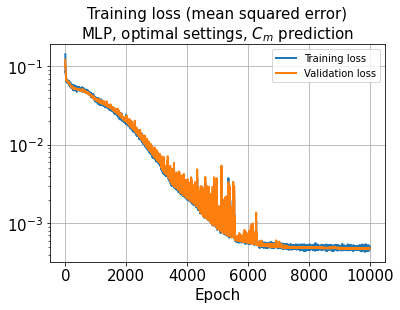

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

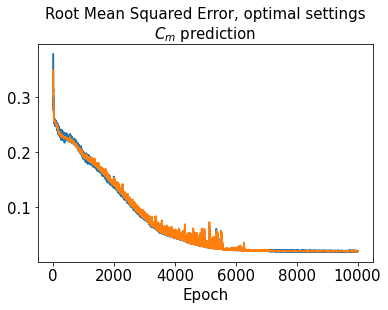

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

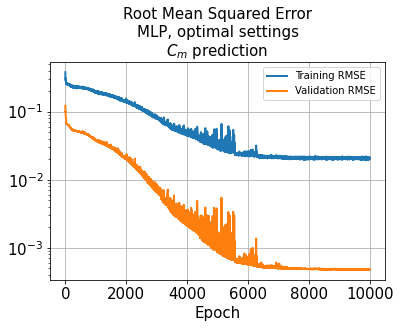

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate(x_train, y_train)

110/110 [==============================] - 0s 4ms/step - loss: 4.8390e-04 - rmse: 0.0206


In [37]:
val_results = model.evaluate(x_val, y_val)

32/32 [==============================] - 0s 4ms/step - loss: 4.7596e-04 - rmse: 0.0204


In [38]:
test_results = model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 3ms/step - loss: 5.0490e-04 - rmse: 0.0211


In [39]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

16/16 [==============================] - 0s 2ms/step


In [40]:
decoded_train_

array([[0.10462639],
       [0.9538719 ],
       [0.37061533],
       ...,
       [0.32977813],
       [0.14047572],
       [0.33874997]], dtype=float32)

In [41]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [42]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [43]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [46]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [47]:
model_directory = "D:\\TrainedModels\\20221226"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221226unsteadyValidation_MLP_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"unitsCmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [48]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [49]:
os.chdir(storage_dir)

In [50]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [71]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = smape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.05894401621928491
2.428250269667881


In [72]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= smape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.0575875538872598
2.2848919618953523


In [73]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= smape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.059998588851330116
2.3424805301807368


In [54]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [55]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [74]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [75]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [76]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [60]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

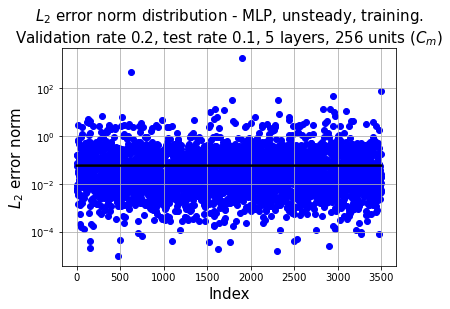

In [61]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

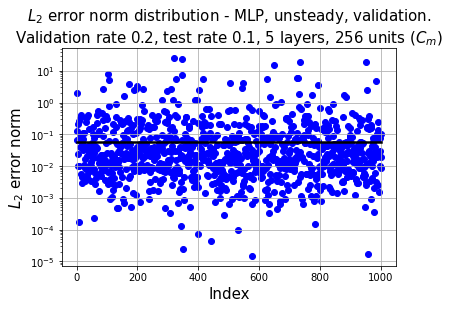

In [62]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

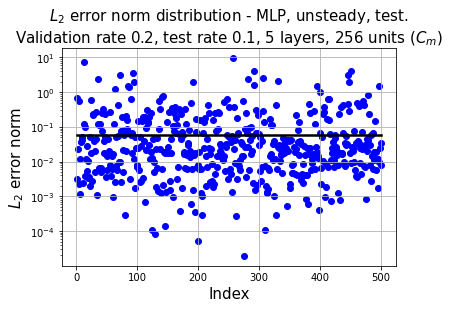

In [63]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict(x)

157/157 [==============================] - 0s 2ms/step


In [65]:
predicted.shape

(5000, 1)

In [66]:
t_train = t[index_train]
t_val = t[index_val]
t_test = t[index_test]

In [67]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [68]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [79]:
x += 10

In [87]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(x, Cm, 'k-', label='Ground truth')
    plt.plot(x, cm, 'k--', label='Predicted value')
    plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, iTest, color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cm: 0.0459


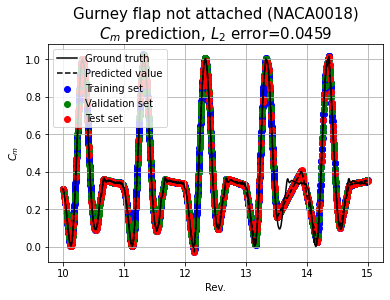

In [88]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(0, 1):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted#[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain = np.array(iTrain)
    iVal = np.array(iVal)
    iTest = np.array(iTest)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tTest, iTrain, iTest)

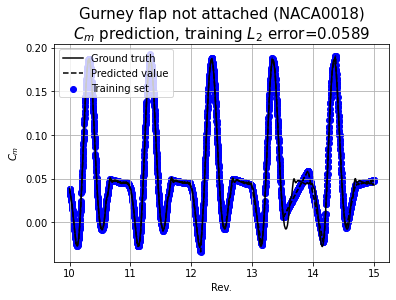

In [100]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, training $L_2$ error=%.4f' % l2_error_train
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

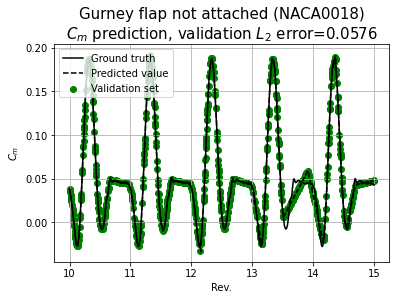

In [99]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, validation $L_2$ error=%.4f' % l2_error_val
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

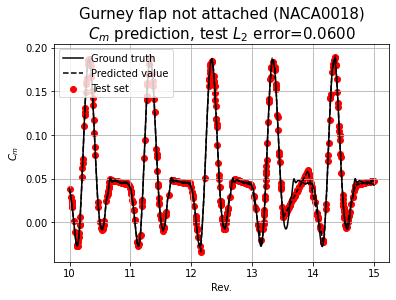

In [98]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, test $L_2$ error=%.4f' % l2_error_test
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

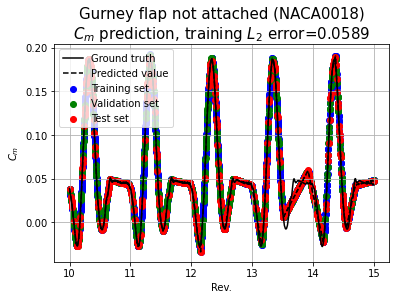

In [97]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)


title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, training $L_2$ error=%.4f' % l2_error_train
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()